# SWMM Green Infrastructure Project Documentation

## SWMM Data Plots

In this notebook, we will extract data from the simulation's output files using swmmtoolbox, and then plot the data over the most recent year (2014) using matplotlib's pyplot.

## Imports

In [1]:
from swmmtoolbox import swmmtoolbox
import glob
import matplotlib.pyplot as plt
import calendar # For months on the x-axis of plots

## Selecting the Output Files
We will first use glob to select the output files we want to extract data from

In [2]:
california_files = glob.glob('./california/*.out')
chicago_files = glob.glob('./chicago/*.out')
print(len(california_files), len(chicago_files))

3 3


## Identifying / Filtering the Variables to Extract
We will find the variables we want to extract using swmmtoolbox's catalog feature. The catalog feature requires an output file in order to list the variables available to extract.

We only want the 'system' variables, because these represent data of the entire system. We will remove the others using the filter() function.

In [3]:
extract_vars = swmmtoolbox.catalog(california_files[0])

We only want the 'system' variables, because these represent data of the entire system. We will remove all of the variables which are not of the system.

In [4]:
extract_vars = list(filter(lambda x: x[0] == 'system', extract_vars))

## Extracting the Data

### Chicago

We will extract the data for the Chicago block group first.


In [5]:
for file in chicago_files:
    gi_type = file[-6:-4] # ex. 060375508003_ng.out will give 'ng'
    print(gi_type)
    if gi_type == 'rb':
        chicago_rb = swmmtoolbox.extract(file, *extract_vars)
    elif gi_type == 'ng':
        chicago_ng = swmmtoolbox.extract(file, *extract_vars)
    else:
        chicago_rg = swmmtoolbox.extract(file, *extract_vars)

rg


/home/matas/anaconda3/envs/swmm/lib/python3.7/site-packages/swmmtoolbox/swmmtoolbox.py:800: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  result = pd.concat(jtsd, axis=1, join_axes=[jtsd[0].index])


ng
rb


#### Hourly to Daily Data
Since SWMM reports instantaneous simulation data at hourly intervals, we need to take the mean of each hour across each day to come up with that day's value.

Source: https://www.openswmm.org/Topic/4873/reporting-time-step-vs-rainfall-time-step

We will use pandas' resample function

In [6]:
chicago_rb_d = chicago_rb.resample('d').mean()
chicago_rg_d = chicago_rg.resample('d').mean()
chicago_ng_d = chicago_ng.resample('d').mean()

#### Runoff Correction
Since SWMM Run off output has the units - Length/time for intensity per time and total length (Source: , we divide by the subcatchment area to get depth in inches (which will match the Rainfall, Evaporation_infiltration data).

For now, we will take the subcatchment area from the input file manually. This can be automated using the Green Infrastructure Characteristics spreadsheet in the future.

Chicago - 170319800001

No Green Infrastructure - 4933.82198249943

Rain Barrel - 4299.47299178733 + 634.348990712674

Rain Garden - 4933.82198249943


In [10]:
chicago_ng_runoff = chicago_ng_d['system__Runoff'].apply(lambda x: x / 4933.82198249943)
chicago_rb_runoff = chicago_rb_d['system__Runoff'].apply(lambda x: x / 4933.82198249943)
chicago_rg_runoff = chicago_rg_d['system__Runoff'].apply(lambda x: x/ 4933.82198249943)

### Plotting

First, we will define the x-axis for the plot (365 days)

In [8]:
date = [i for i in range(365)]

#### 3 Variable Plots (Rainfall, Evaporation_infiltration, Runoff)

#### No Green Infrastructure Plot

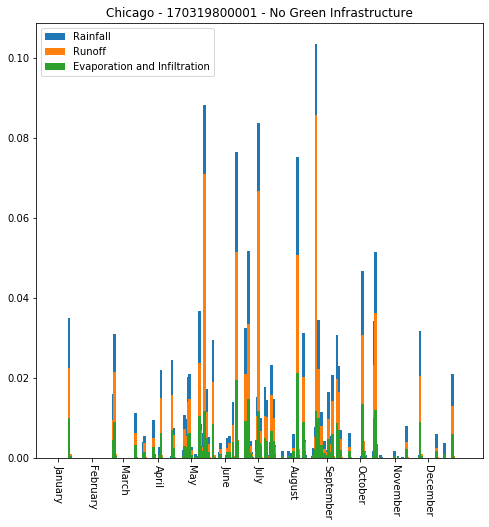

In [14]:
plt.figure(figsize=(8,8))
plt.title('Chicago - 170319800001 - No Green Infrastructure')
width = 2.5


plt.bar(date, chicago_ng_d['system__Rainfall'].iloc[-365:], width, label='Rainfall')
plt.bar(date, chicago_ng_runoff.iloc[-365:], width, label='Runoff')
plt.bar(date, chicago_ng_d['system__Evaporation_infiltration'].iloc[-365:], width, label='Evaporation and Infiltration')


plt.xticks([0,31,59,90,120,151,181,212,243,273,304,334], calendar.month_name[1:13], rotation=-90)
plt.legend()
plt.savefig('./chicago_no_green_infrastructure.svg', dpi=900)


#### Rain Barrel Plot

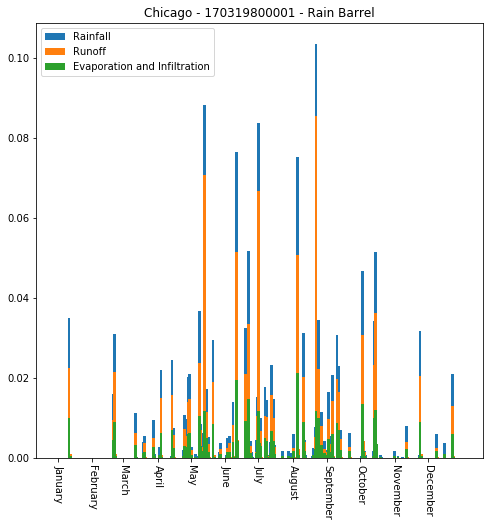

In [15]:
plt.figure(figsize=(8,8))
plt.title('Chicago - 170319800001 - Rain Barrel')
width = 2.5


plt.bar(date, chicago_rb_d['system__Rainfall'].iloc[-365:], width, label='Rainfall')
plt.bar(date, chicago_rb_runoff.iloc[-365:], width, label='Runoff')
plt.bar(date, chicago_rb_d['system__Evaporation_infiltration'].iloc[-365:], width, label='Evaporation and Infiltration')


plt.xticks([0,31,59,90,120,151,181,212,243,273,304,334], calendar.month_name[1:13], rotation=-90)
plt.legend()
plt.savefig('./chicago_rain_barrel.svg', dpi=900)


#### Rain Garden Plot


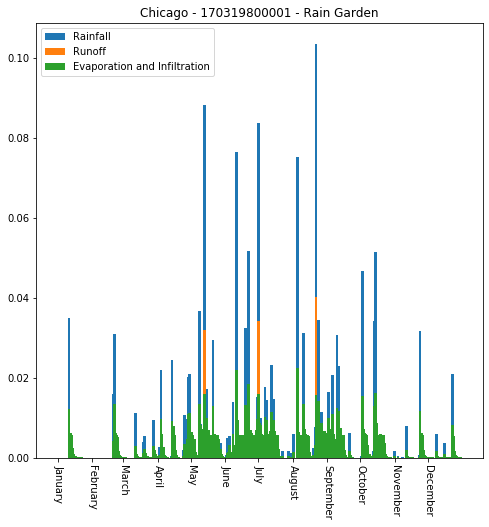

In [16]:
plt.figure(figsize=(8,8))
plt.title('Chicago - 170319800001 - Rain Garden')
width = 2.5


plt.bar(date, chicago_rg_d['system__Rainfall'].iloc[-365:], width, label='Rainfall')
plt.bar(date, chicago_rg_runoff.iloc[-365:], width, label='Runoff')
plt.bar(date, chicago_rg_d['system__Evaporation_infiltration'].iloc[-365:], width, label='Evaporation and Infiltration')


plt.xticks([0,31,59,90,120,151,181,212,243,273,304,334], calendar.month_name[1:13], rotation=-90)
plt.legend()
plt.savefig('./chicago_rain_garden.svg', dpi=900)

#### Chicago Water Balance Plot
The following code will plot the water balance over 2014 (Rainfall - Evaporation/Infiltration - Runoff)

Ideally, this would be equal to zero, as all of the rainfall not lost to evaporation or infiltration should be lost as runoff.

In [17]:
chicago_ng_balance = chicago_ng_d['system__Rainfall'] - chicago_ng_d['system__Evaporation_infiltration'] - chicago_ng_runoff

In [18]:
print('Mean:', chicago_ng_balance.iloc[-365:].mean())
print('Max:', chicago_ng_balance.iloc[-365:].max())
print('Min:', chicago_ng_balance.iloc[-365:].min())

Mean: 0.0001487857221665899
Max: 0.00607520283510582
Min: -0.006886609389110631


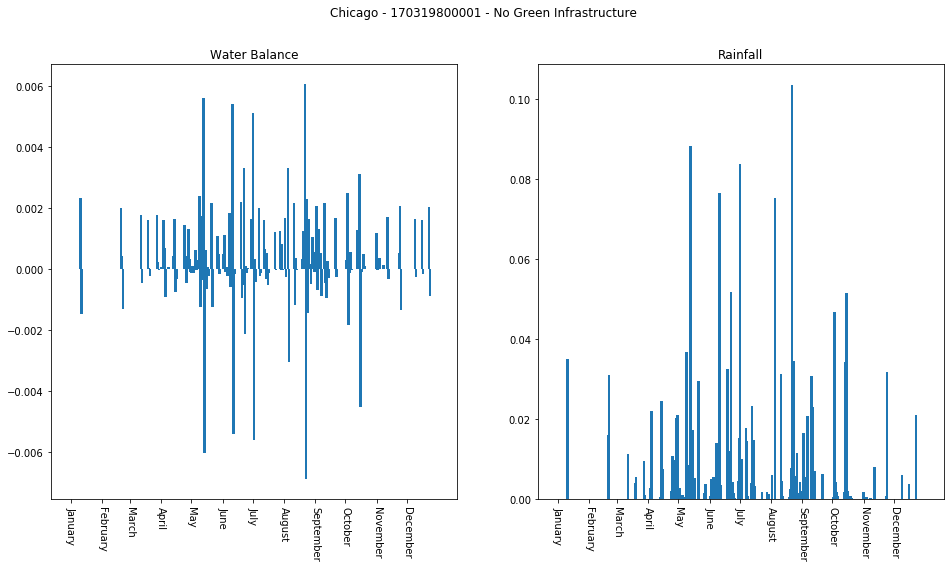

In [29]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
fig.suptitle('Chicago - 170319800001 - No Green Infrastructure')
width = 2.5

ax[0].bar(date, chicago_ng_balance.iloc[-365:], width)
ax[0].set_title('Water Balance')
ax[0].set_xticks([0,31,59,90,120,151,181,212,243,273,304,334])
ax[0].set_xticklabels(calendar.month_name[1:13], rotation=-90)


ax[1].bar(date, chicago_ng_d['system__Rainfall'].iloc[-365:], width)
ax[1].set_title('Rainfall')
ax[1].set_xticks([0,31,59,90,120,151,181,212,243,273,304,334])
ax[1].set_xticklabels(calendar.month_name[1:13], rotation=-90)

plt.show()

The data seems to spike during periods of precipitation, as seen when comparing the precipitation plot to the water balance plot. 

The difference is relatively small for a daily scale (0.006 inches)

## California

In [30]:
for file in california_files:
    gi_type = file[-6:-4]
    print(gi_type)
    if gi_type == 'rb':
        california_rb = swmmtoolbox.extract(file, *extract_vars)
    elif gi_type == 'rg':
        california_rg = swmmtoolbox.extract(file, *extract_vars)
    else:
        california_ng = swmmtoolbox.extract(file, *extract_vars)

rg
ng
rb


In [37]:
california_ng_d = california_ng.resample('d').mean()
california_rb_d = california_rb.resample('d').mean()
california_rg_d = california_rg.resample('d').mean()

In [38]:
california_ng_runoff = california_ng_d['system__Runoff'].apply(lambda x: x / 67.3855335000138)
california_rb_runoff = california_rb_d['system__Runoff'].apply(lambda x: x / 67.3855335000138)
california_rg_runoff = california_rg_d['system__Runoff'].apply(lambda x: x / 67.3855335000138)

#### California Water Balance Plot

In [39]:
california_ng_balance = (california_ng_d['system__Rainfall'].iloc[-365:] - california_ng_d['system__Evaporation_infiltration'].iloc[-365:] - california_ng_runoff.iloc[-365:])
print('Mean:', california_ng_balance.mean())
print('Max:', california_ng_balance.max())
print('Min:', california_ng_balance.min())

Mean: 4.17671693626241e-05
Max: 0.005128679161787834
Min: -0.005667770323576609


The mean is relatively close to zero because there is little precipitation in this block group during the summer months.

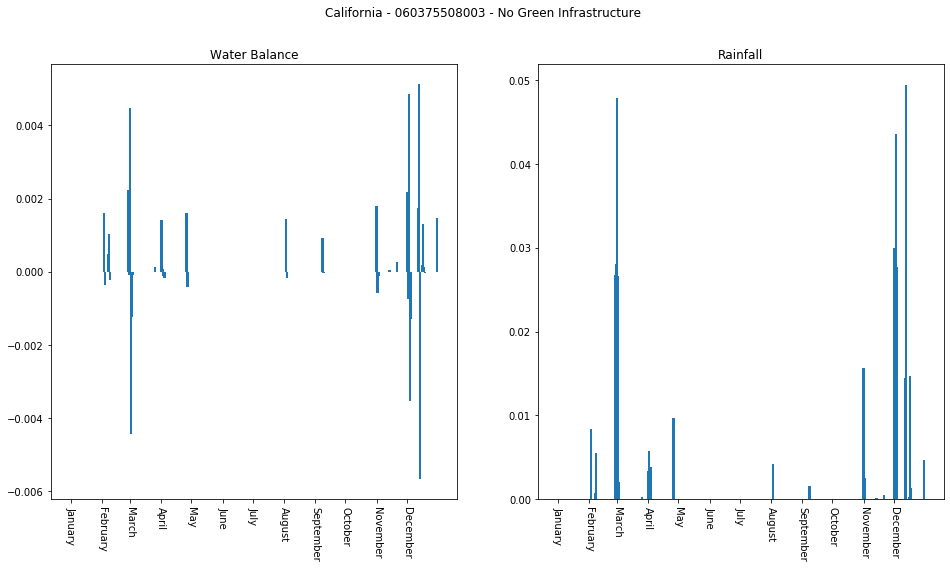

In [40]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
fig.suptitle('California - 060375508003 - No Green Infrastructure')
width = 2.5

ax[0].bar(date, california_ng_balance, width)
ax[0].set_title('Water Balance')
ax[0].set_xticks([0,31,59,90,120,151,181,212,243,273,304,334])
ax[0].set_xticklabels(calendar.month_name[1:13], rotation=-90)


ax[1].bar(date, california_ng_d['system__Rainfall'].iloc[-365:], width)
ax[1].set_title('Rainfall')
ax[1].set_xticks([0,31,59,90,120,151,181,212,243,273,304,334])
ax[1].set_xticklabels(calendar.month_name[1:13], rotation=-90)

plt.show()

#### 3 Variable Plots (Rainfall, Evaporation_infiltration, Runoff)
#### No Green Infrastructure

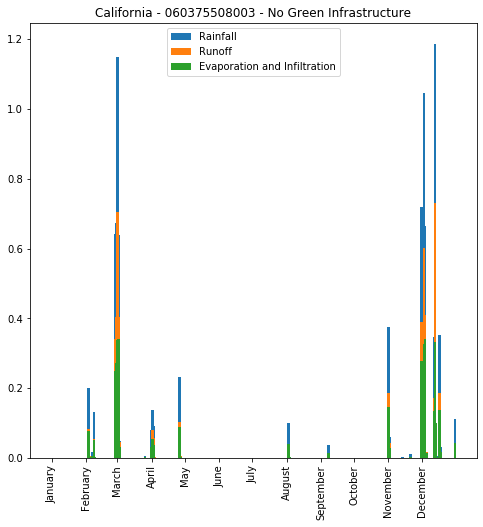

In [113]:
plt.figure(figsize=(8,8))
plt.title('California - 060375508003 - No Green Infrastructure')
width = 2.5


plt.bar(date, california_ng_d['system__Rainfall'].iloc[-365:], width, label='Rainfall')
plt.bar(date, california_ng_runoff.iloc[-365:], width, label='Runoff')
plt.bar(date, california_ng_d['system__Evaporation_infiltration'].iloc[-365:], width, label='Evaporation and Infiltration')


plt.xticks([0,31,59,90,120,151,181,212,243,273,304,334], calendar.month_name[1:13], rotation=90)
plt.legend()
plt.savefig('./california/california_no_green_infrastructure.svg', dpi=900)

#### Rain Barrel

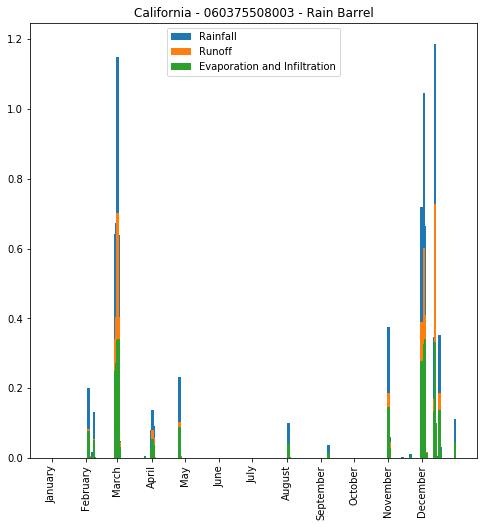

In [115]:
plt.figure(figsize=(8,8))
plt.title('California - 060375508003 - Rain Barrel')
width = 2.5


plt.bar(date, california_rb_d['system__Rainfall'].iloc[-365:], width, label='Rainfall')
plt.bar(date, california_rb_runoff.iloc[-365:], width, label='Runoff')
plt.bar(date, california_rb_d['system__Evaporation_infiltration'].iloc[-365:], width, label='Evaporation and Infiltration')


plt.xticks([0,31,59,90,120,151,181,212,243,273,304,334], calendar.month_name[1:13], rotation=90)
plt.legend()
plt.savefig('./california/california_rain_barrel.svg', dpi=900)

#### Rain Garden

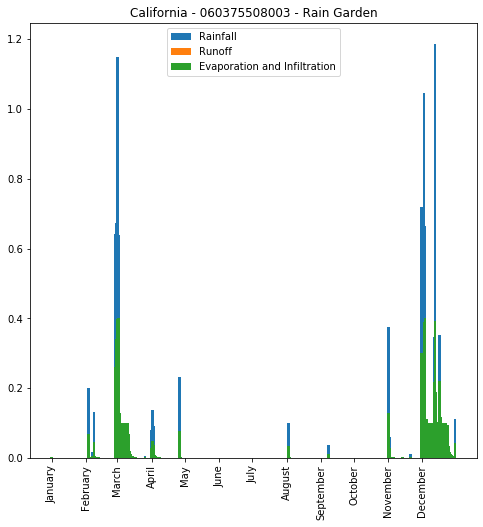

In [119]:
plt.figure(figsize=(8,8))
plt.title('California - 060375508003 - Rain Garden')
width = 2.5


plt.bar(date, california_rg_d['system__Rainfall'].iloc[-365:], width, label='Rainfall')
plt.bar(date, california_rg_runoff.iloc[-365:], width, label='Runoff')
plt.bar(date, california_rg_d['system__Evaporation_infiltration'].iloc[-365:], width, label='Evaporation and Infiltration')


plt.xticks([0,31,59,90,120,151,181,212,243,273,304,334], calendar.month_name[1:13], rotation=90)
plt.legend()
plt.savefig('./california/california_rain_garden.svg', dpi=900)

#### Rain Barrel Water Balance

In [118]:
rb_balance = (california_rb_d['system__Rainfall'].iloc[-365:] - california_rb_d['system__Evaporation_infiltration'].iloc[-365:] - california_rb_runoff.iloc[-365:])
print('Mean:', balance.mean())
print('Max:', balance.max())
print('Min:', balance.min())

Mean: 0.0010024120647029785
Max: 0.12308829988290793
Min: -0.13602648776583864


#### Rain Garden Water Balance

In [120]:
rg_balance = (california_rg_d['system__Rainfall'].iloc[-365:] - california_rg_d['system__Evaporation_infiltration'].iloc[-365:] - california_rg_runoff.iloc[-365:])
print('Mean:', balance.mean())
print('Max:', balance.max())
print('Min:', balance.min())

Mean: 0.0010024120647029785
Max: 0.12308829988290793
Min: -0.13602648776583864


 # Extracting All Variables

In [37]:
date = [i for i in range(365)]
gi_types = {'ng': 'No Green Infrastructure', 'rb': 'Rain Barrel', 'rg': 'Rain Garden'}

## Chicago

rg
['subcatchment', 'Subcatch1', 'Rainfall']
['subcatchment', 'Subcatch1', 'Snow_depth']
['subcatchment', 'Subcatch1', 'Evaporation_loss']
['subcatchment', 'Subcatch1', 'Infiltration_loss']
['subcatchment', 'Subcatch1', 'Runoff_rate']
['subcatchment', 'Subcatch1', 'Groundwater_outflow']
['subcatchment', 'Subcatch1', 'Groundwater_elevation']
['subcatchment', 'Subcatch1', 'Soil_moisture']
['subcatchment', 'Subcatch2', 'Rainfall']
['subcatchment', 'Subcatch2', 'Snow_depth']
['subcatchment', 'Subcatch2', 'Evaporation_loss']
['subcatchment', 'Subcatch2', 'Infiltration_loss']
['subcatchment', 'Subcatch2', 'Runoff_rate']
['subcatchment', 'Subcatch2', 'Groundwater_outflow']
['subcatchment', 'Subcatch2', 'Groundwater_elevation']
['subcatchment', 'Subcatch2', 'Soil_moisture']
['subcatchment', 'Subcatch3', 'Rainfall']
['subcatchment', 'Subcatch3', 'Snow_depth']
['subcatchment', 'Subcatch3', 'Evaporation_loss']
['subcatchment', 'Subcatch3', 'Infiltration_loss']
['subcatchment', 'Subcatch3', 'Runof

/home/matas/anaconda3/envs/swmm/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


['subcatchment', 'Subcatch3', 'Groundwater_outflow']
['subcatchment', 'Subcatch3', 'Groundwater_elevation']
['subcatchment', 'Subcatch3', 'Soil_moisture']
['subcatchment', 'Subcatch4', 'Rainfall']
['subcatchment', 'Subcatch4', 'Snow_depth']
['subcatchment', 'Subcatch4', 'Evaporation_loss']
['subcatchment', 'Subcatch4', 'Infiltration_loss']
['subcatchment', 'Subcatch4', 'Runoff_rate']
['subcatchment', 'Subcatch4', 'Groundwater_outflow']
['subcatchment', 'Subcatch4', 'Groundwater_elevation']
['subcatchment', 'Subcatch4', 'Soil_moisture']
['node', 'Cisterns', 'Depth_above_invert']
['node', 'Cisterns', 'Hydraulic_head']
['node', 'Cisterns', 'Volume_stored_ponded']
['node', 'Cisterns', 'Lateral_inflow']
['node', 'Cisterns', 'Total_inflow']
['node', 'Cisterns', 'Flow_lost_flooding']
['node', 'Outfall1', 'Depth_above_invert']
['node', 'Outfall1', 'Hydraulic_head']
['node', 'Outfall1', 'Volume_stored_ponded']
['node', 'Outfall1', 'Lateral_inflow']
['node', 'Outfall1', 'Total_inflow']
['node', 

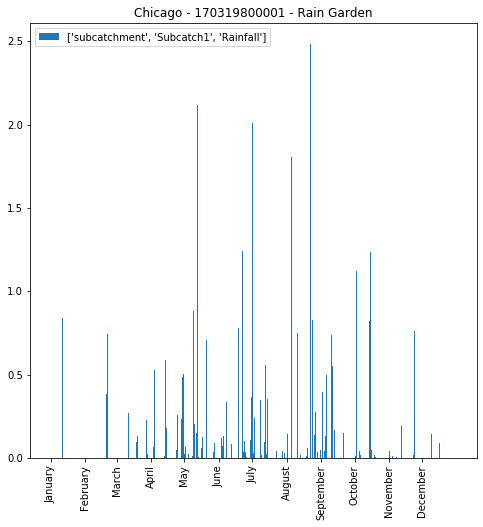

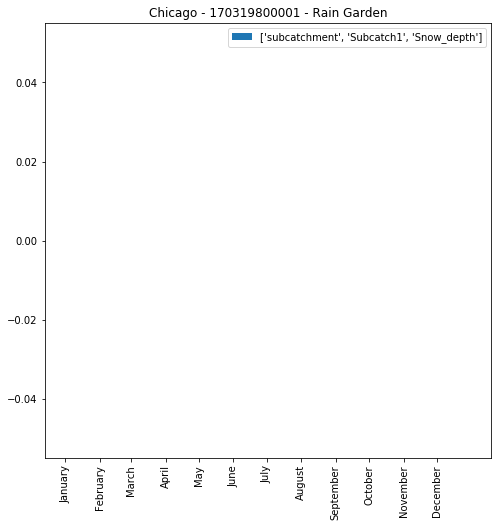

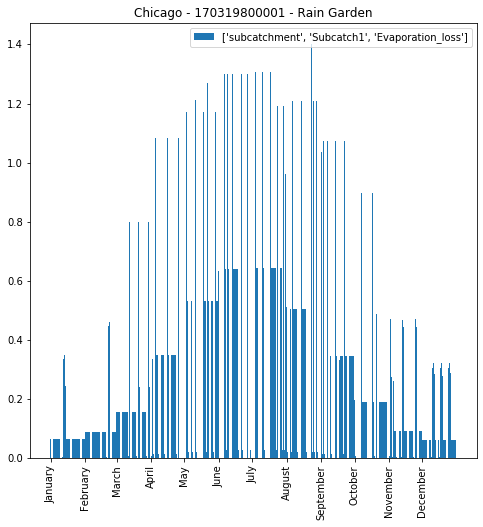

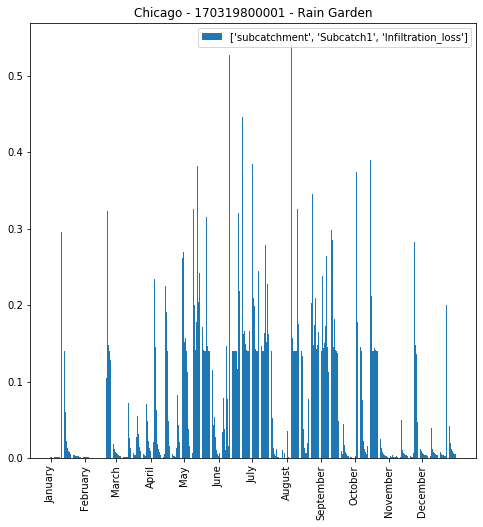

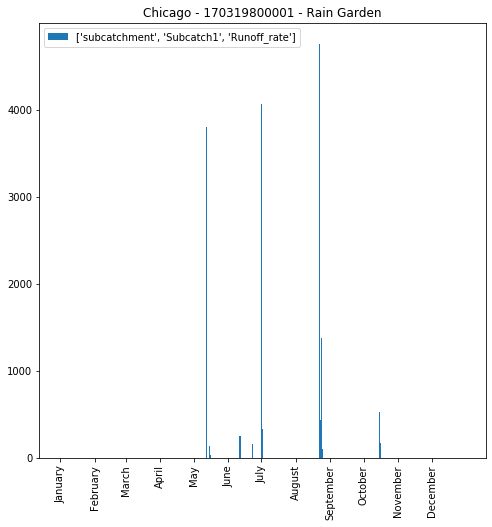

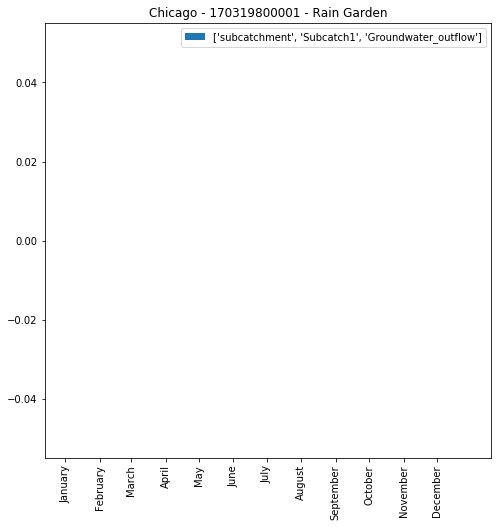

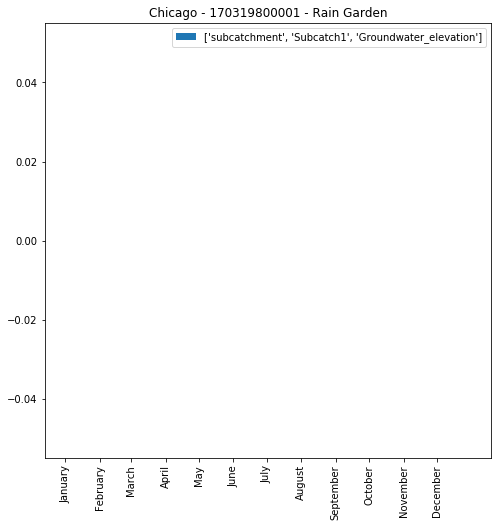

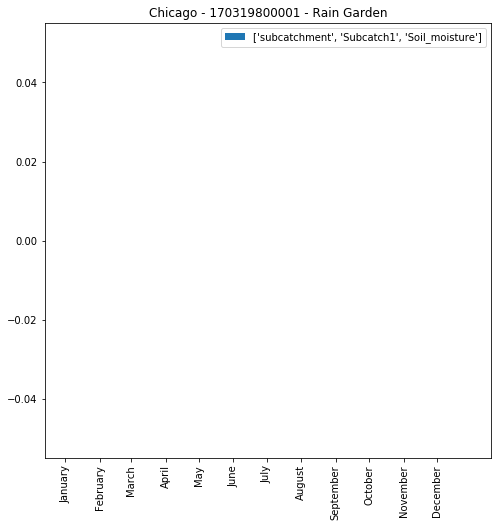

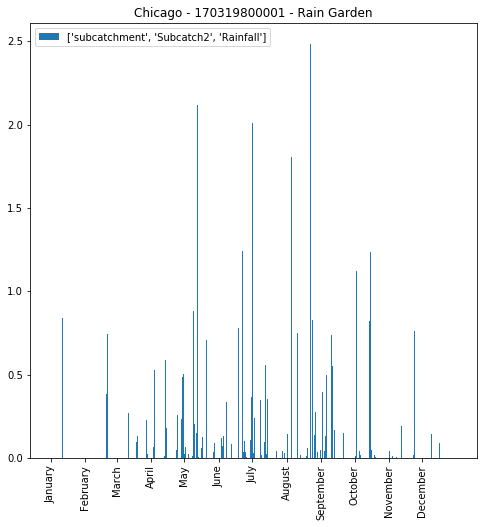

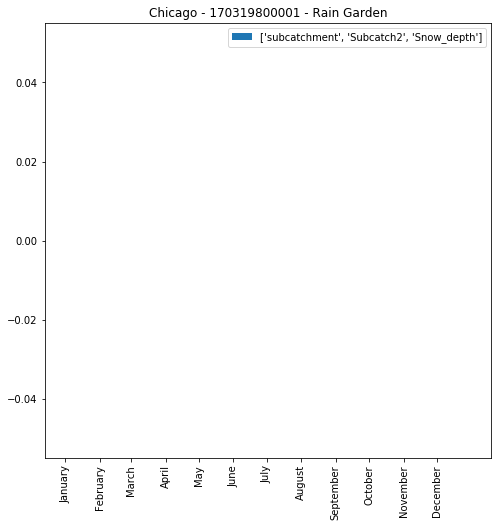

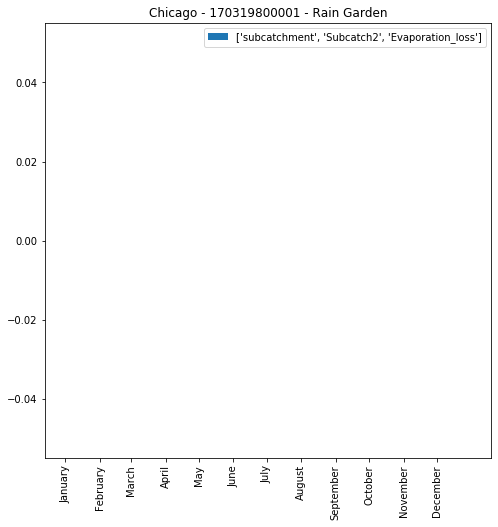

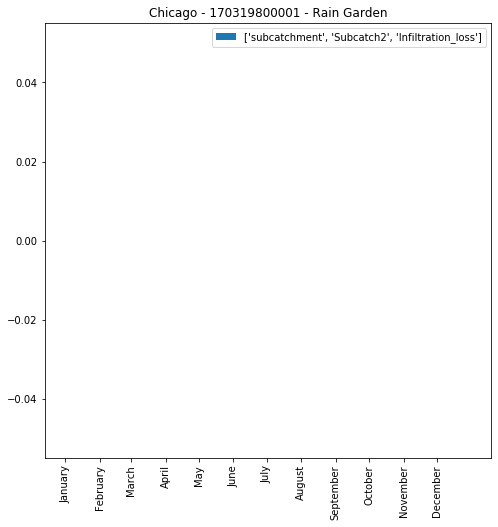

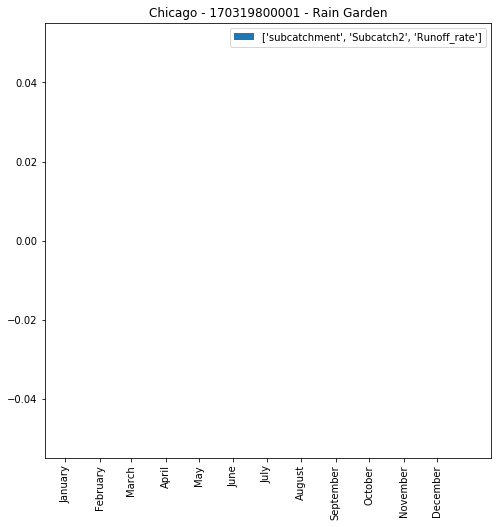

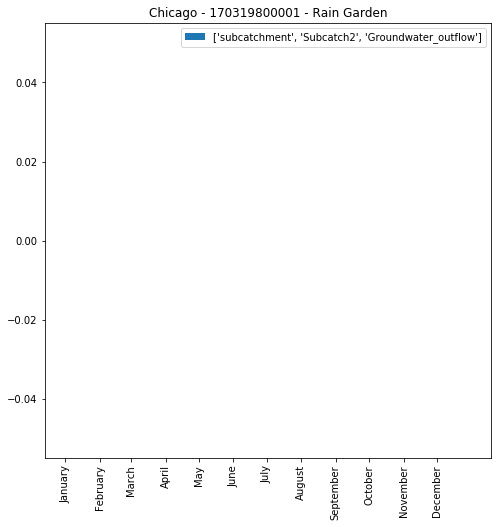

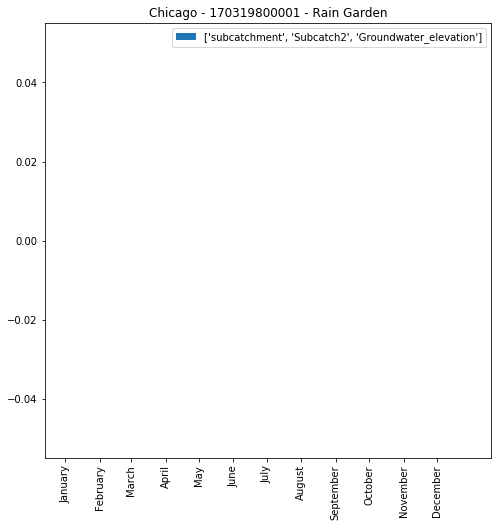

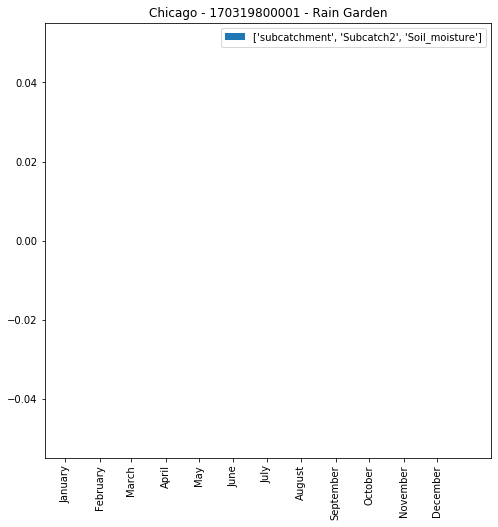

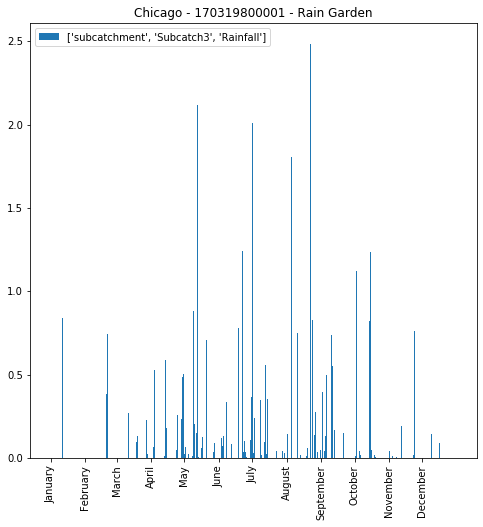

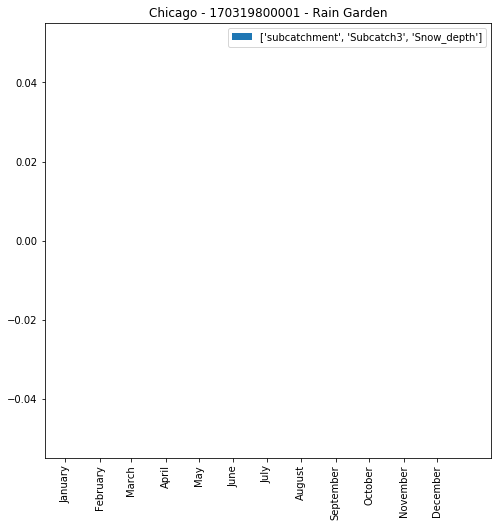

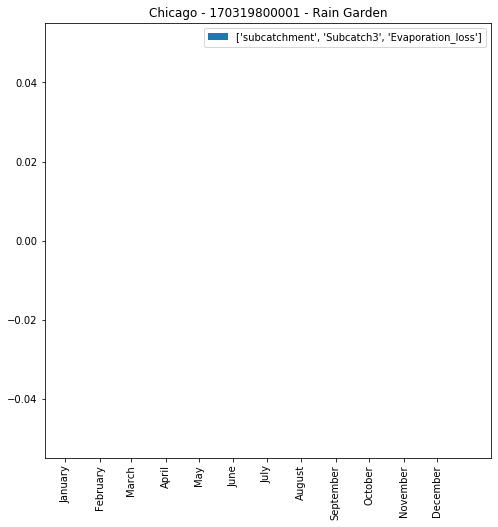

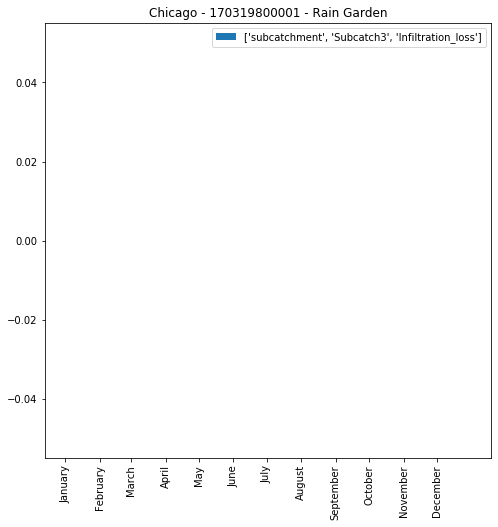

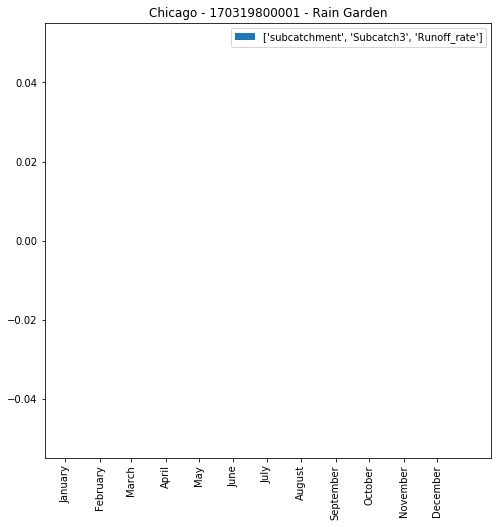

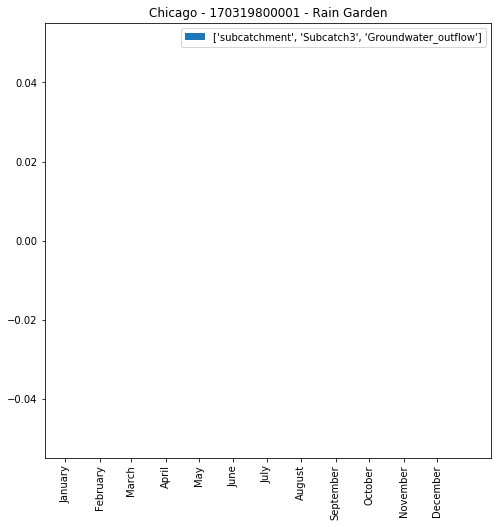

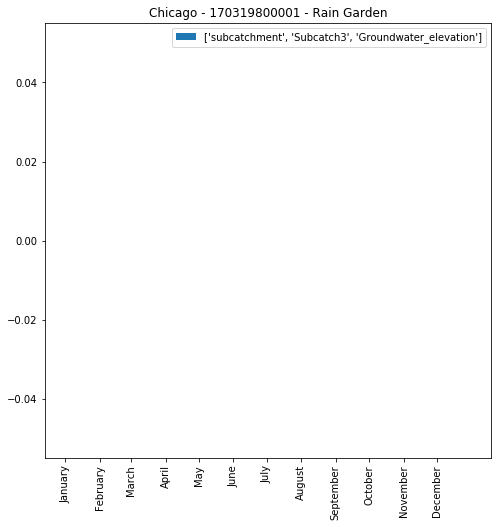

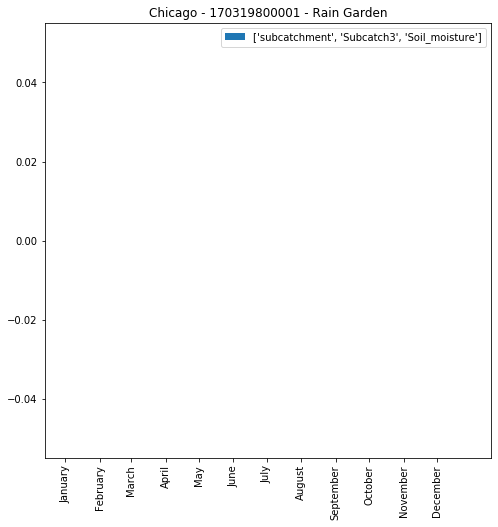

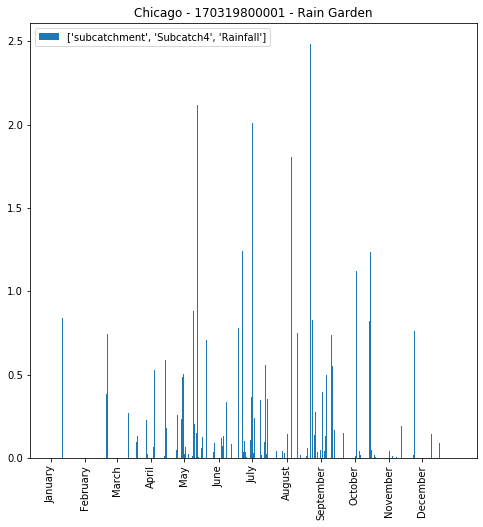

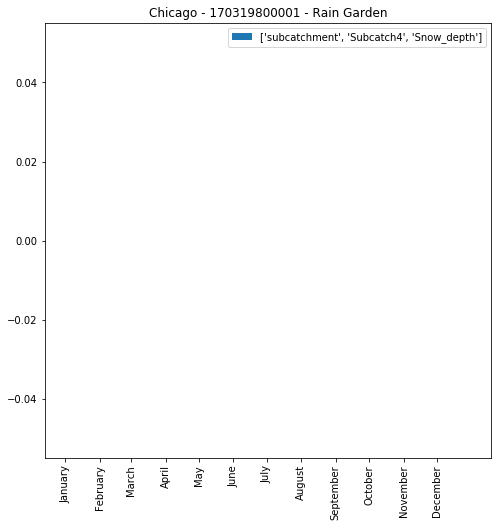

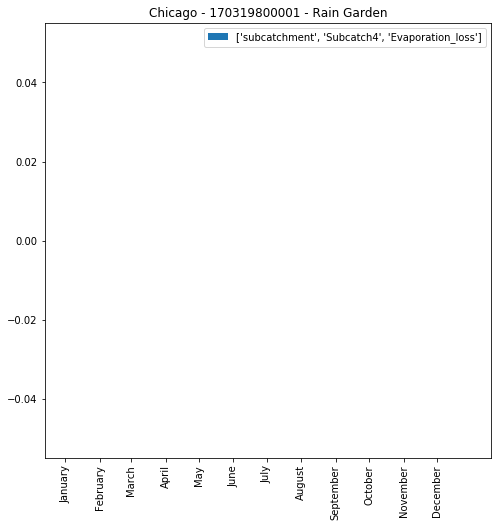

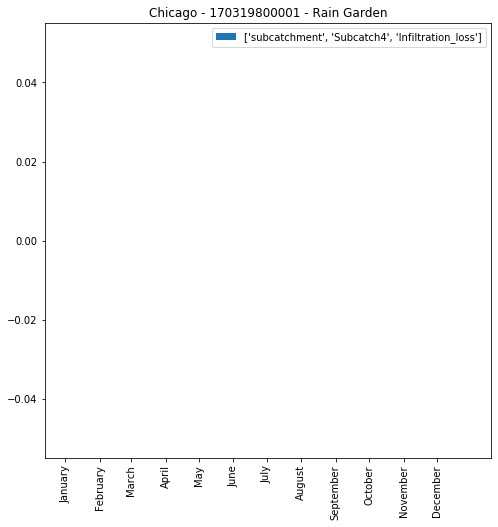

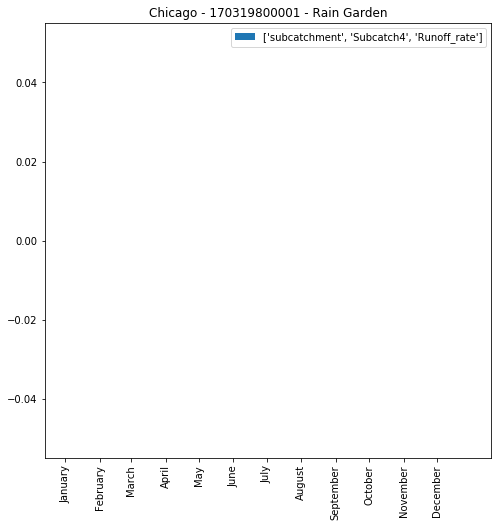

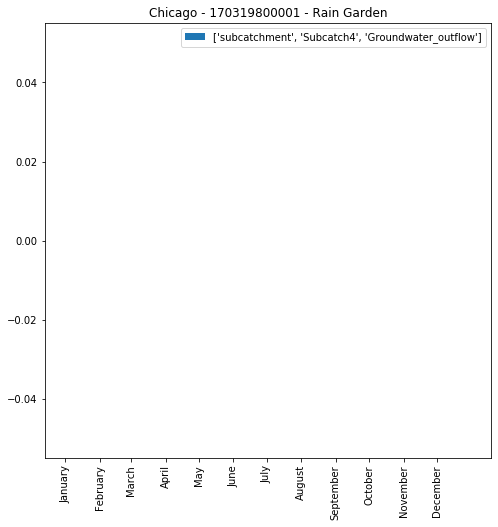

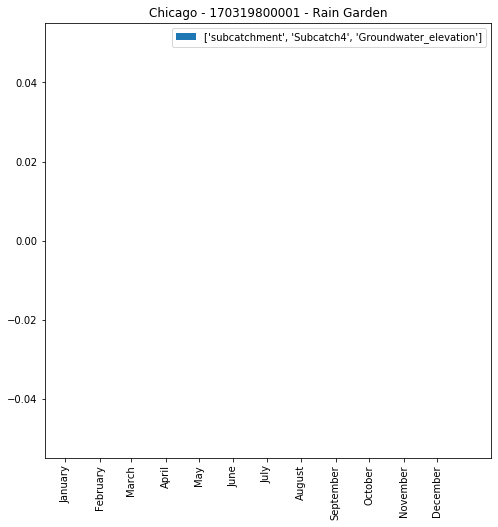

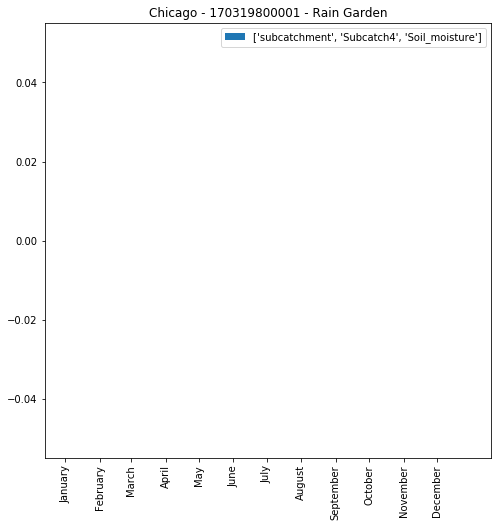

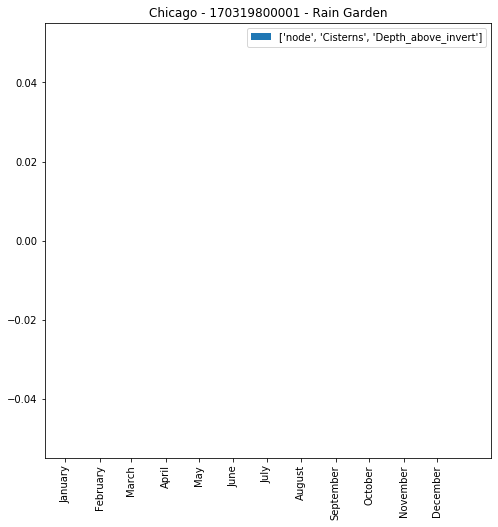

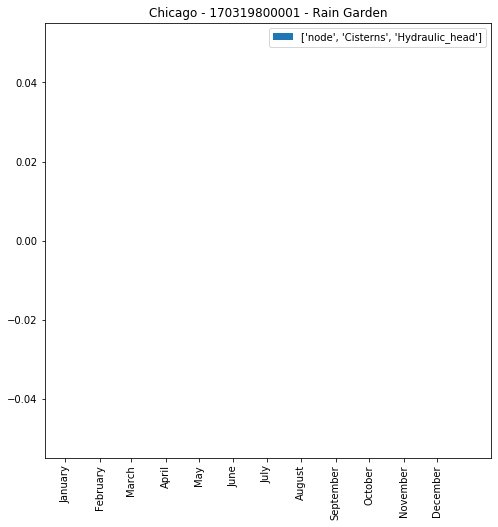

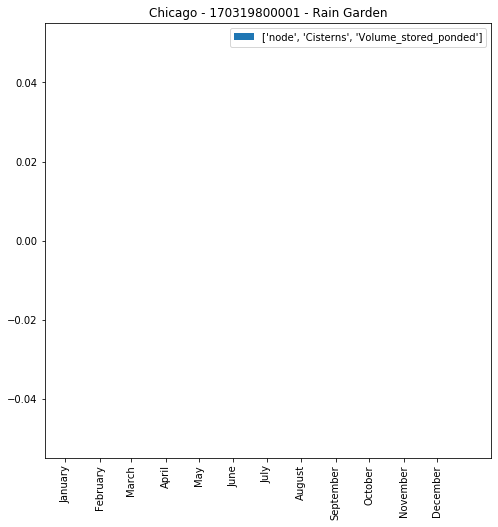

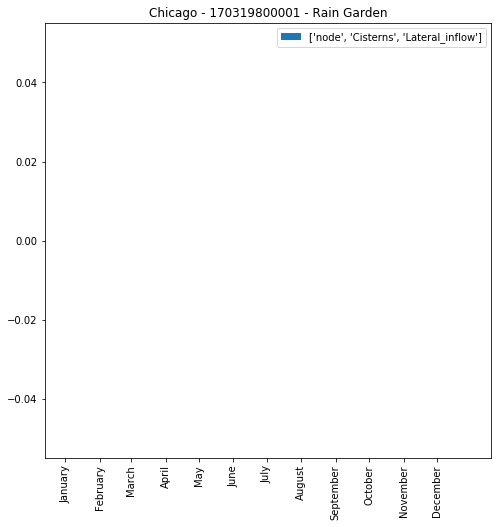

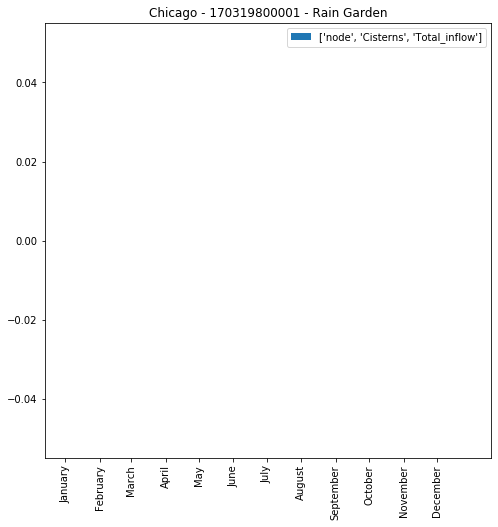

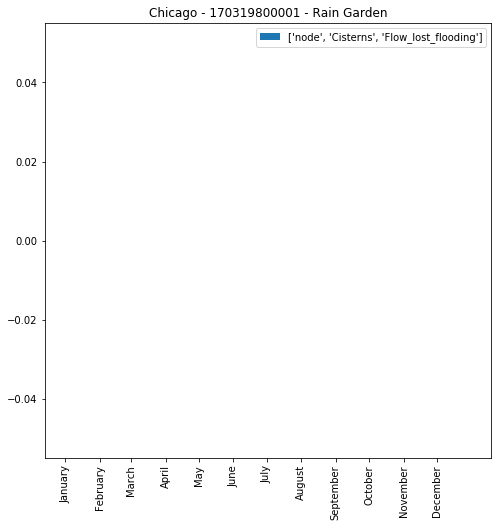

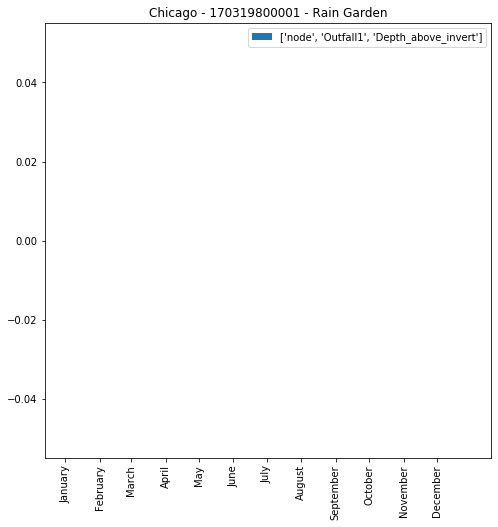

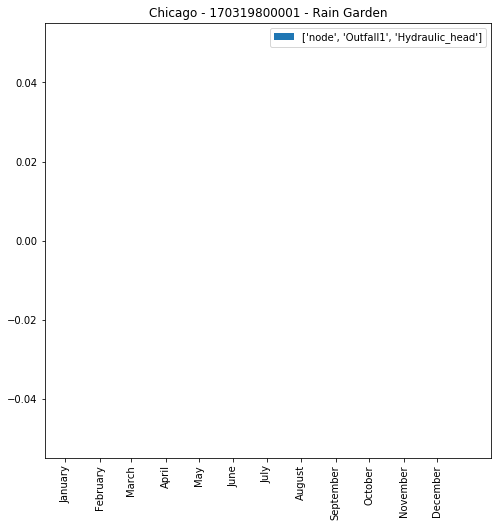

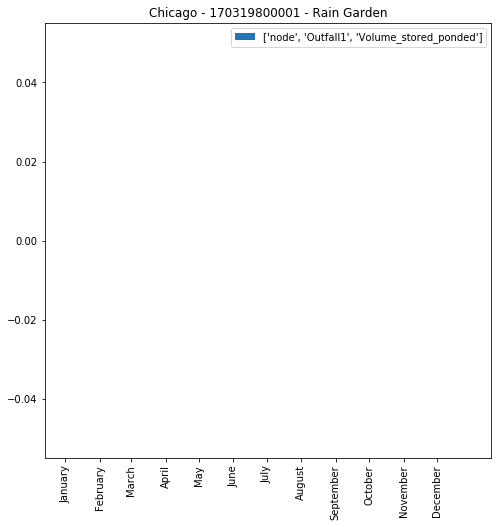

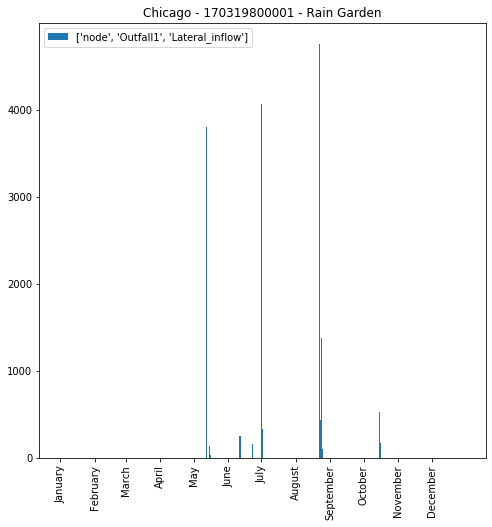

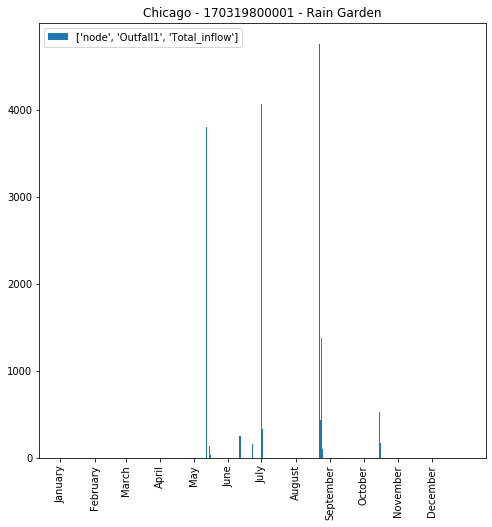

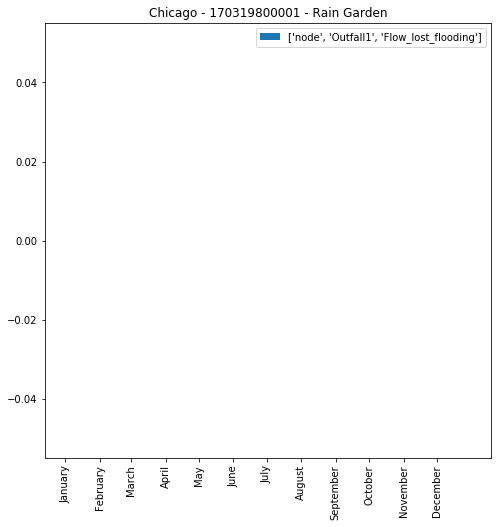

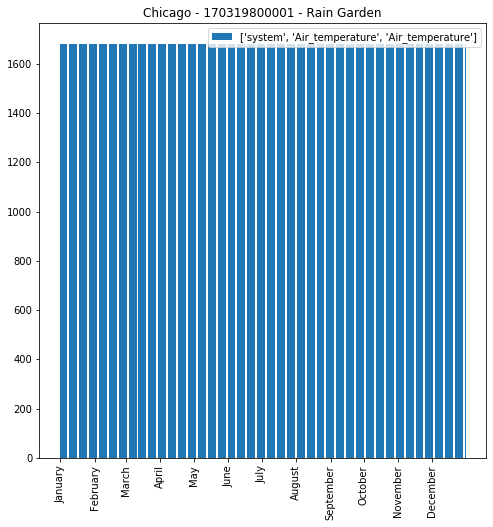

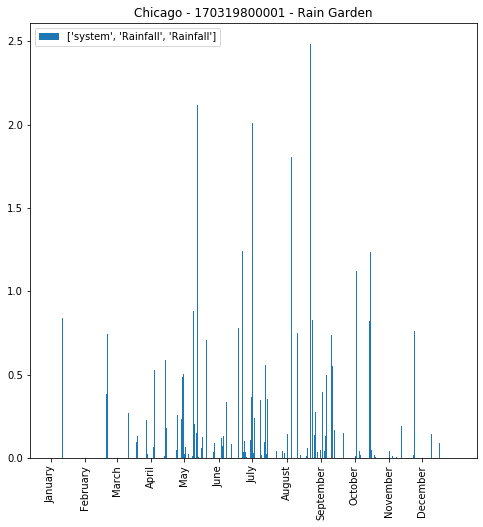

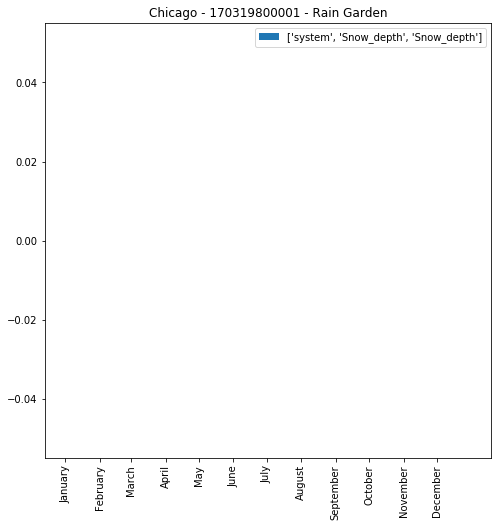

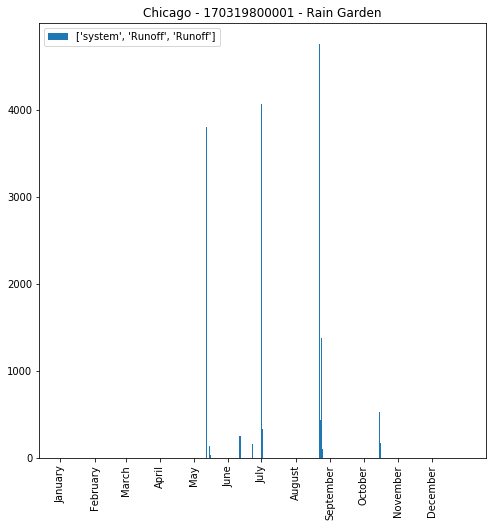

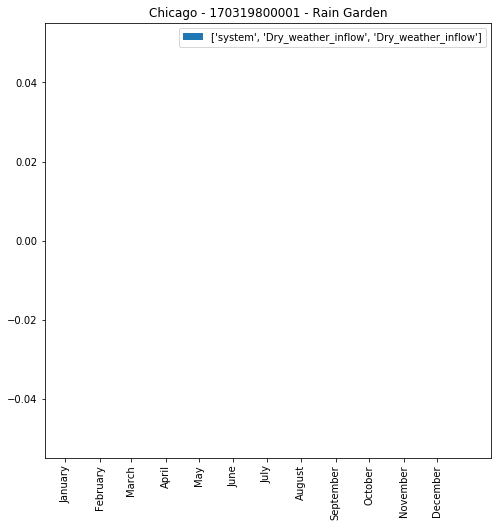

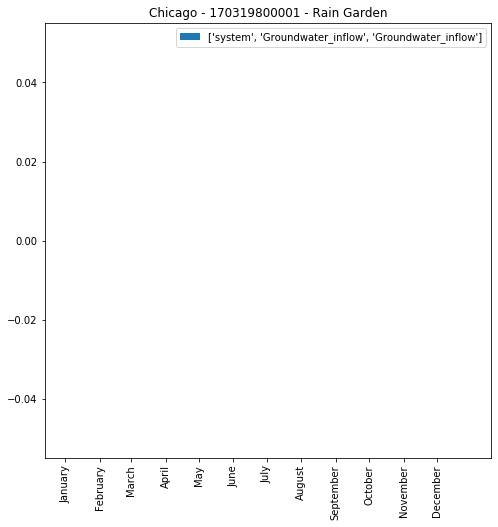

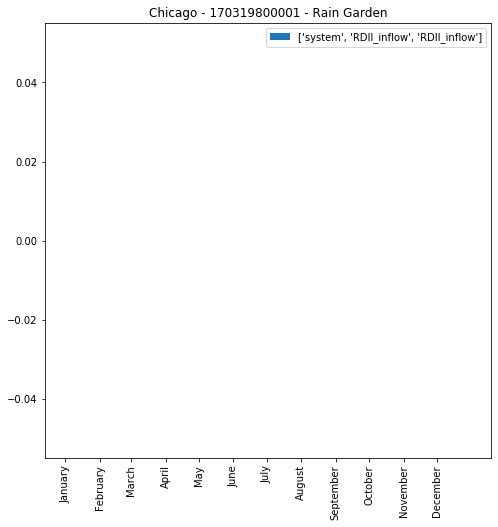

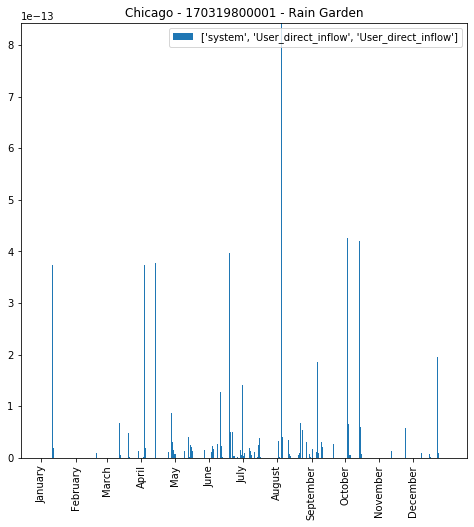

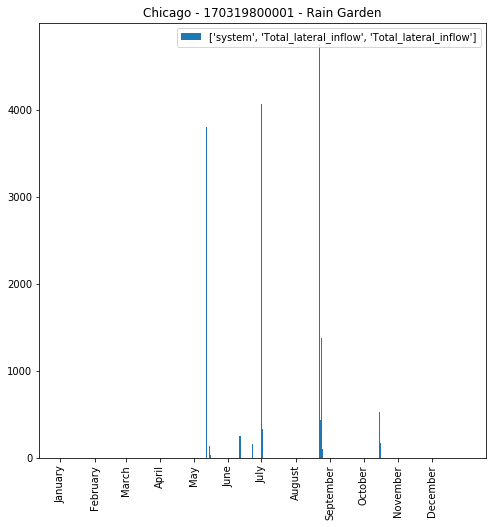

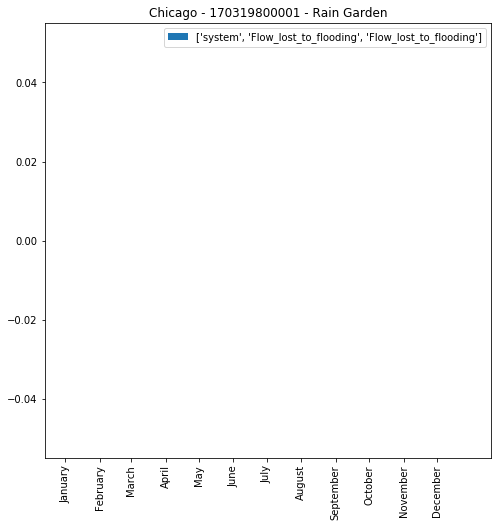

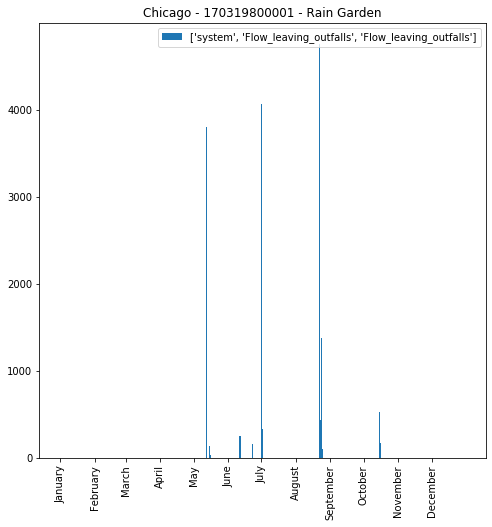

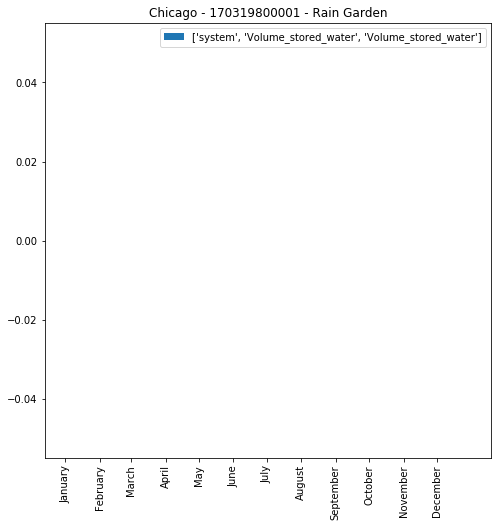

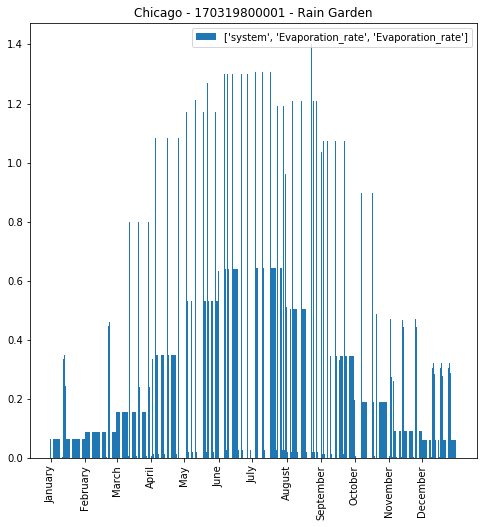

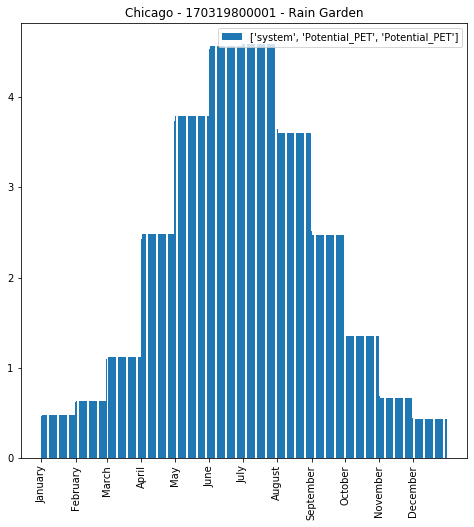

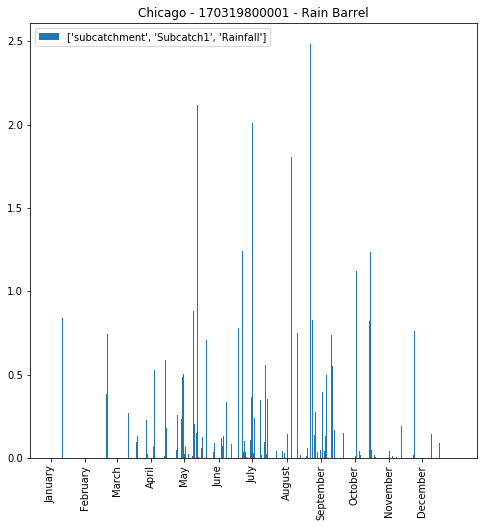

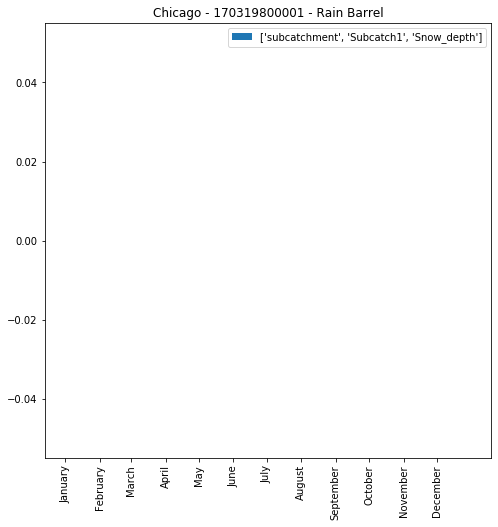

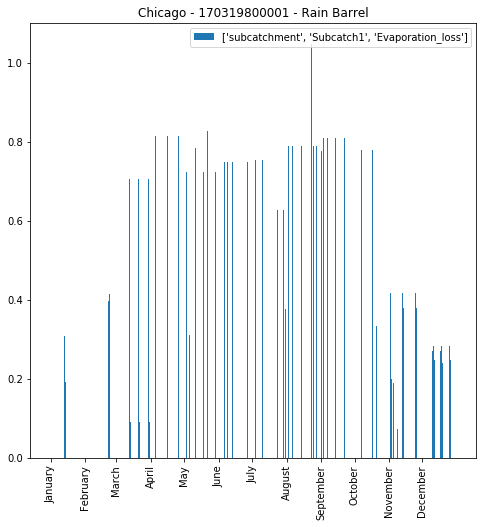

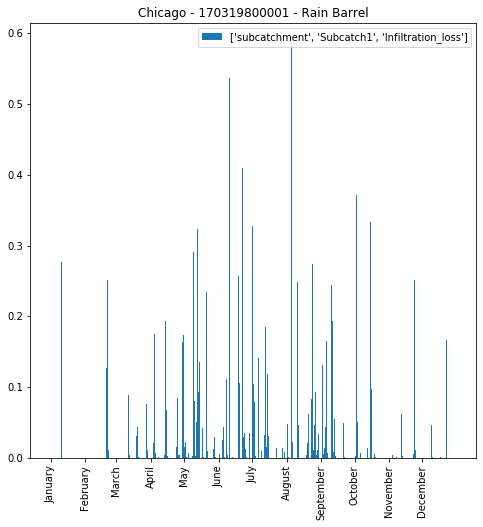

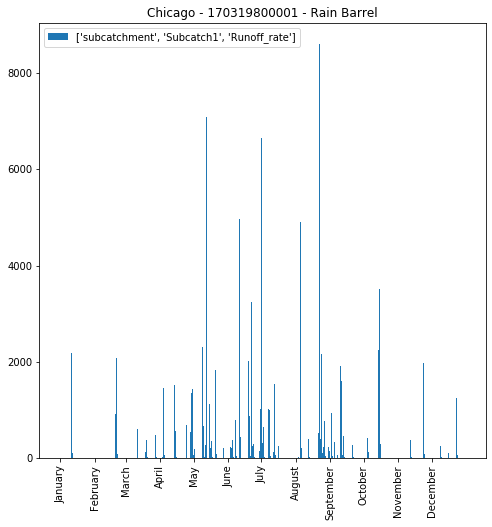

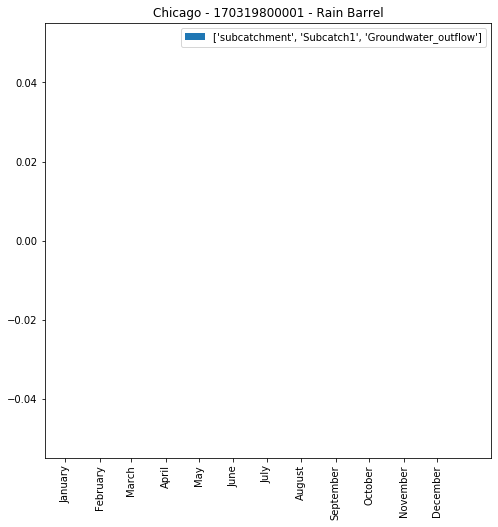

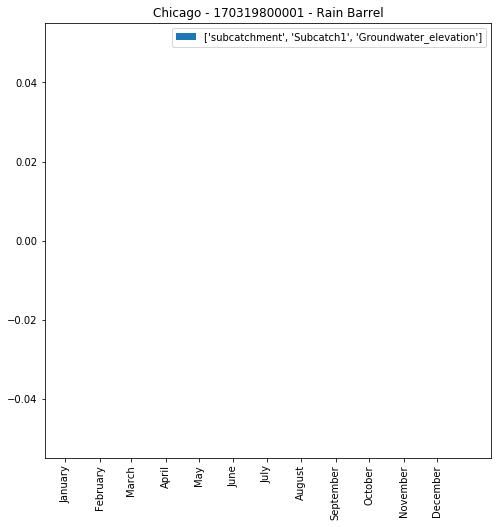

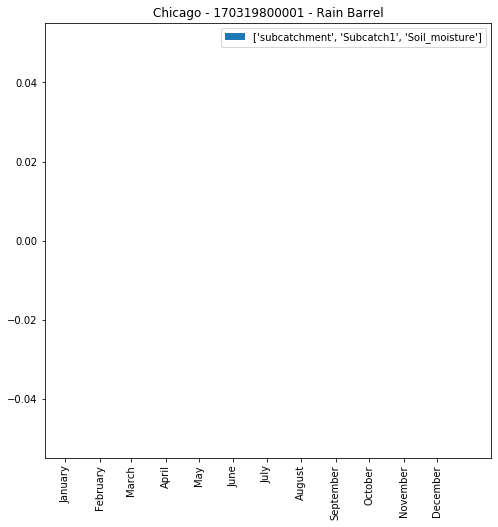

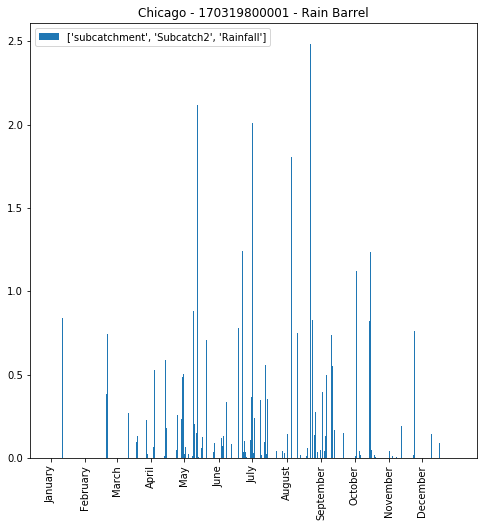

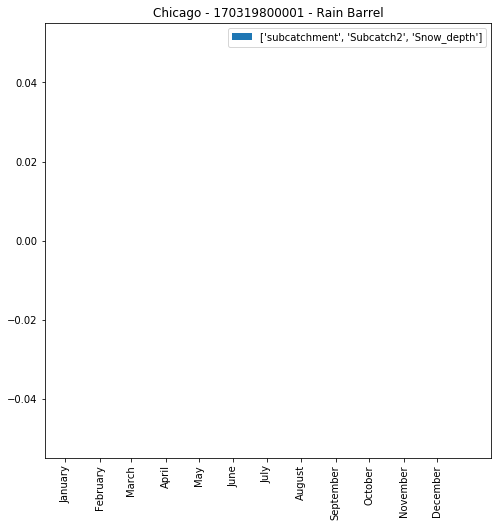

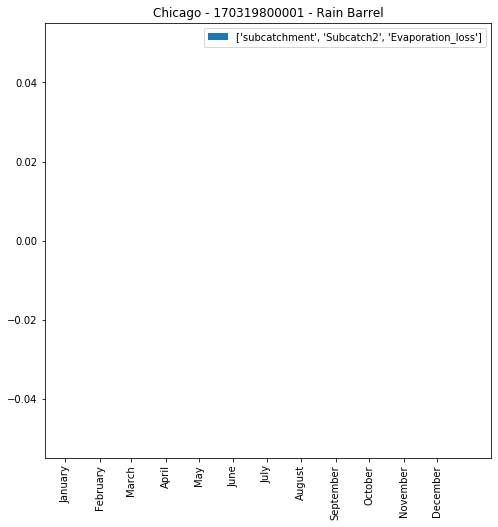

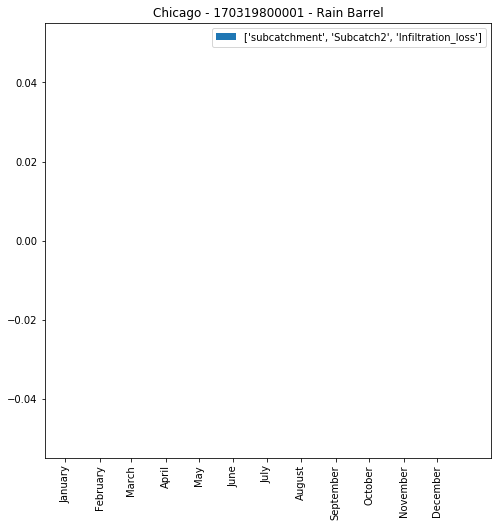

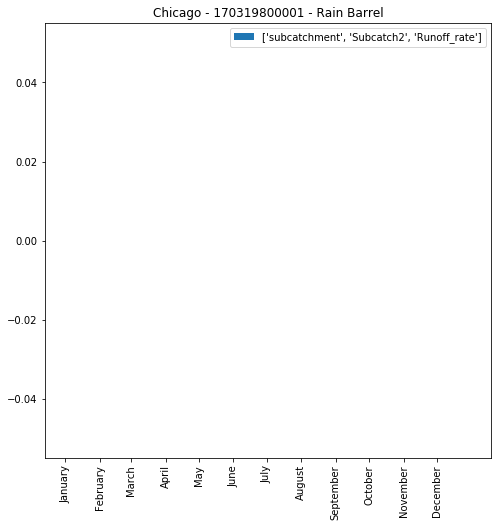

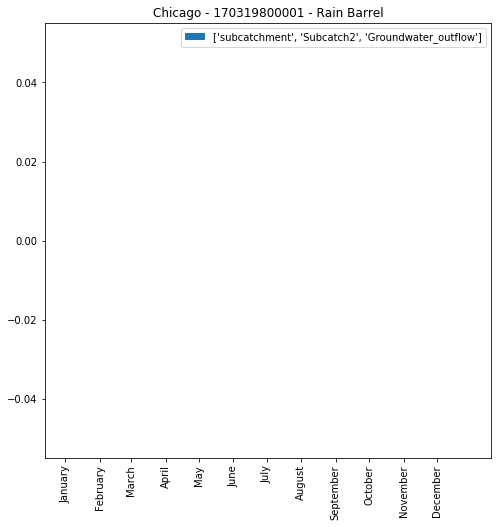

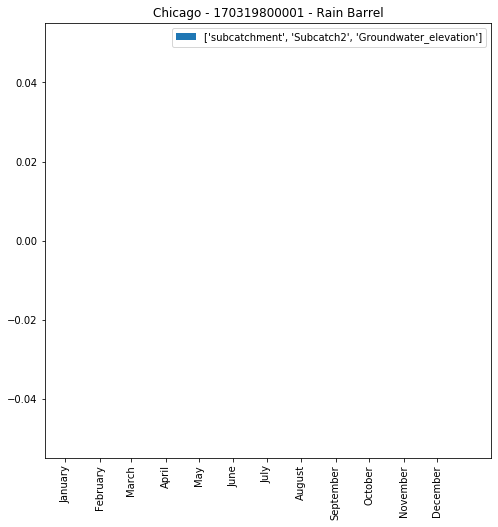

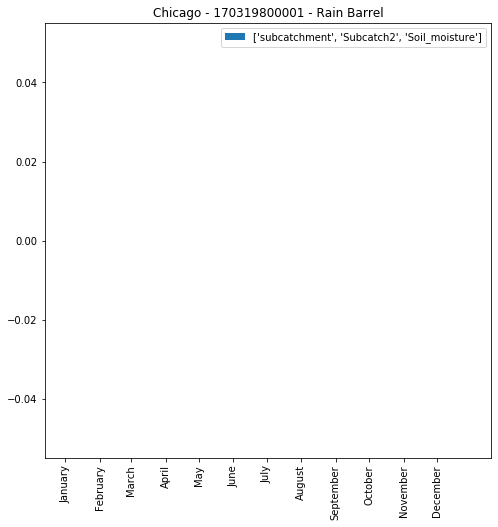

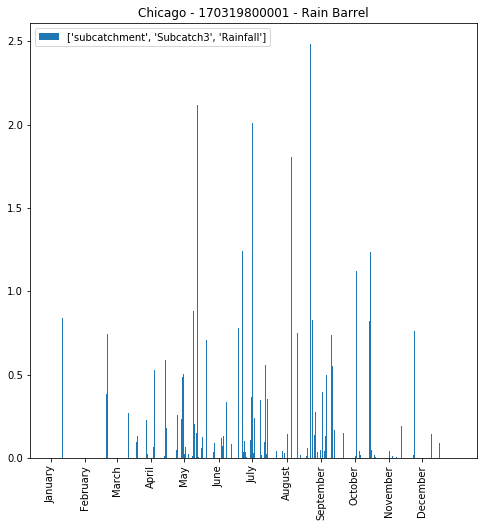

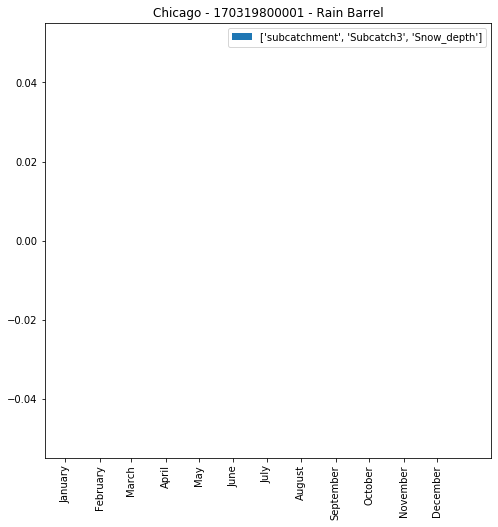

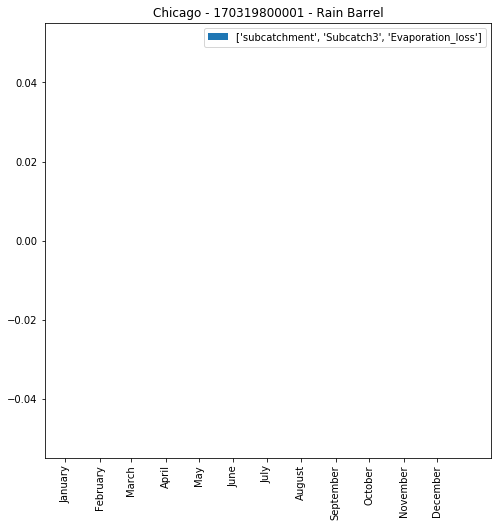

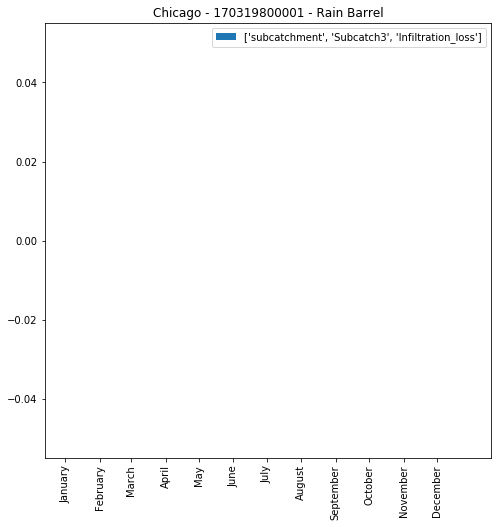

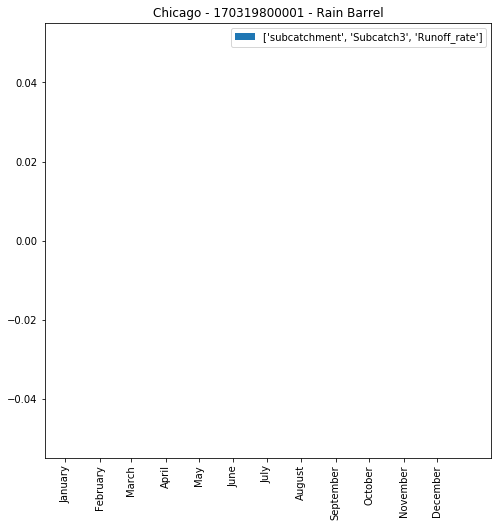

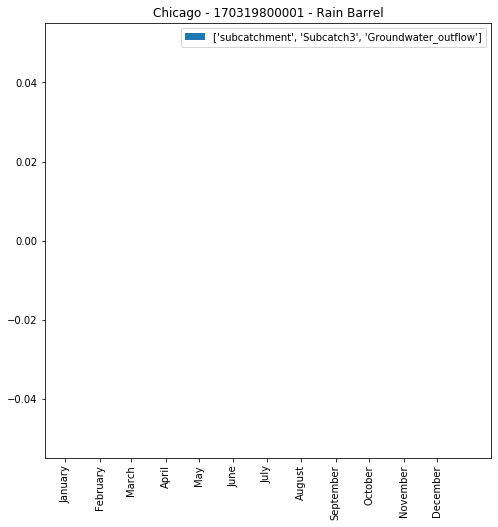

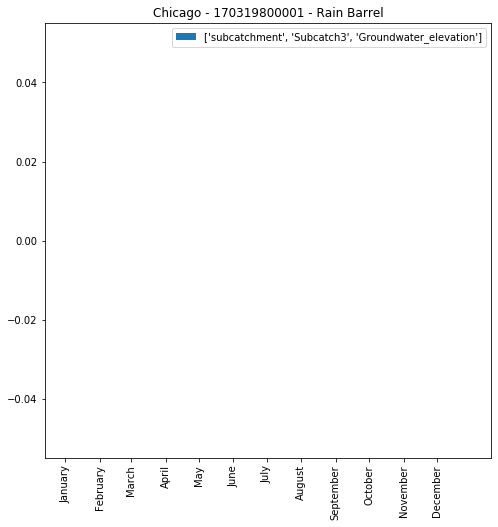

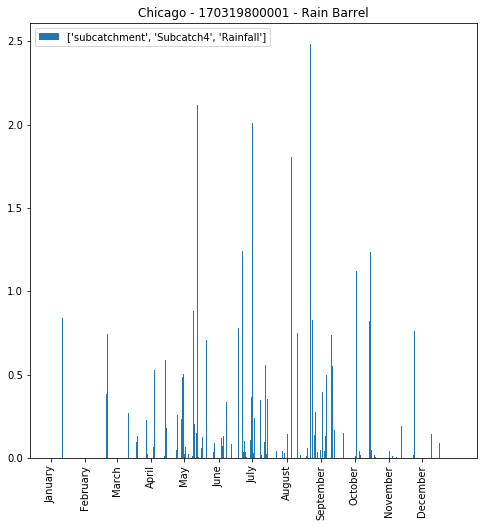

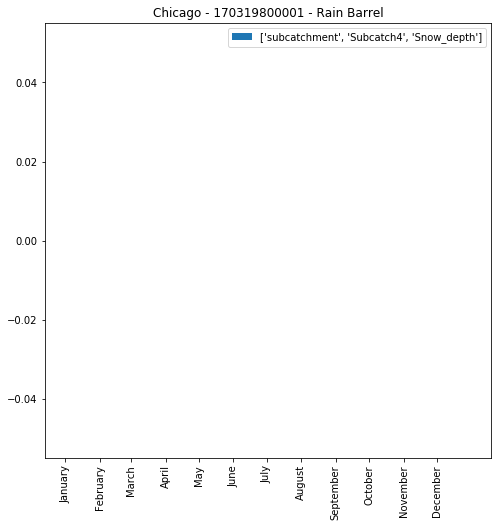

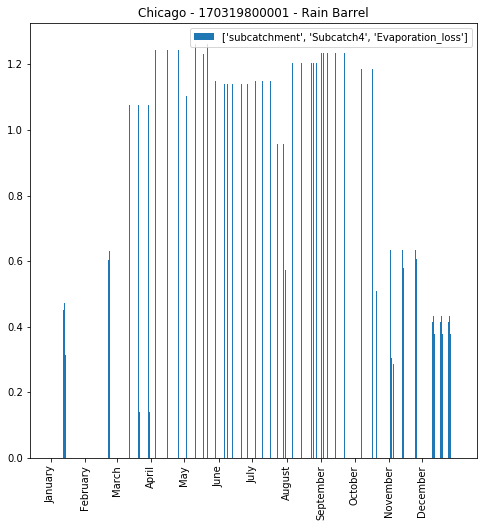

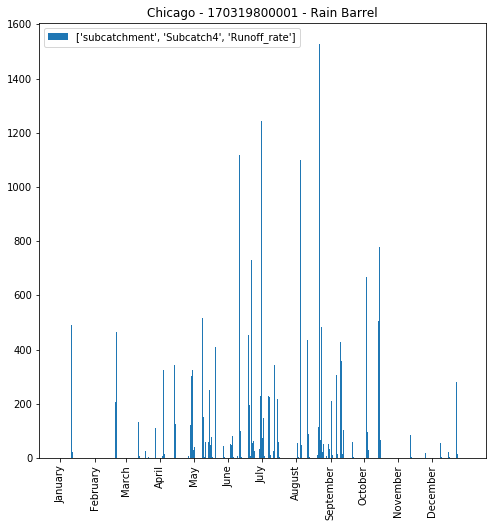

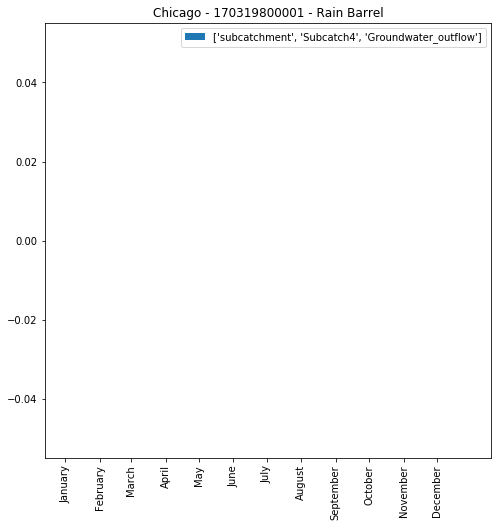

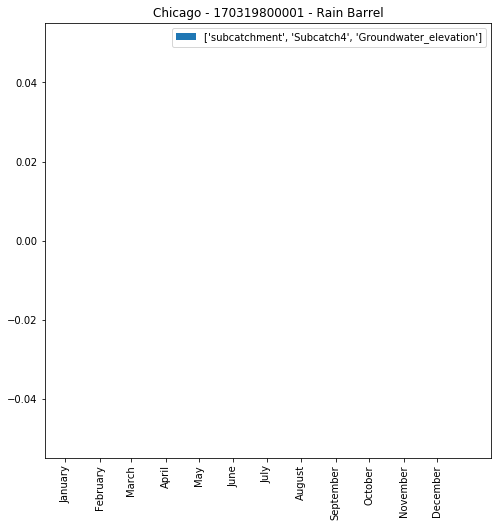

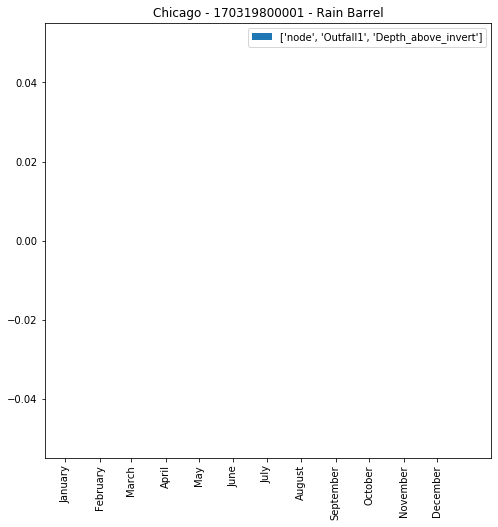

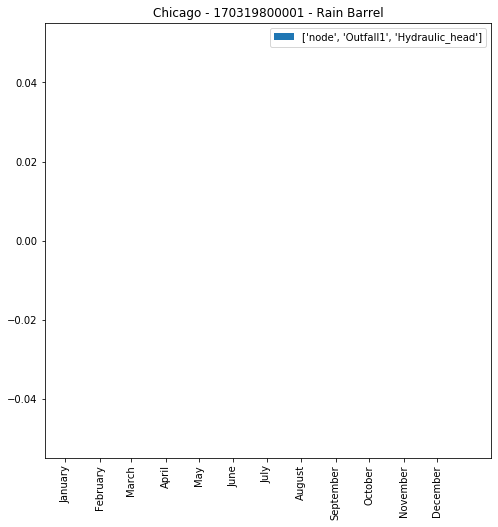

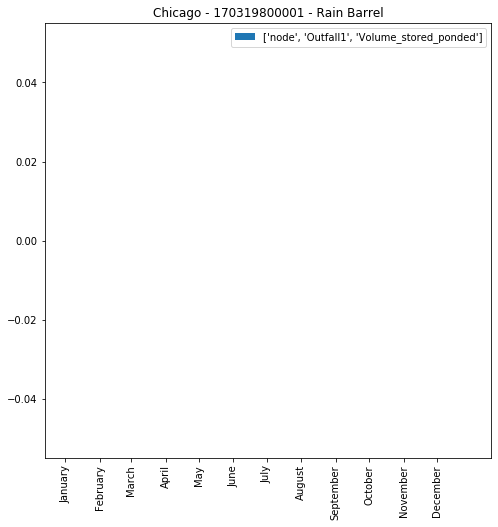

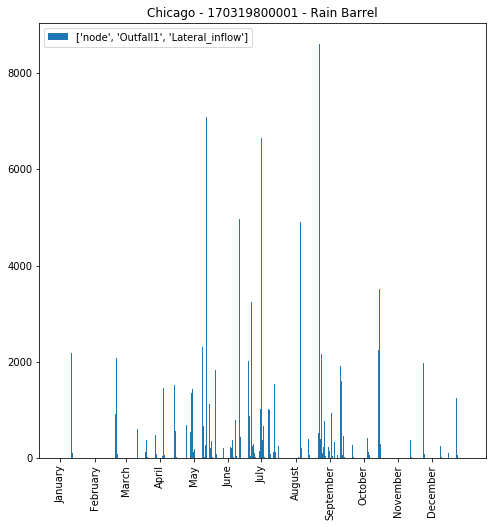

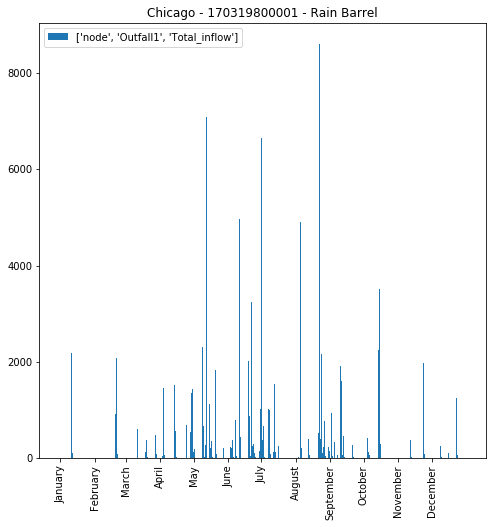

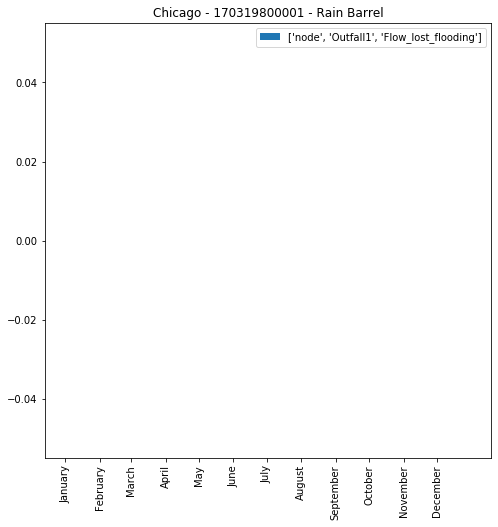

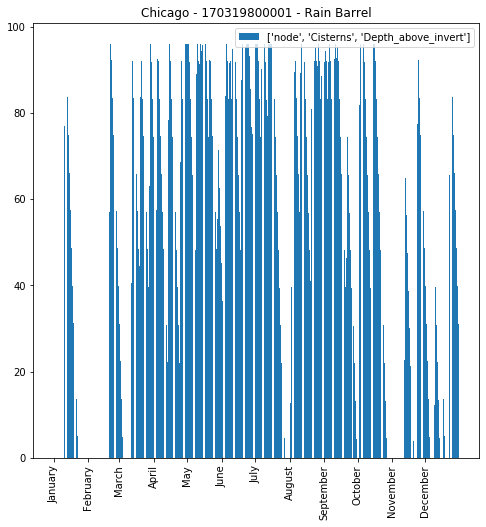

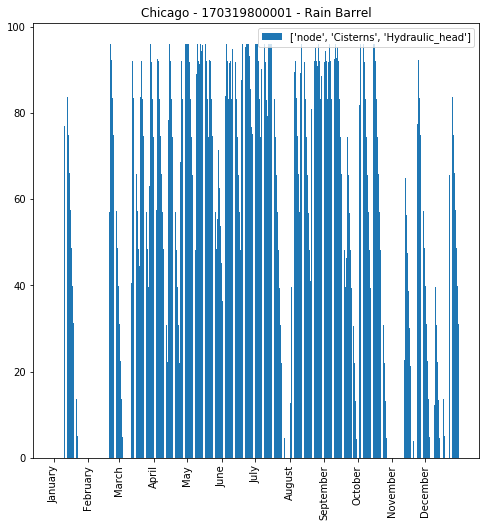

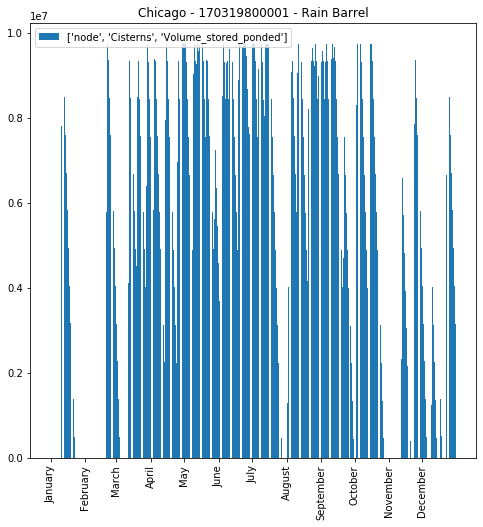

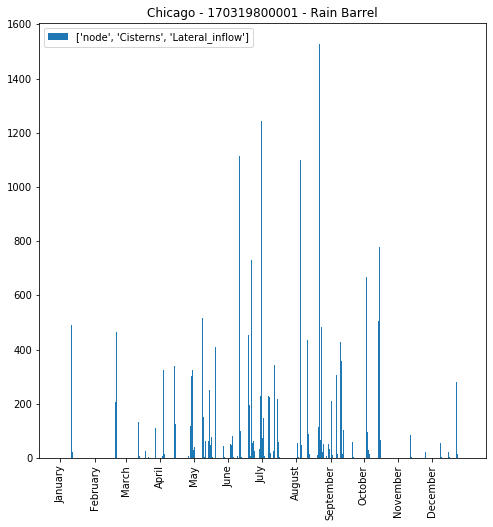

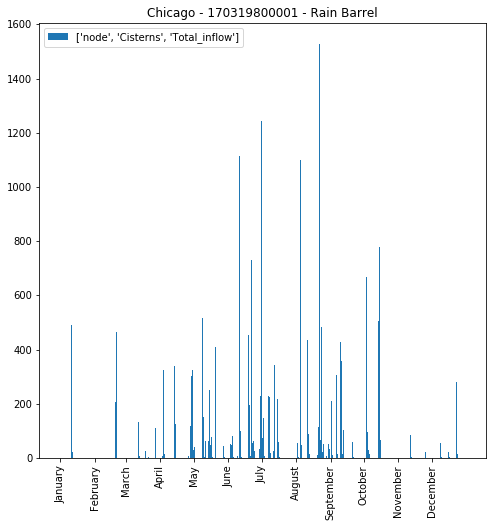

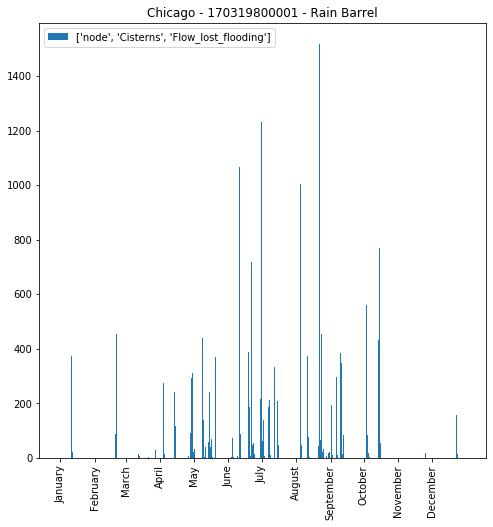

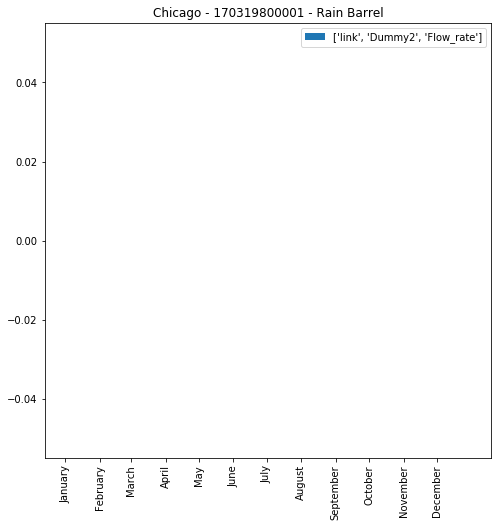

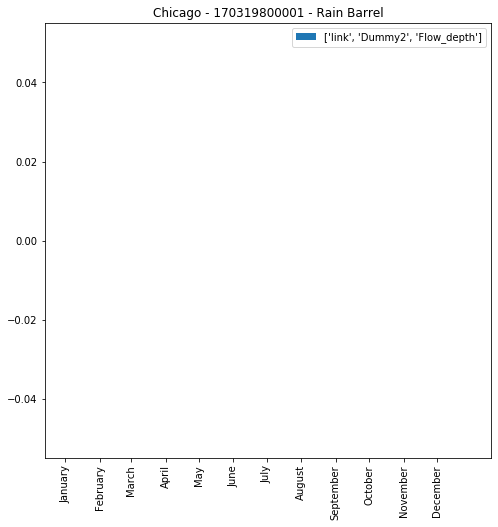

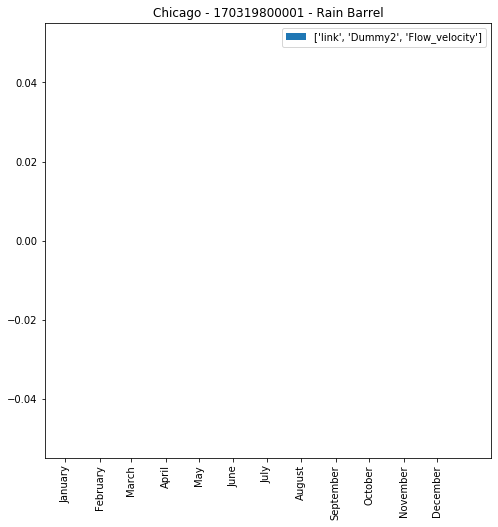

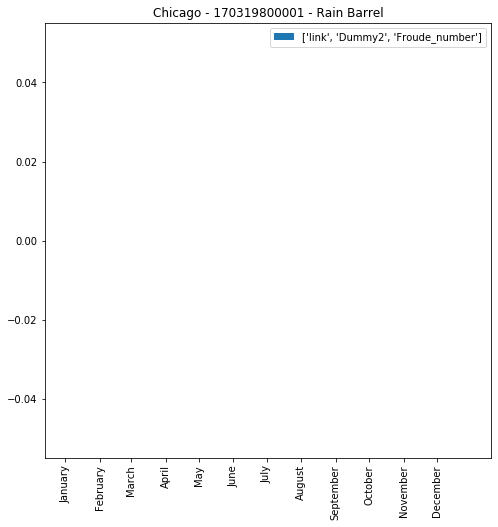

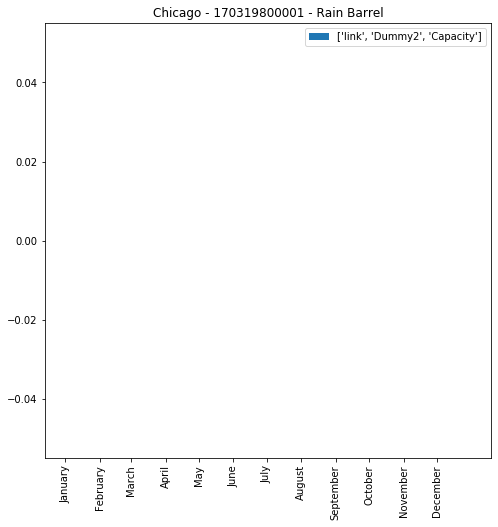

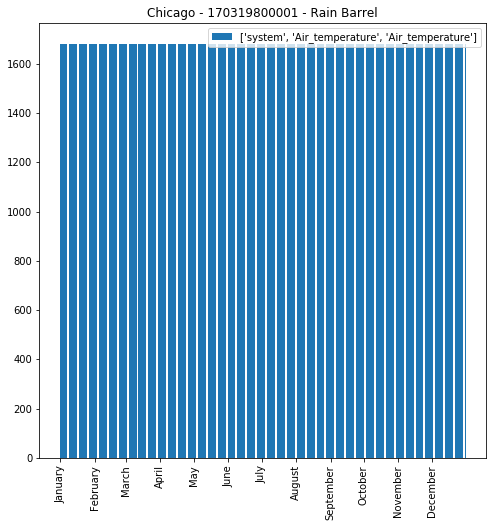

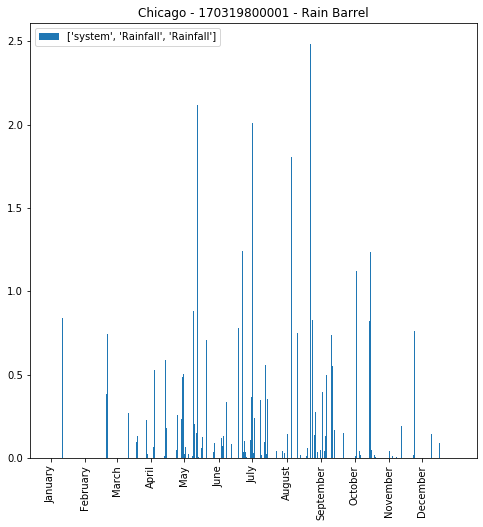

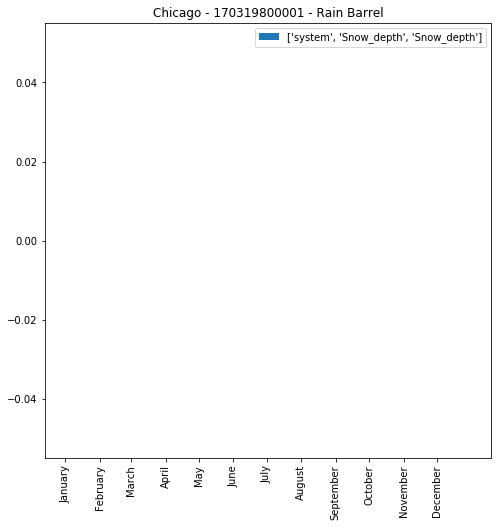

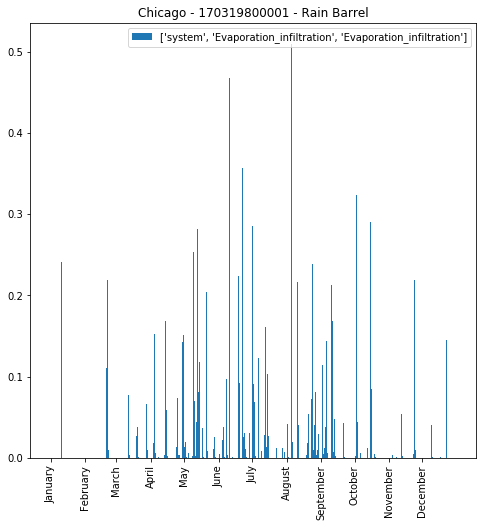

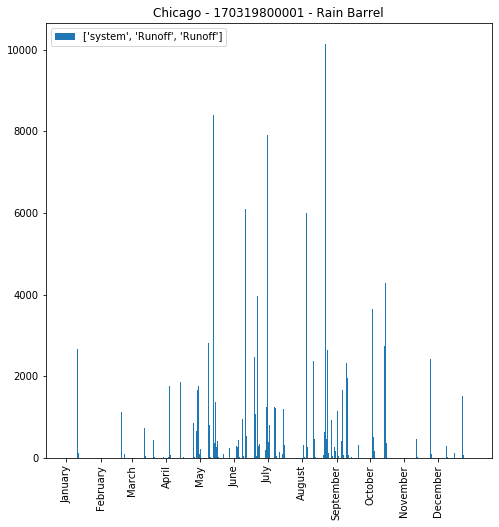

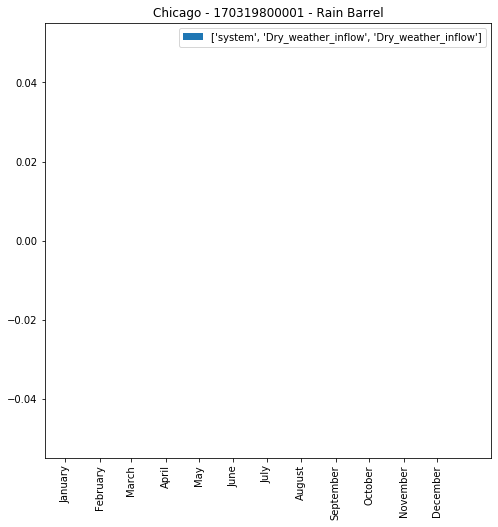

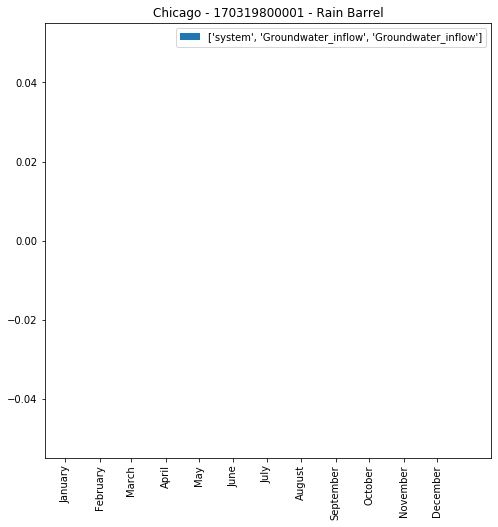

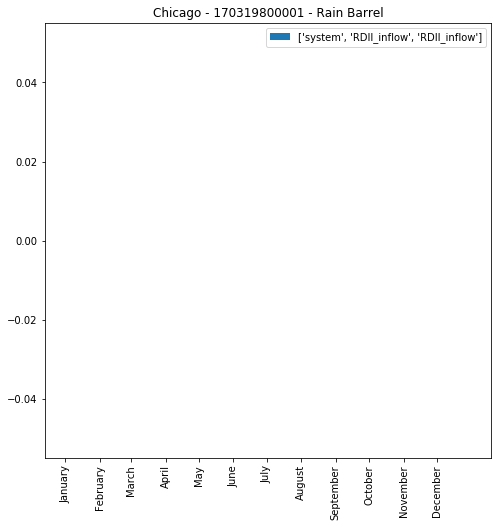

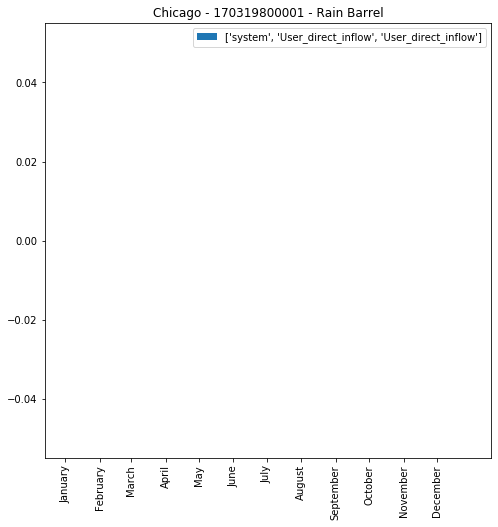

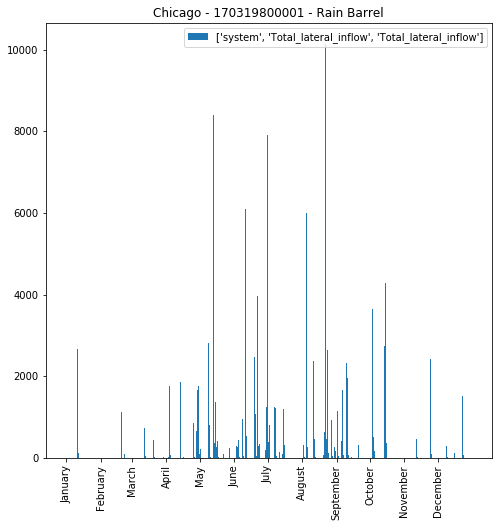

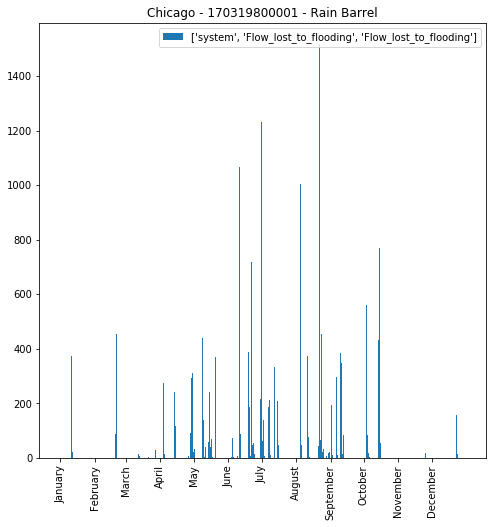

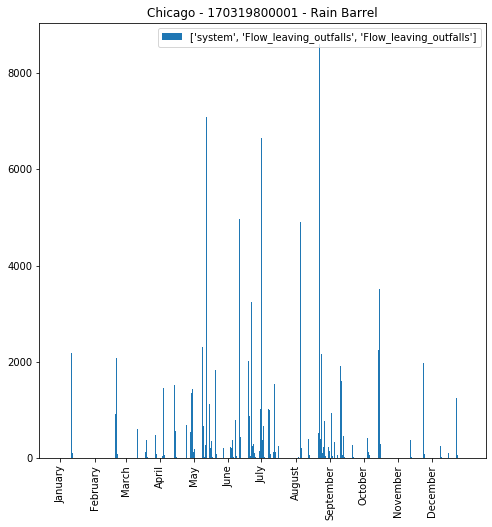

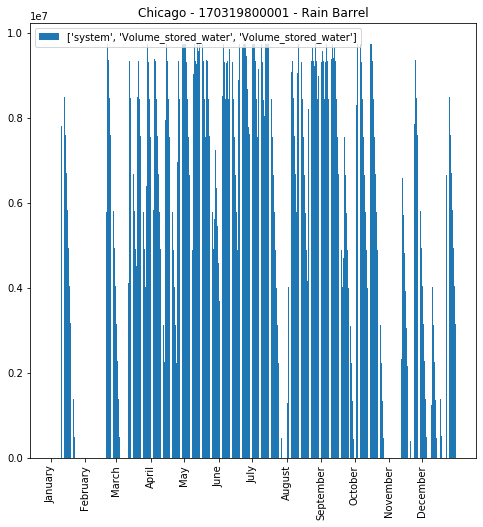

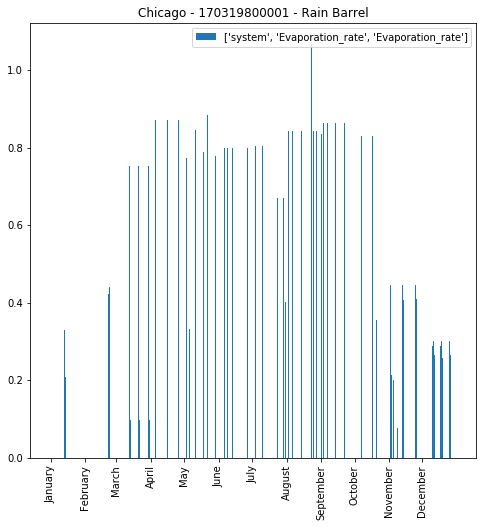

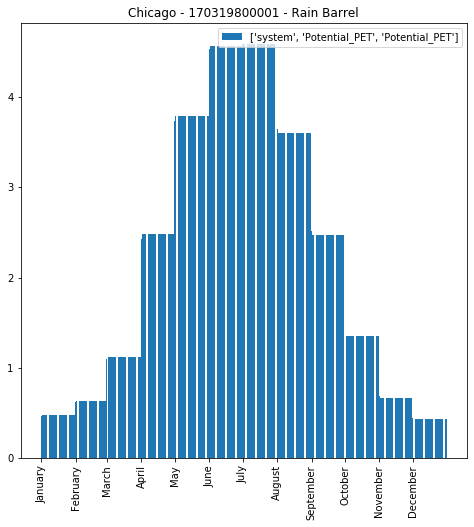

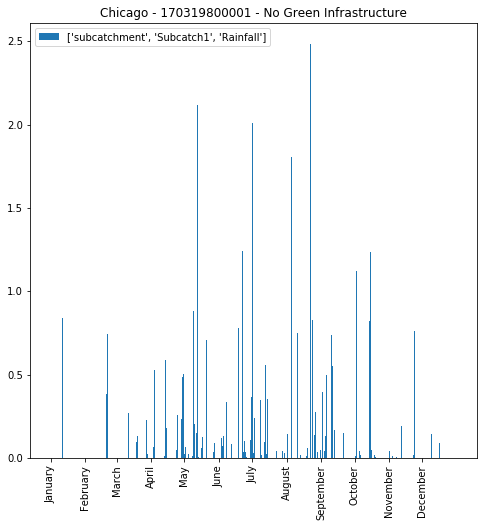

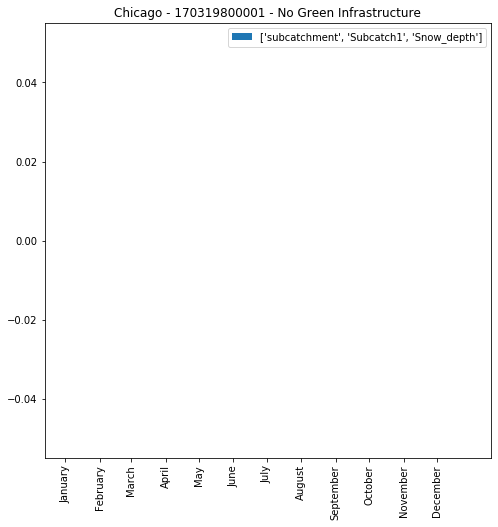

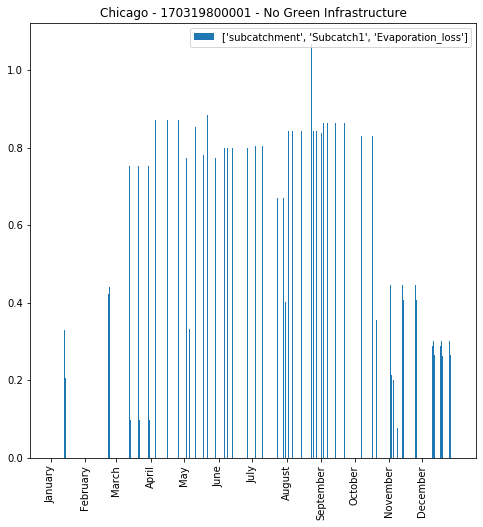

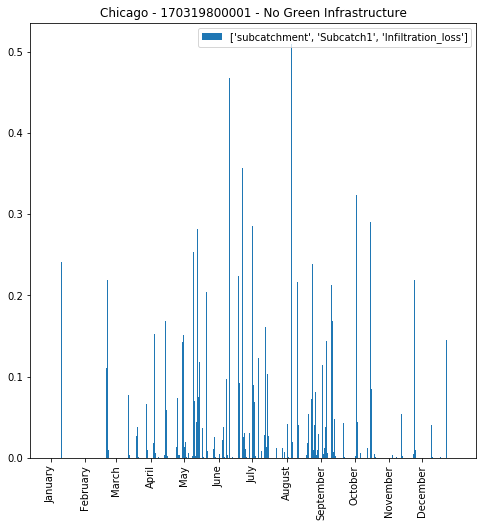

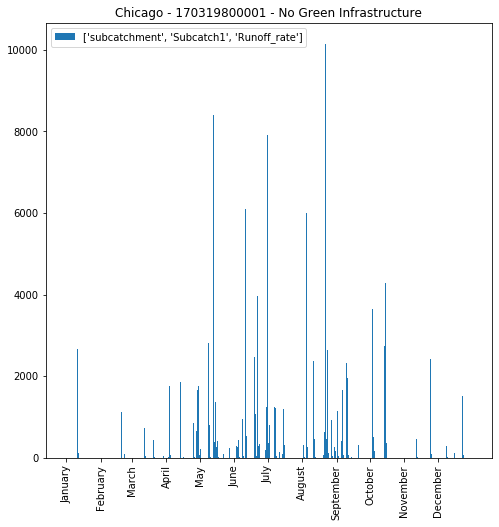

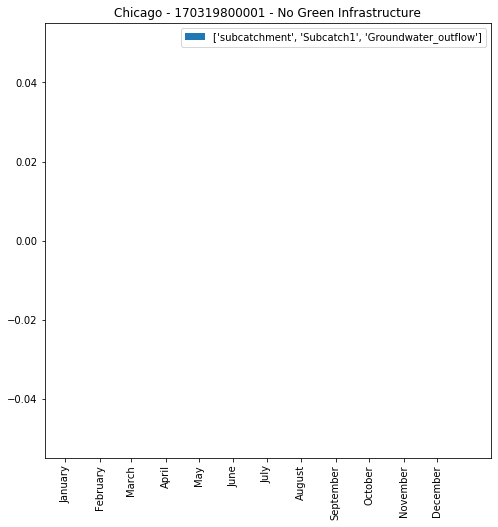

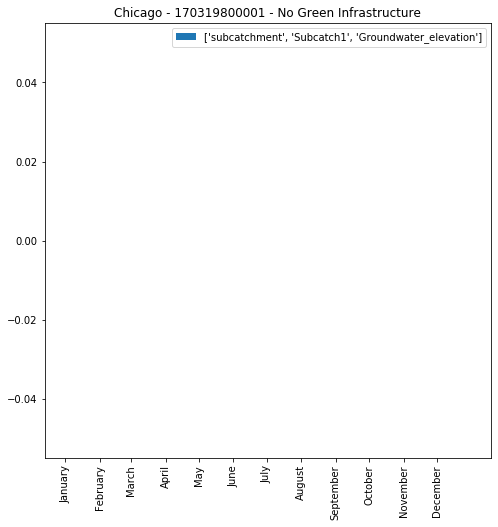

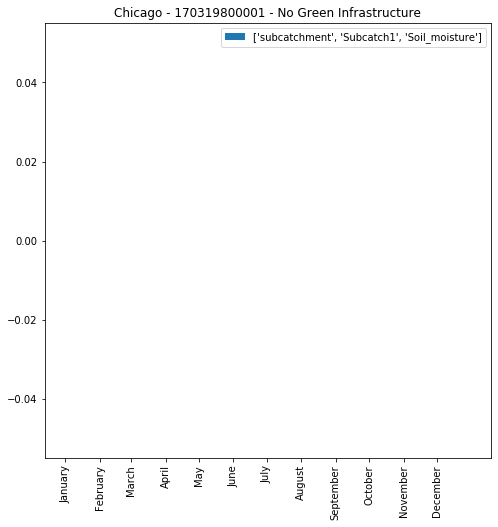

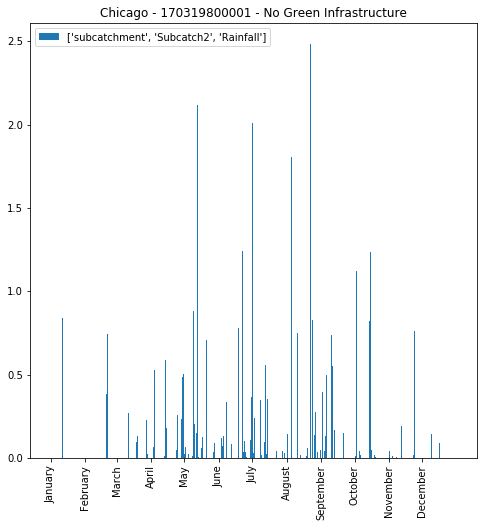

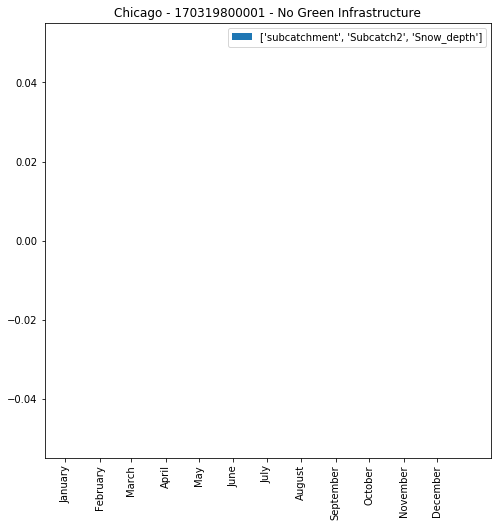

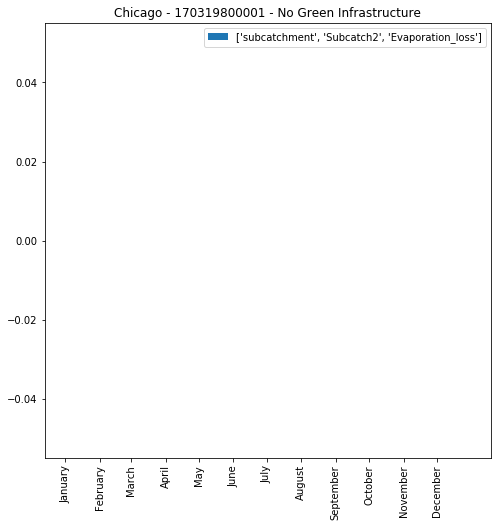

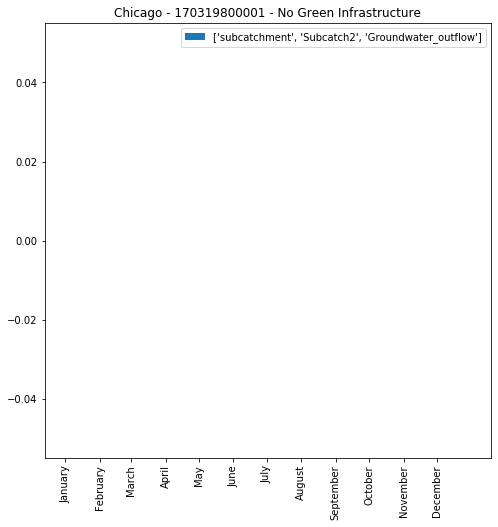

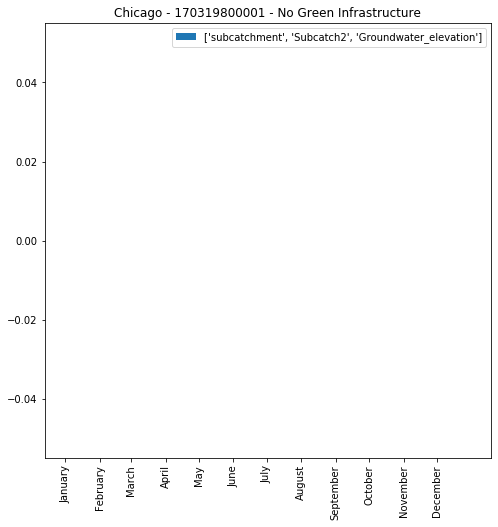

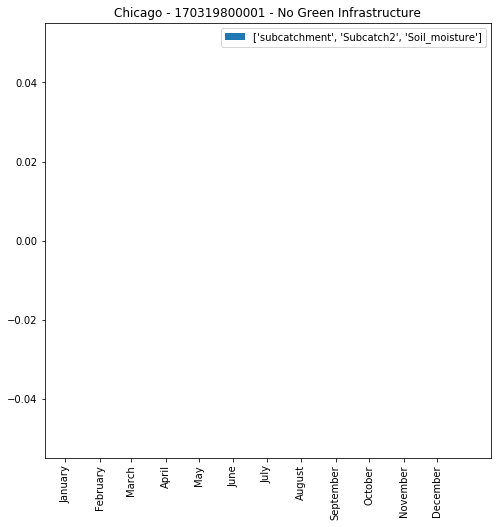

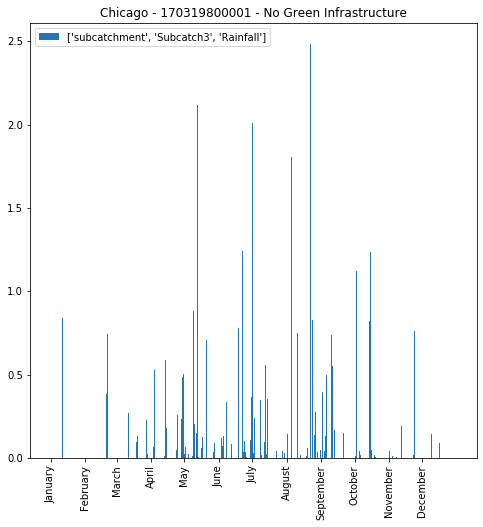

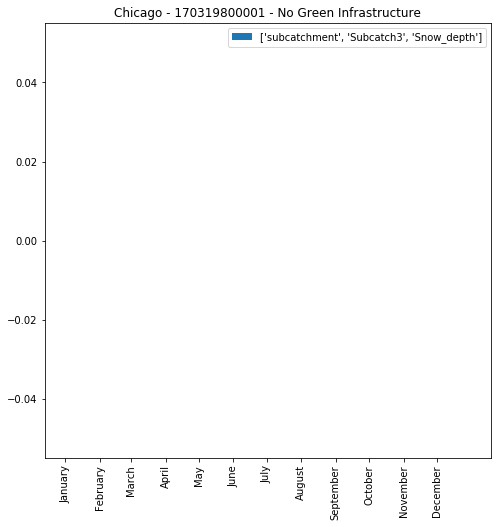

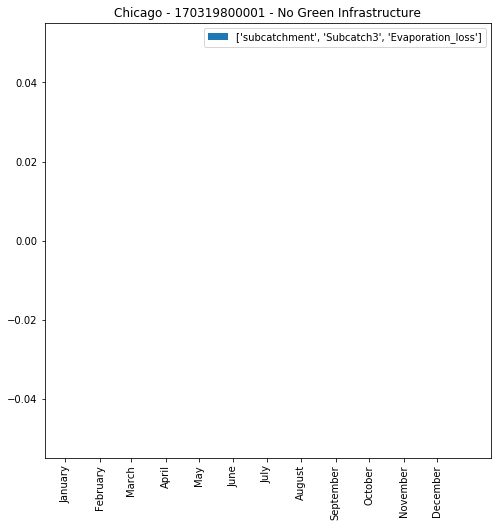

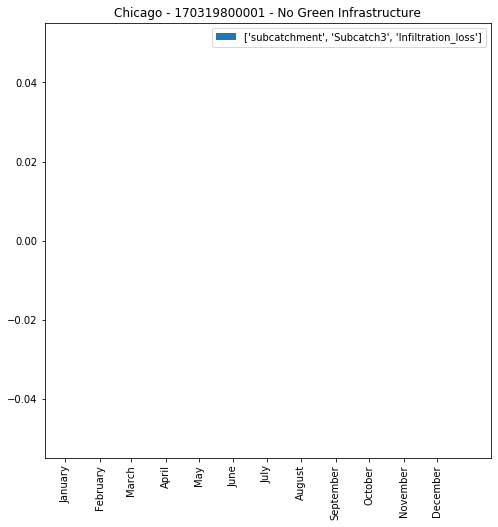

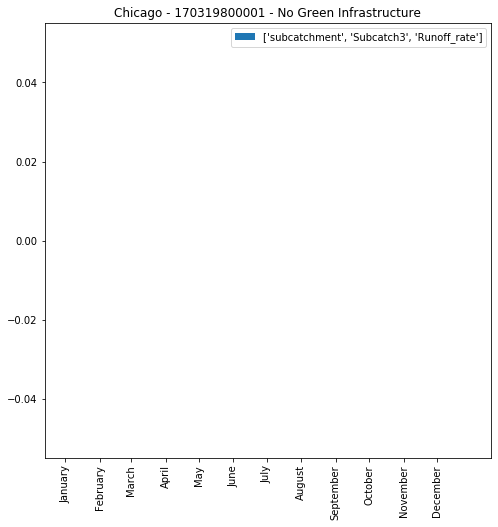

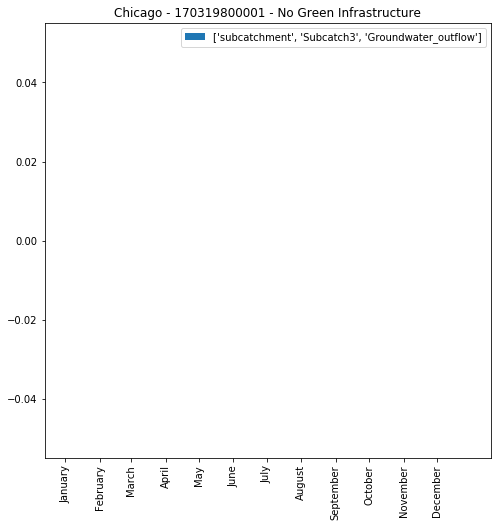

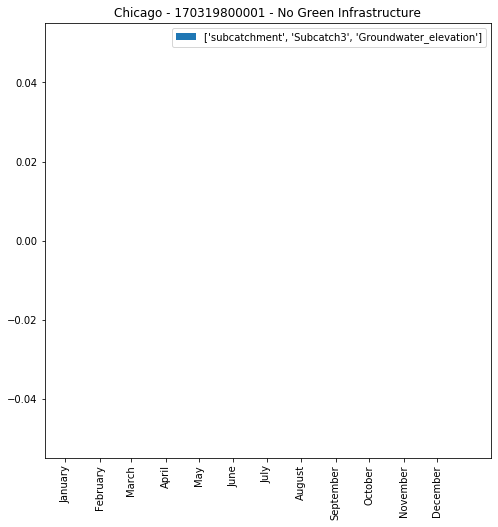

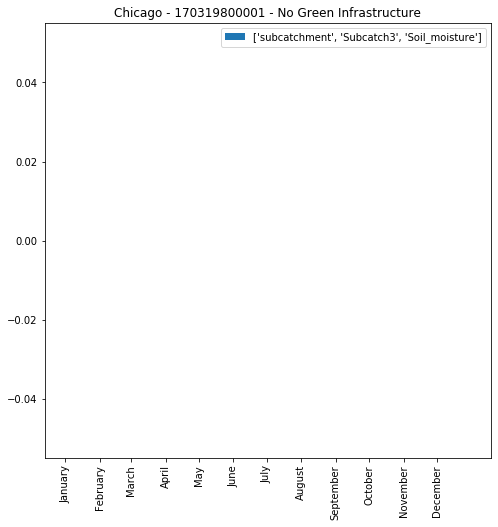

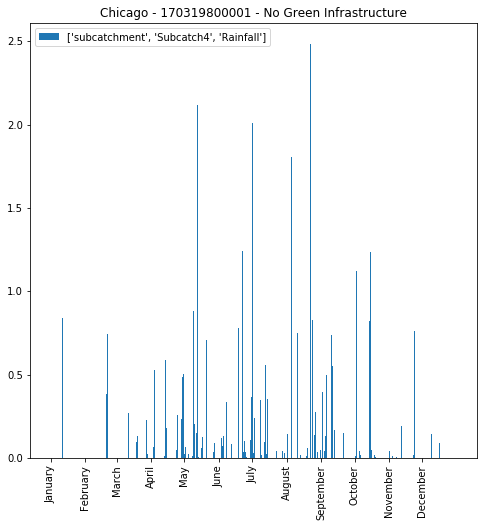

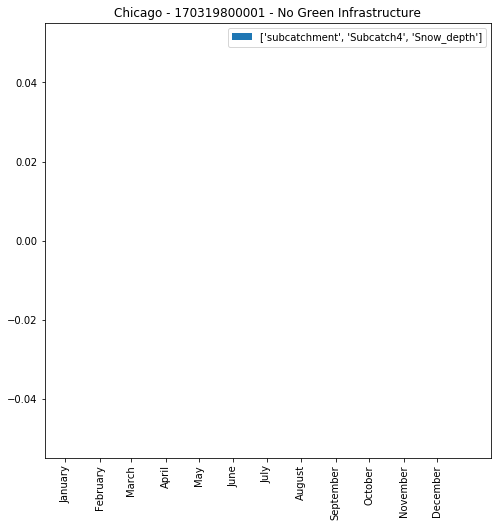

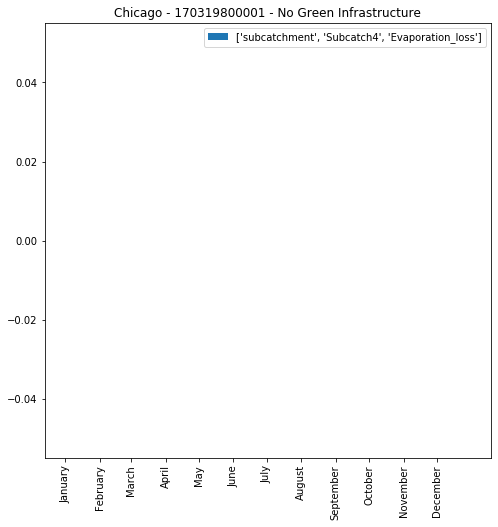

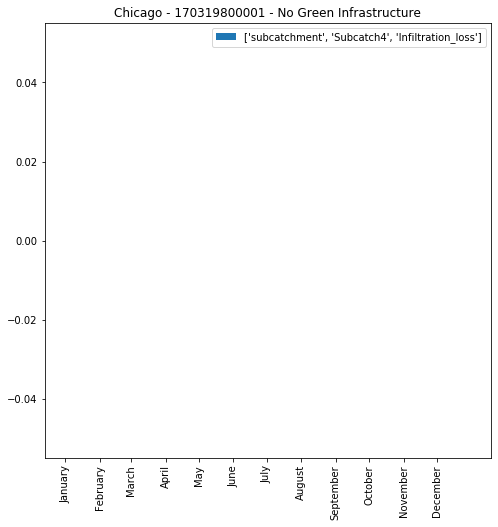

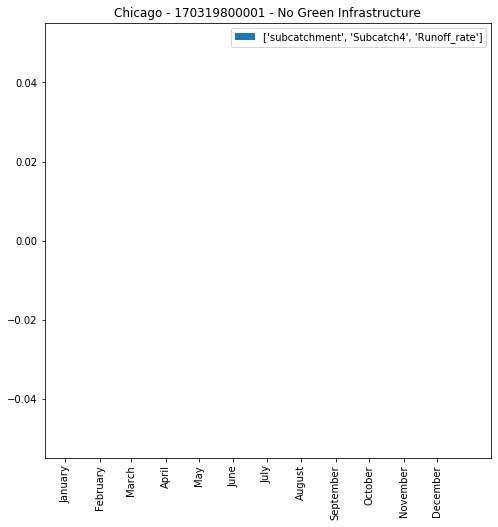

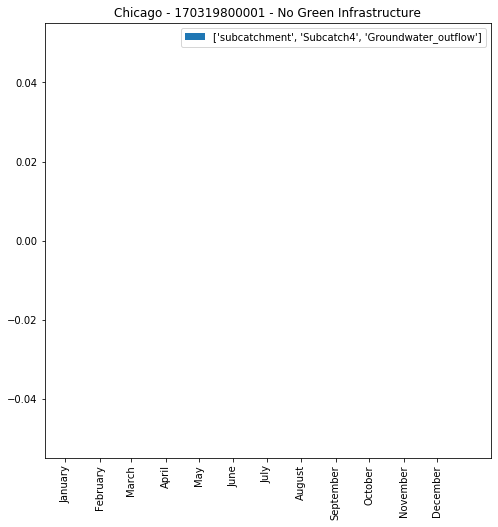

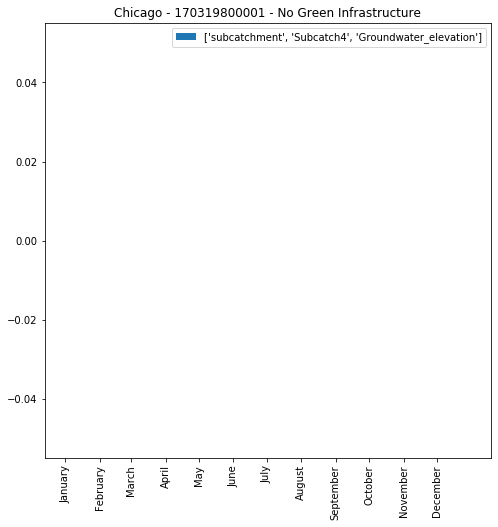

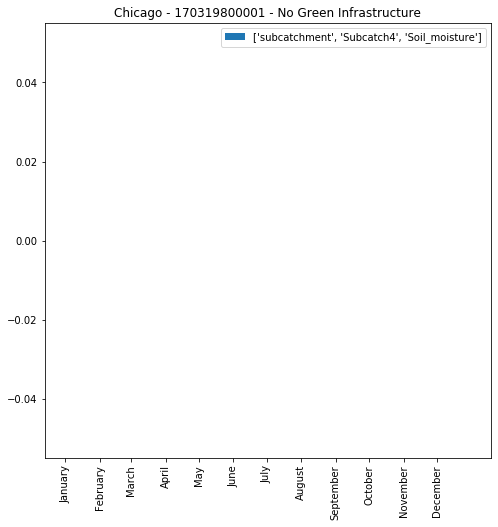

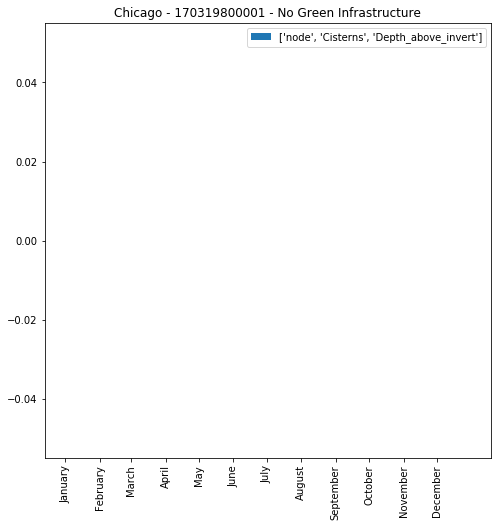

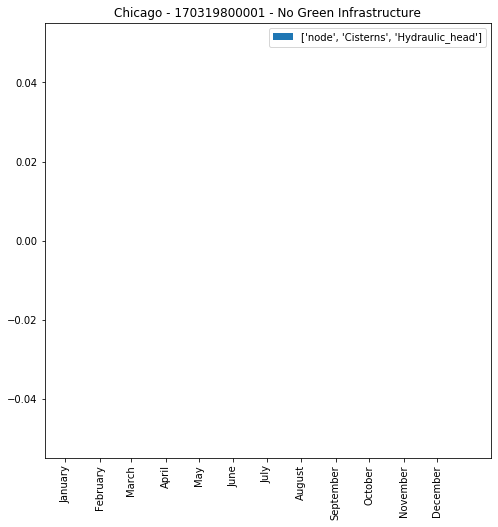

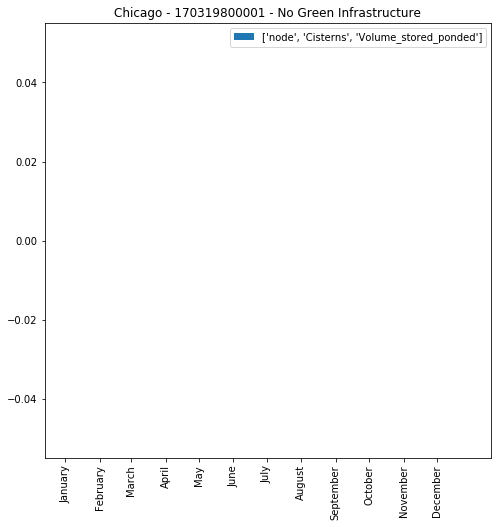

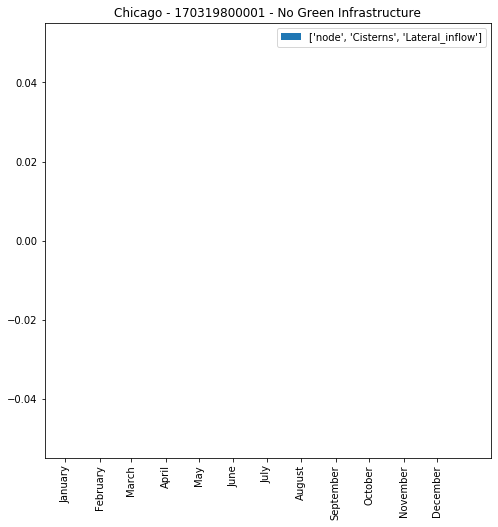

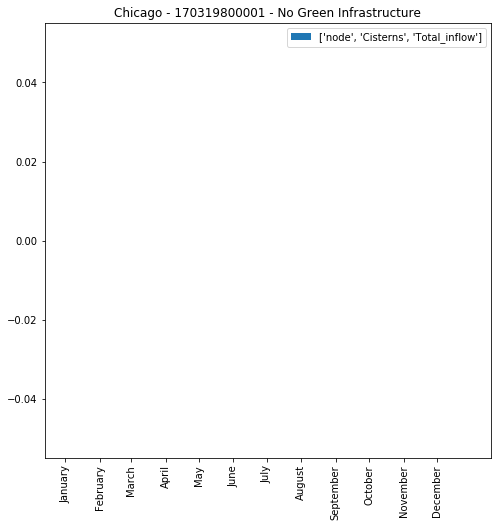

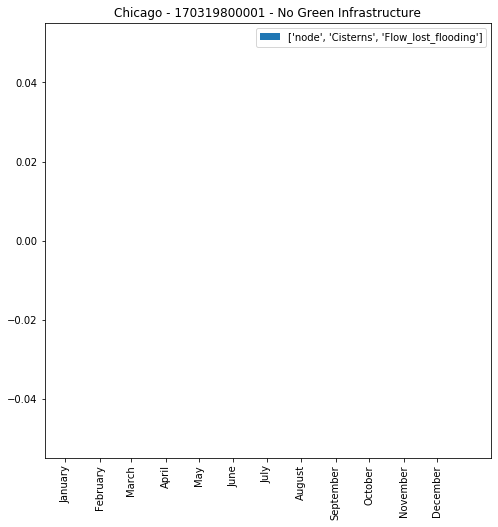

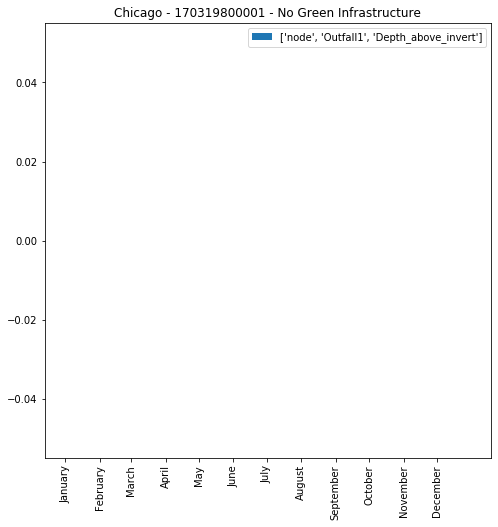

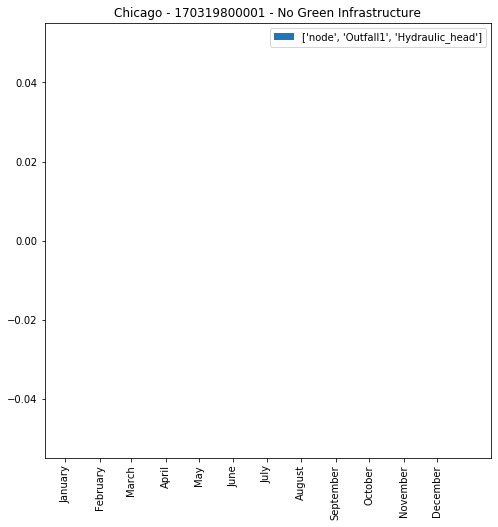

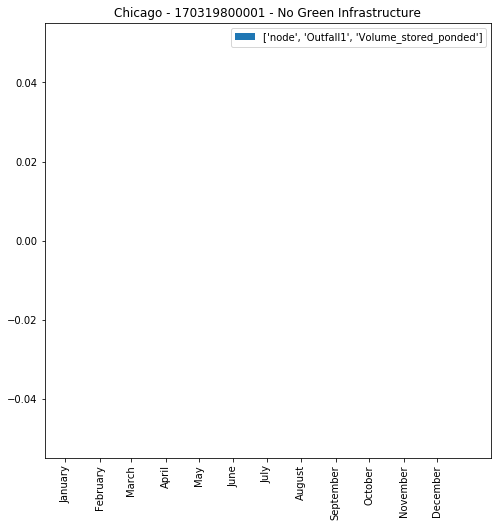

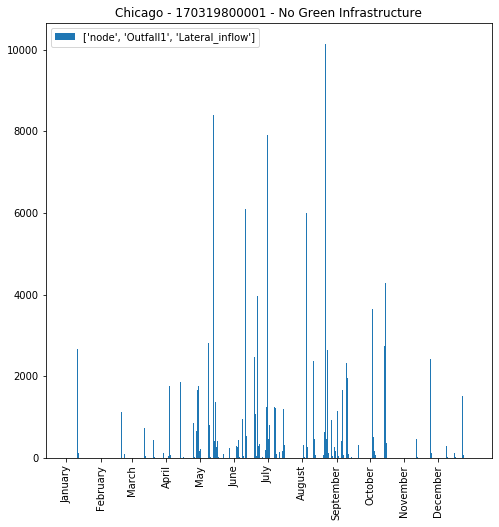

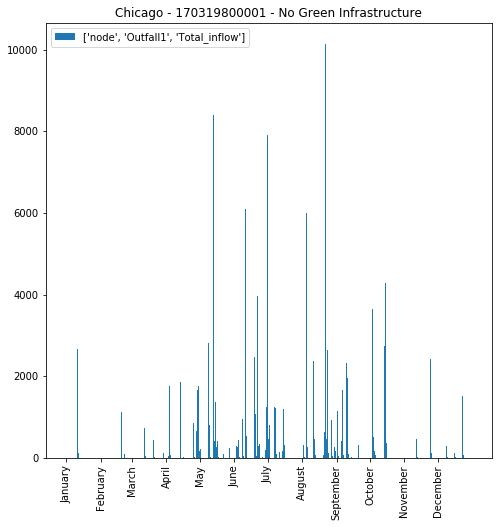

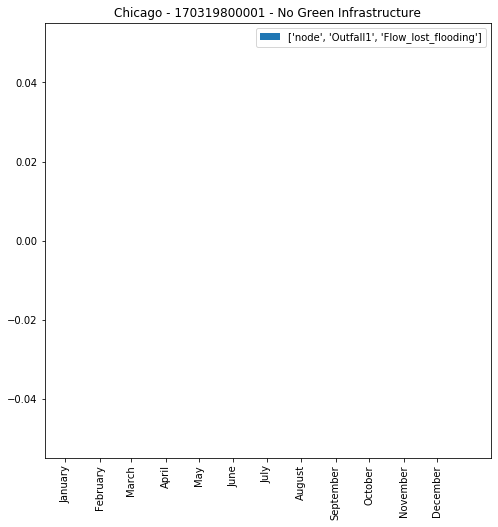

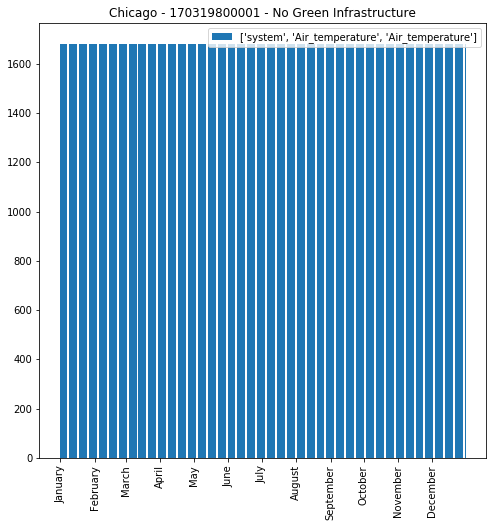

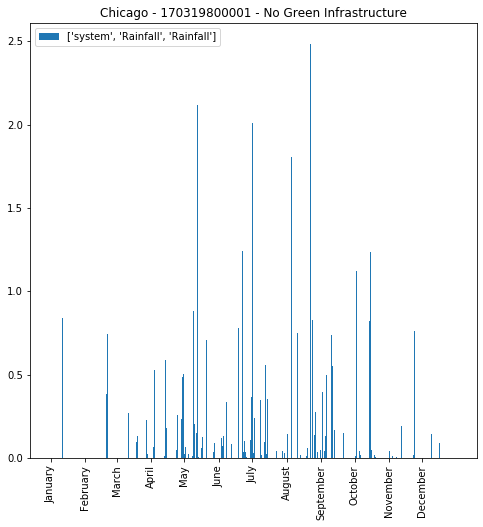

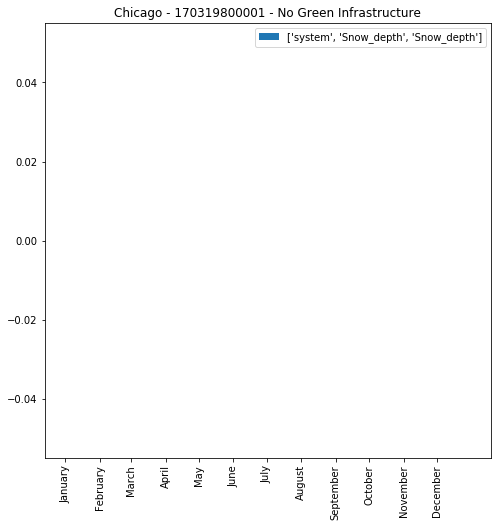

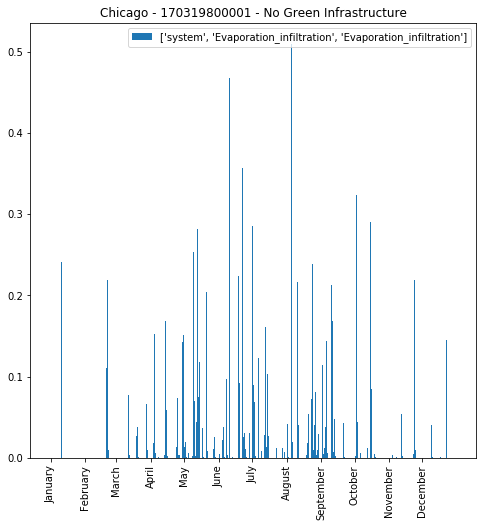

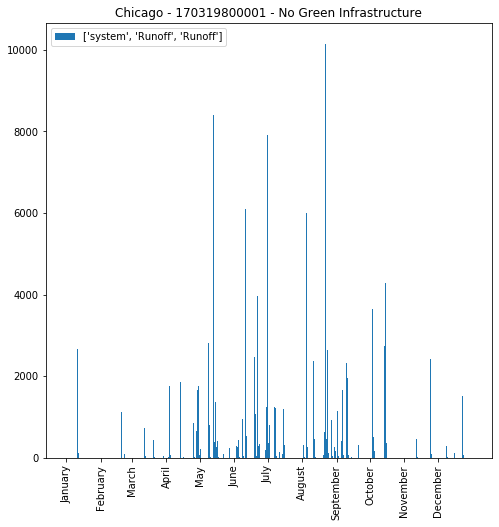

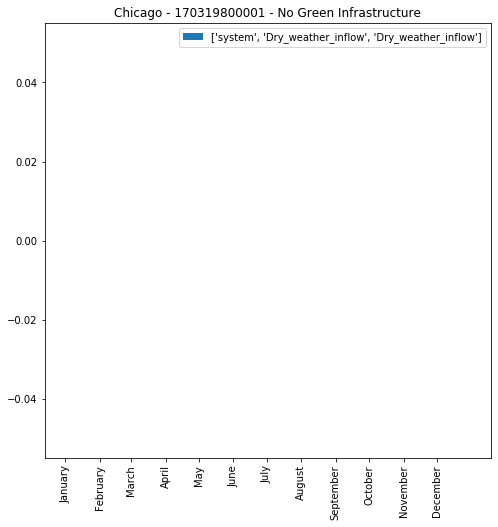

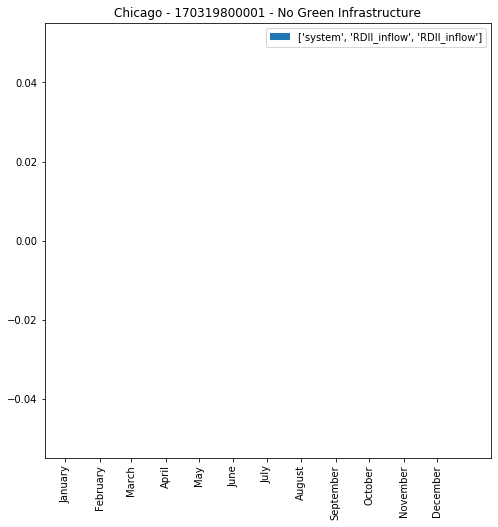

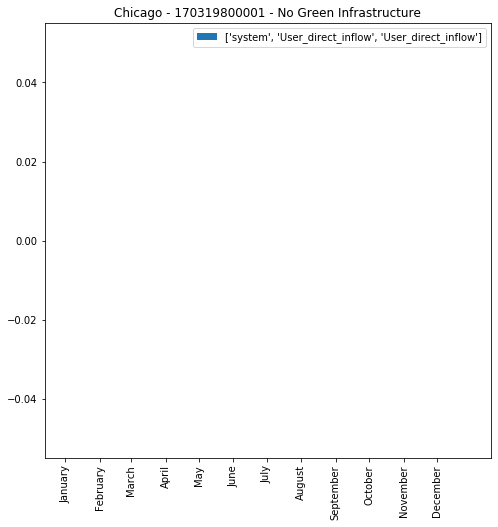

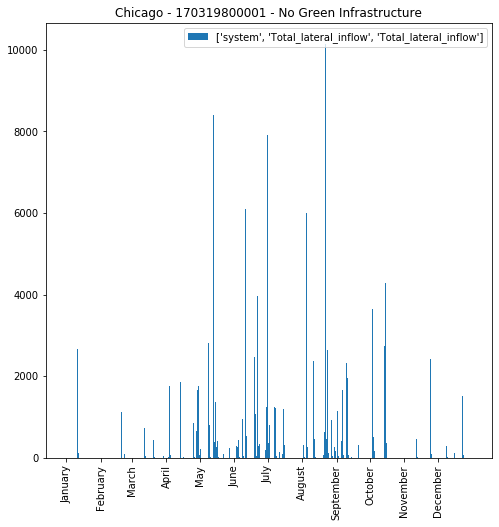

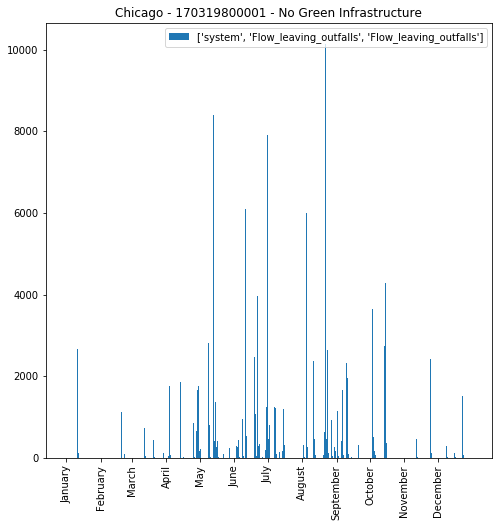

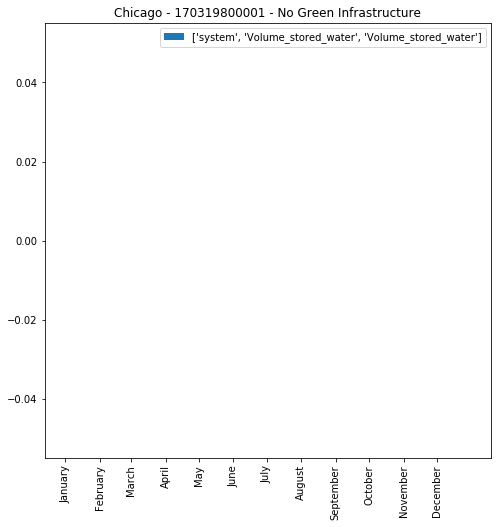

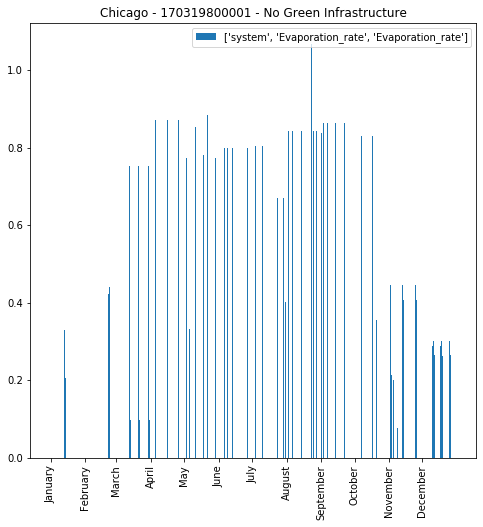

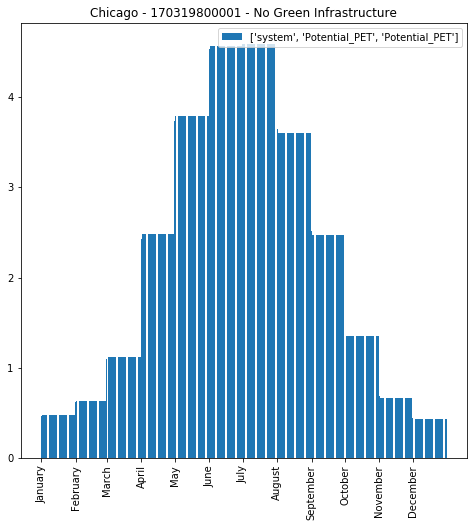

In [49]:
for file in chicago_files:
    gi_type = file[-6:-4]
    print(gi_type)
    
    extract = swmmtoolbox.catalog(file)

    for var in extract:
        print(var)
        system = False
        if var[0] == 'system':
            system = True

        data = swmmtoolbox.extract(file, var).resample('d').sum().iloc[-365:]
        data = data[data.columns[0]]

        plt.figure(figsize=(8,8))
        plt.title('Chicago - 170319800001 - ' + gi_types[gi_type])
        width = 2.5

        plt.bar(date, data.iloc[-365:], label=var)
        plt.xticks([0,31,59,90,120,151,181,212,243,273,304,334], calendar.month_name[1:13], rotation=90)
        plt.legend()

        if system:
            plt.savefig('./chicago/' + gi_type + '/' + var[0] + '/' + var[1] + '.svg', dpi=900)
        else:
            plt.savefig('./chicago/' + gi_type + '/' + var[1] + '/' + var[2] + '.svg', dpi=900)

        
        

## California

ng
['subcatchment', 'Subcatch1', 'Rainfall']
['subcatchment', 'Subcatch1', 'Snow_depth']
['subcatchment', 'Subcatch1', 'Evaporation_loss']
['subcatchment', 'Subcatch1', 'Infiltration_loss']
['subcatchment', 'Subcatch1', 'Runoff_rate']
['subcatchment', 'Subcatch1', 'Groundwater_outflow']
['subcatchment', 'Subcatch1', 'Groundwater_elevation']
['subcatchment', 'Subcatch1', 'Soil_moisture']
['subcatchment', 'Subcatch2', 'Rainfall']
['subcatchment', 'Subcatch2', 'Snow_depth']
['subcatchment', 'Subcatch2', 'Evaporation_loss']
['subcatchment', 'Subcatch2', 'Infiltration_loss']
['subcatchment', 'Subcatch2', 'Runoff_rate']
['subcatchment', 'Subcatch2', 'Groundwater_outflow']
['subcatchment', 'Subcatch2', 'Groundwater_elevation']
['subcatchment', 'Subcatch2', 'Soil_moisture']
['subcatchment', 'Subcatch3', 'Rainfall']
['subcatchment', 'Subcatch3', 'Snow_depth']
['subcatchment', 'Subcatch3', 'Evaporation_loss']
['subcatchment', 'Subcatch3', 'Infiltration_loss']
['subcatchment', 'Subcatch3', 'Runof

/home/matas/anaconda3/envs/swmm/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


['subcatchment', 'Subcatch3', 'Groundwater_outflow']
['subcatchment', 'Subcatch3', 'Groundwater_elevation']
['subcatchment', 'Subcatch3', 'Soil_moisture']
['subcatchment', 'Subcatch4', 'Rainfall']
['subcatchment', 'Subcatch4', 'Snow_depth']
['subcatchment', 'Subcatch4', 'Evaporation_loss']
['subcatchment', 'Subcatch4', 'Infiltration_loss']
['subcatchment', 'Subcatch4', 'Runoff_rate']
['subcatchment', 'Subcatch4', 'Groundwater_outflow']
['subcatchment', 'Subcatch4', 'Groundwater_elevation']
['subcatchment', 'Subcatch4', 'Soil_moisture']
['node', 'Cisterns', 'Depth_above_invert']
['node', 'Cisterns', 'Hydraulic_head']
['node', 'Cisterns', 'Volume_stored_ponded']
['node', 'Cisterns', 'Lateral_inflow']
['node', 'Cisterns', 'Total_inflow']
['node', 'Cisterns', 'Flow_lost_flooding']
['node', 'Outfall1', 'Depth_above_invert']
['node', 'Outfall1', 'Hydraulic_head']
['node', 'Outfall1', 'Volume_stored_ponded']
['node', 'Outfall1', 'Lateral_inflow']
['node', 'Outfall1', 'Total_inflow']
['node', 

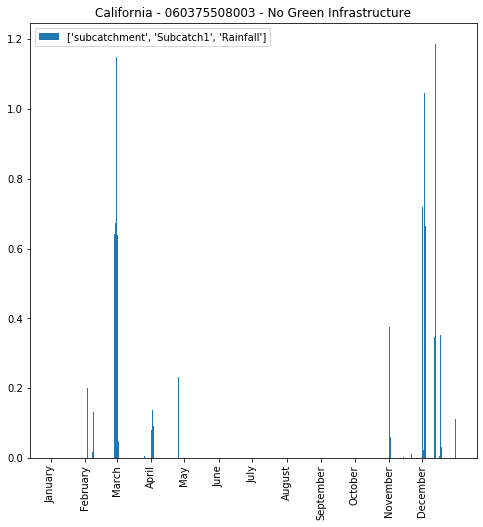

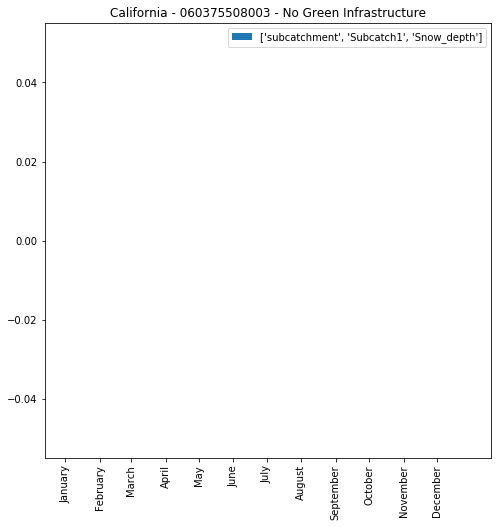

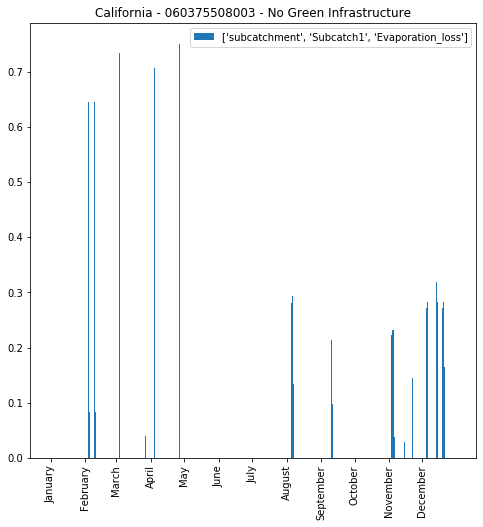

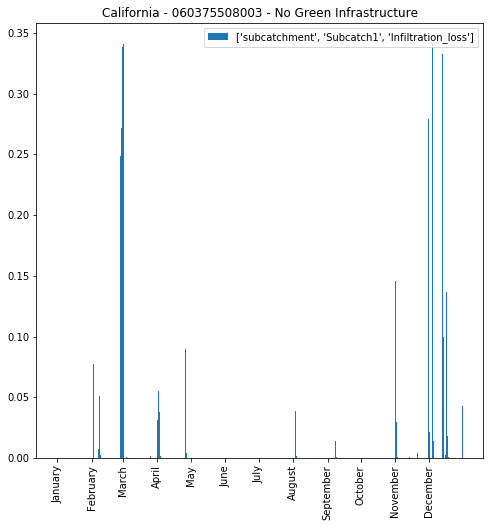

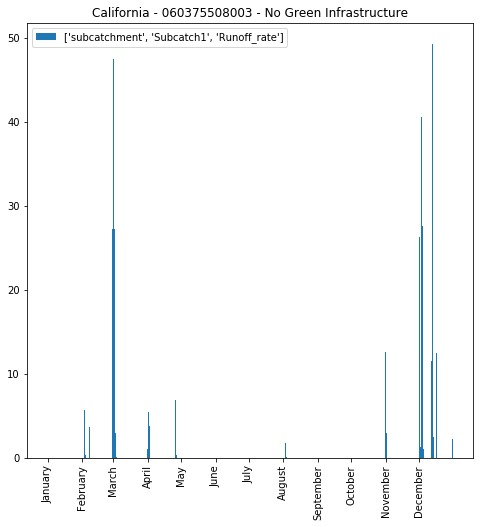

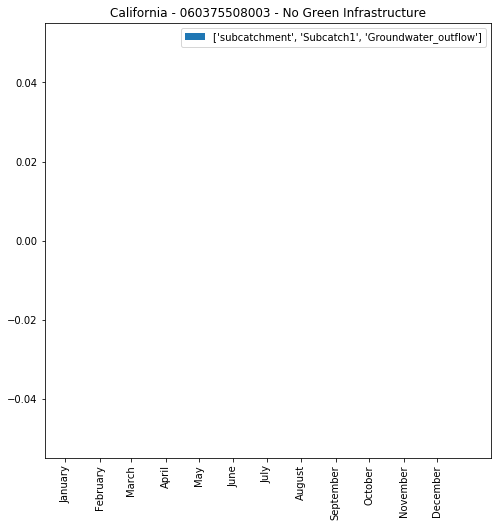

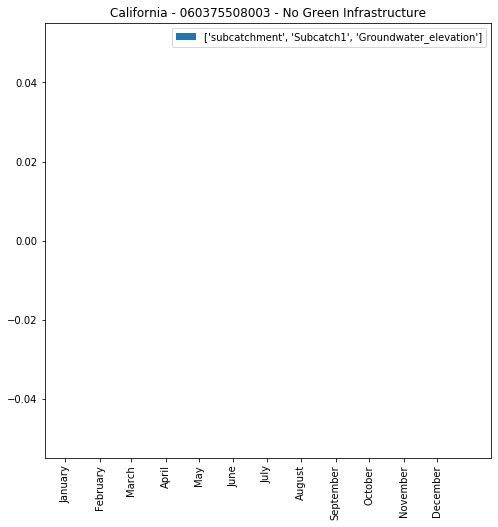

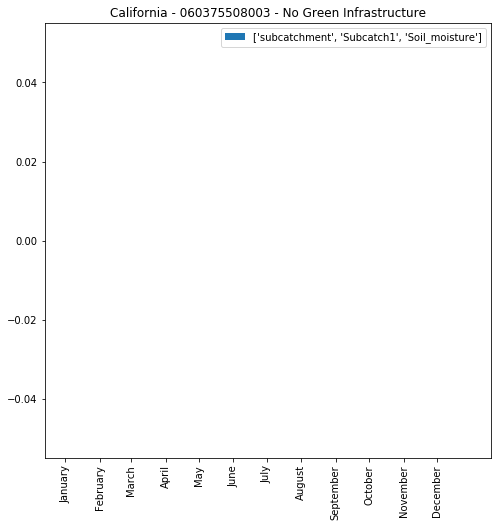

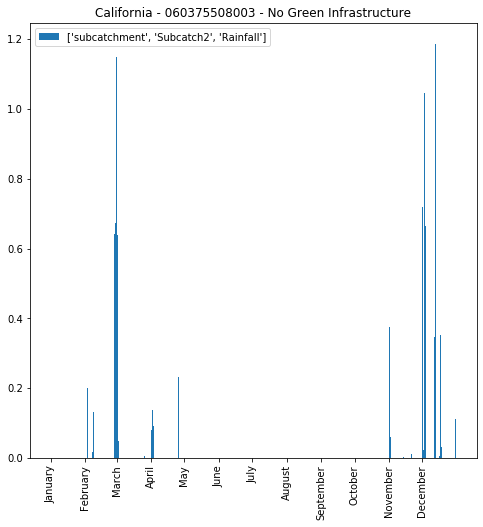

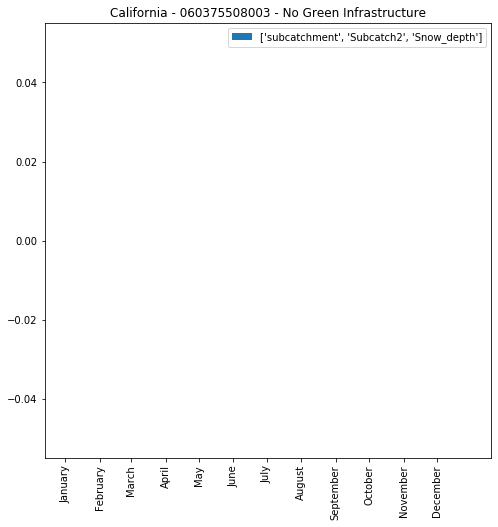

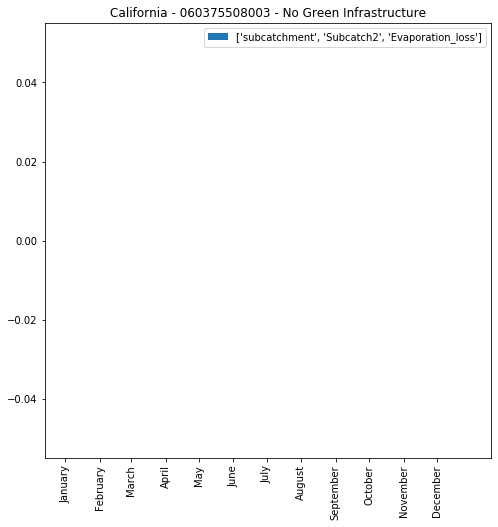

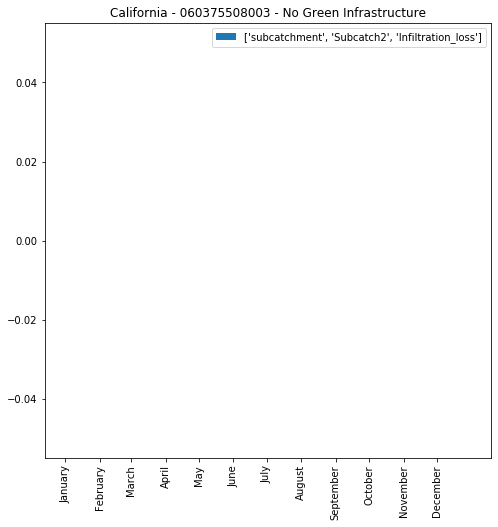

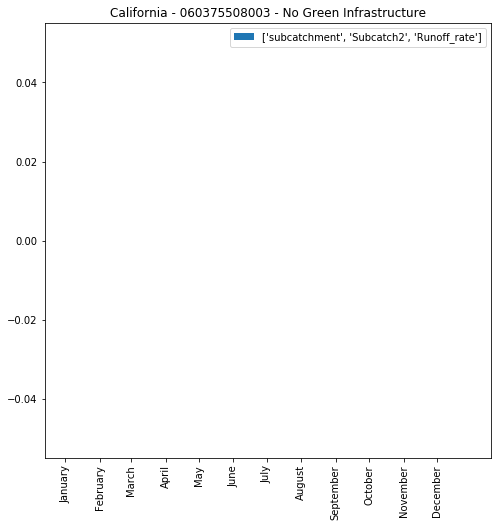

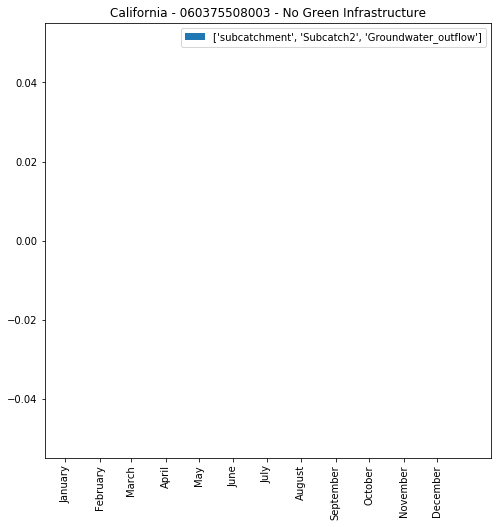

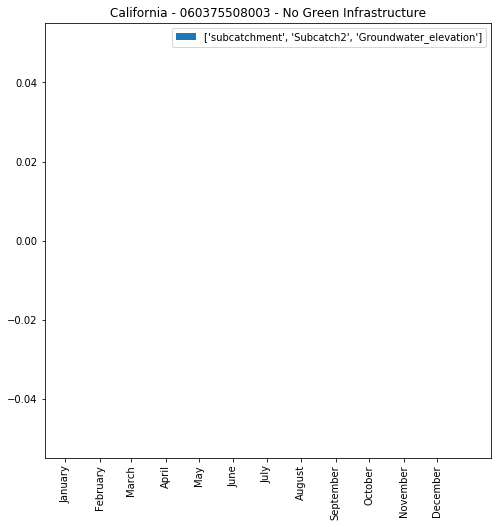

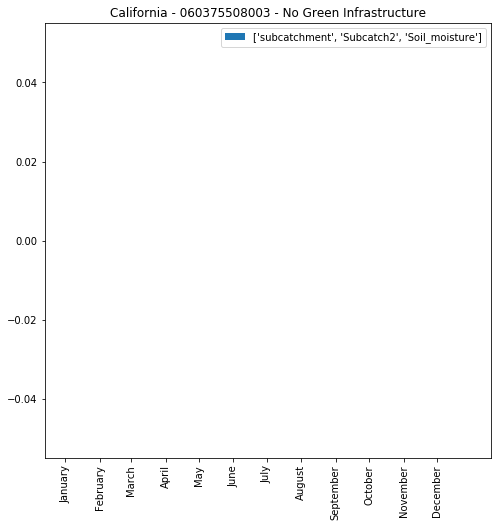

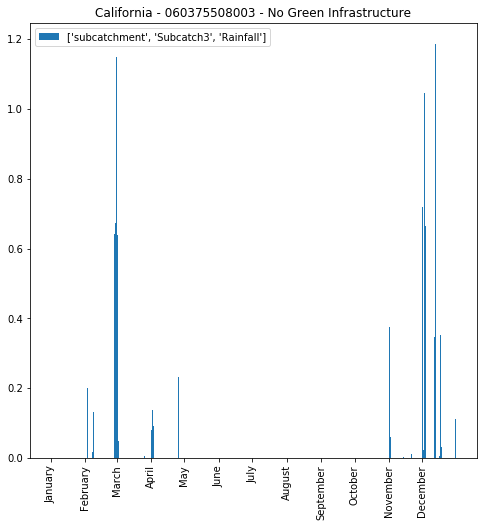

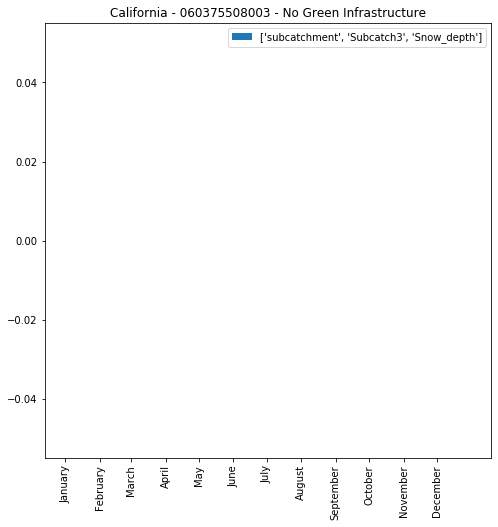

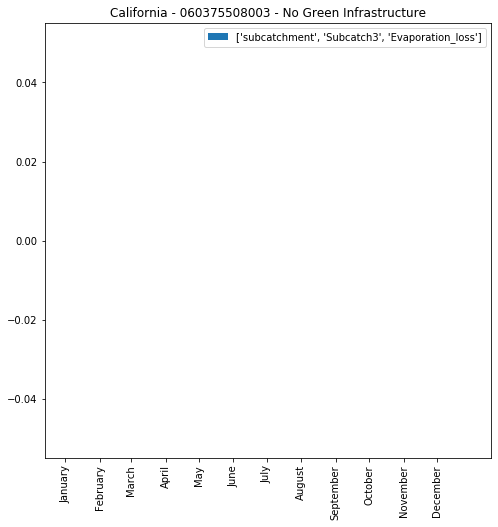

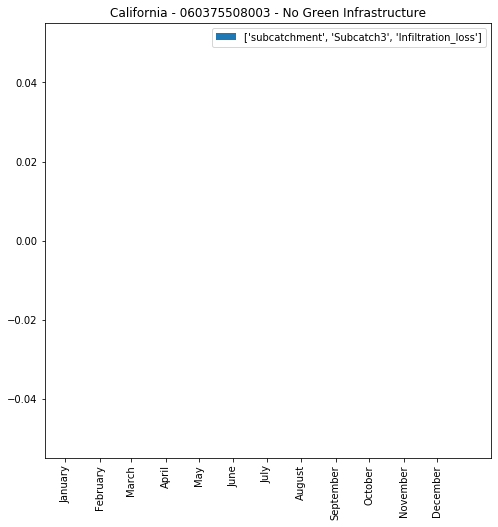

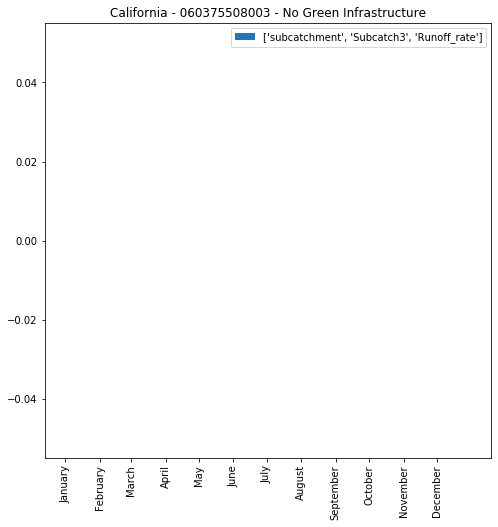

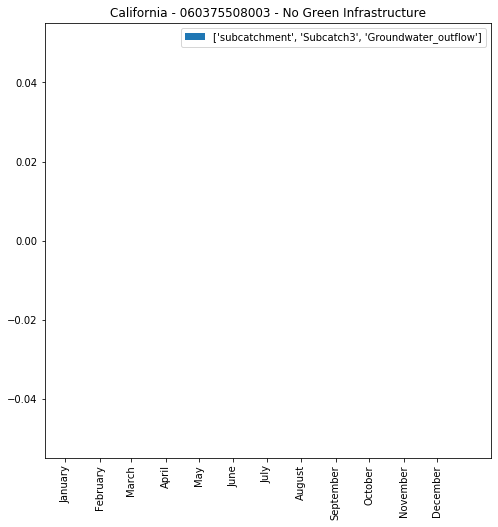

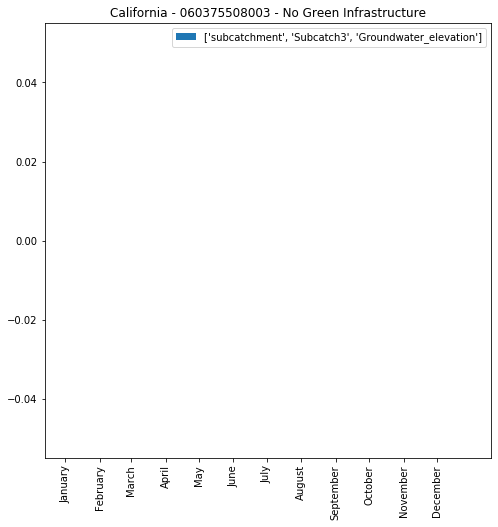

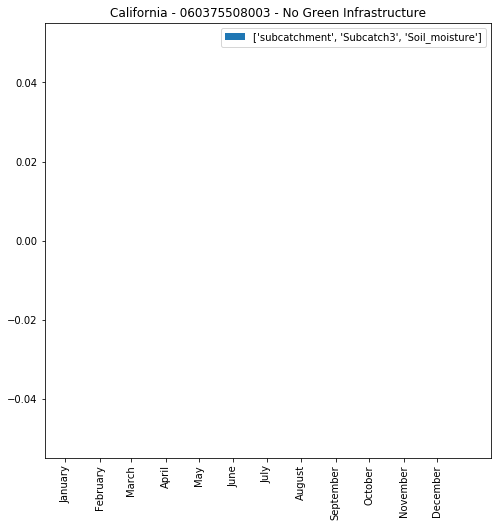

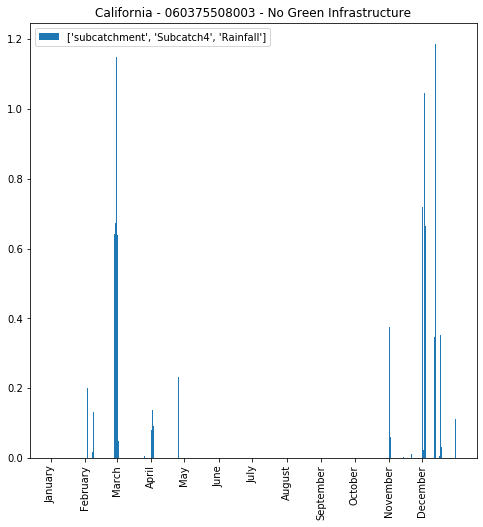

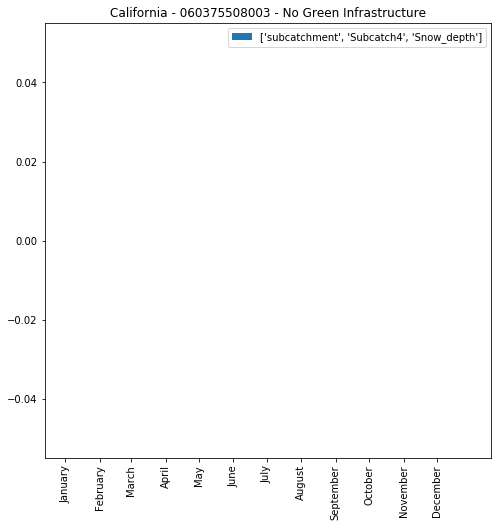

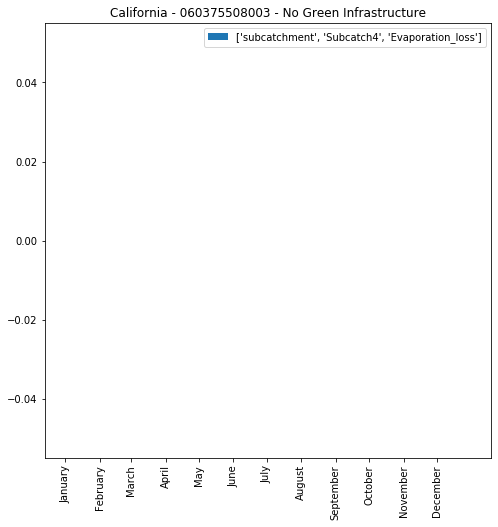

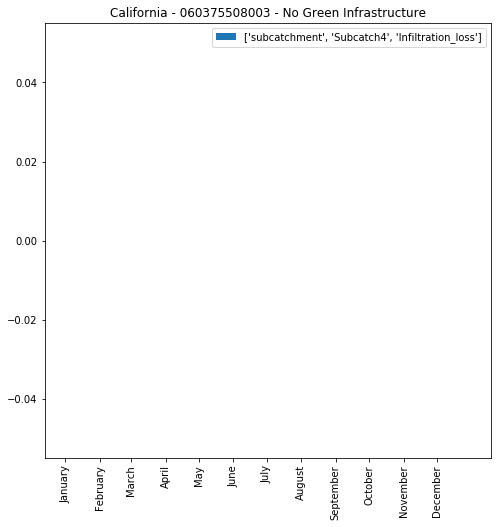

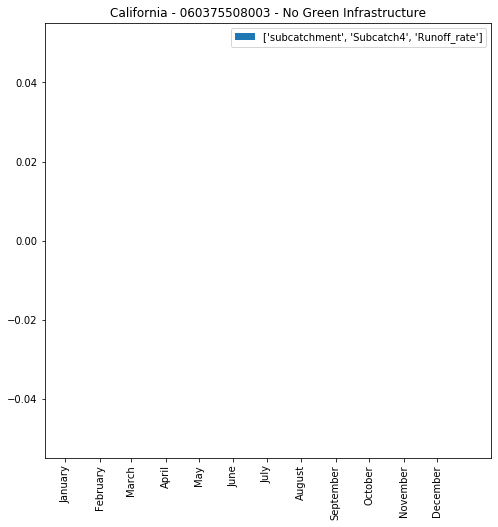

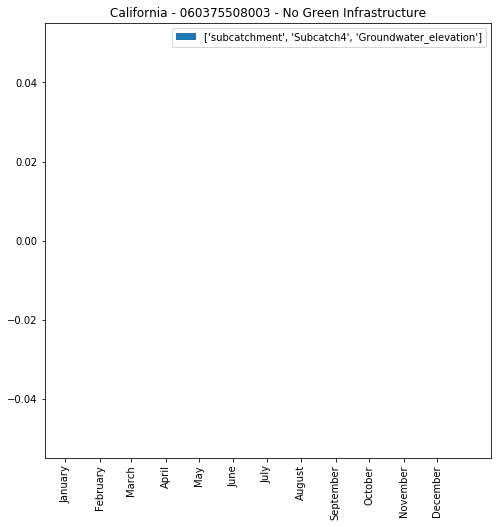

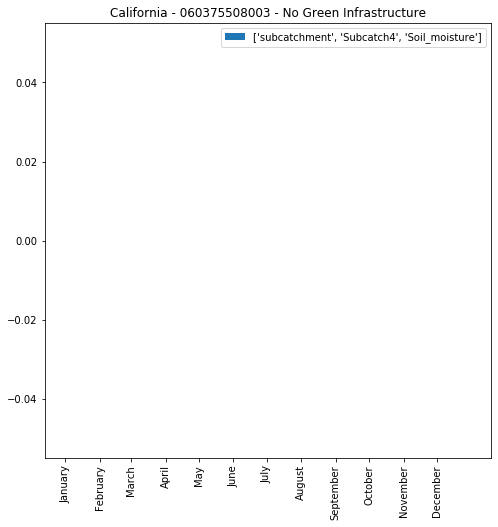

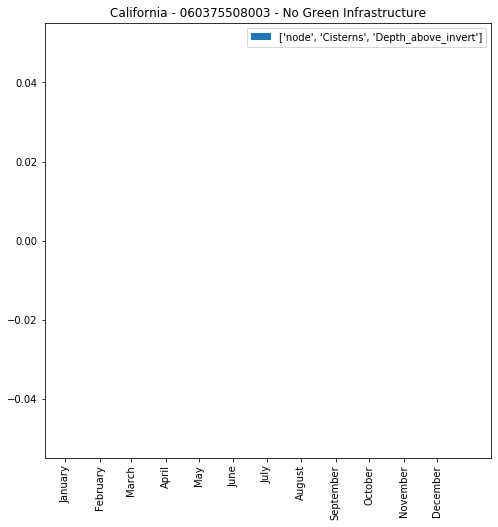

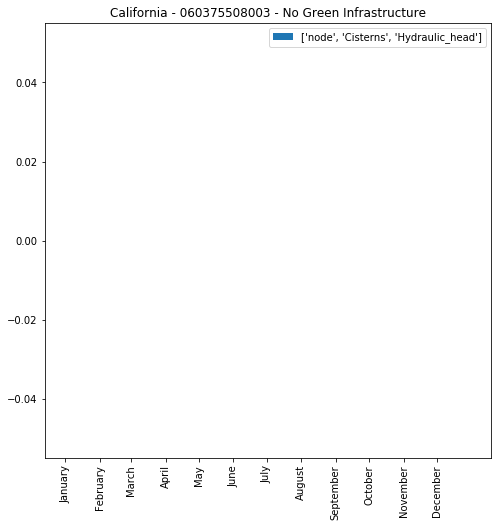

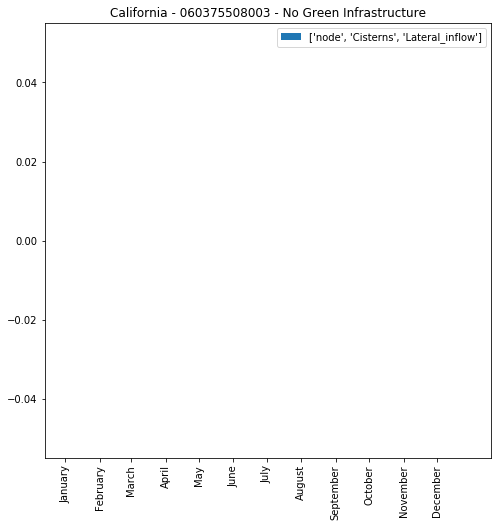

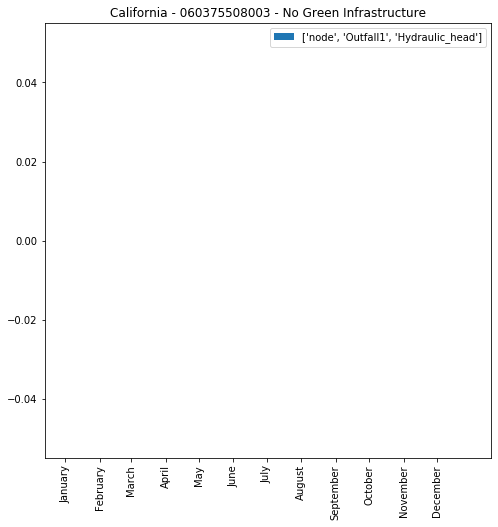

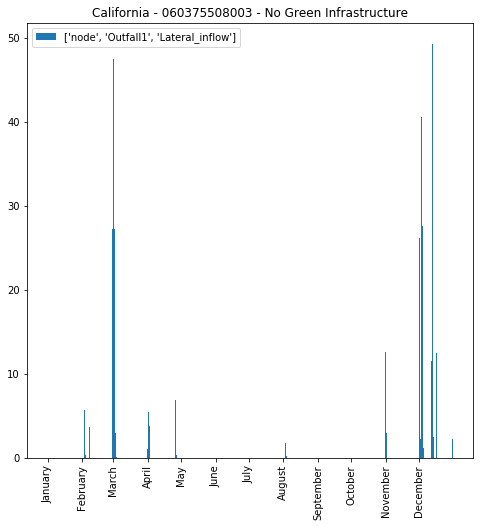

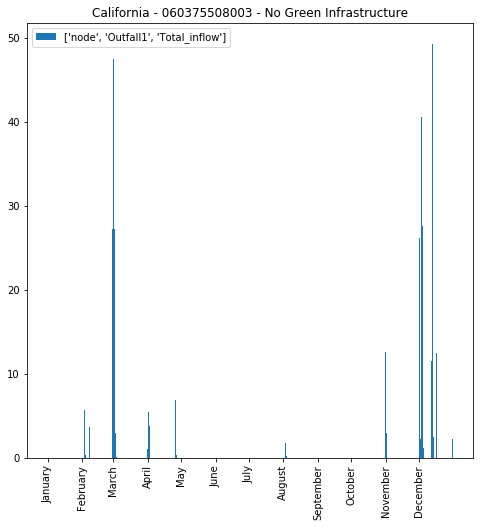

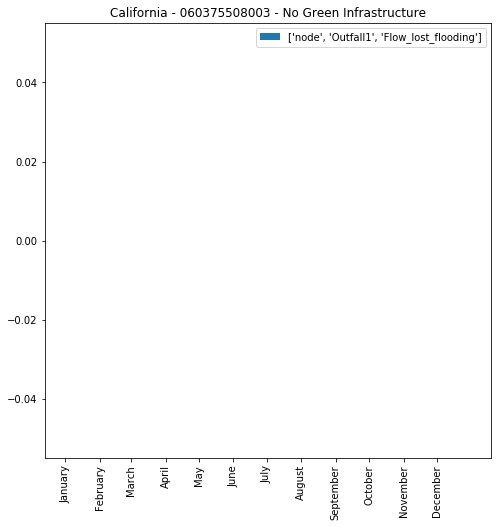

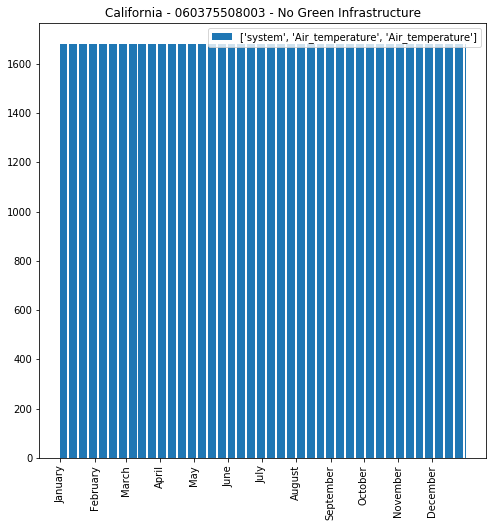

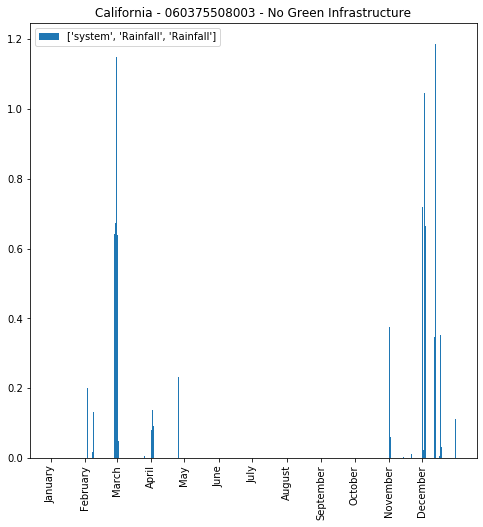

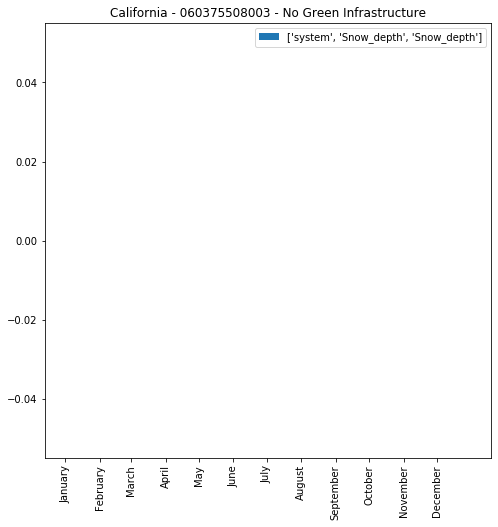

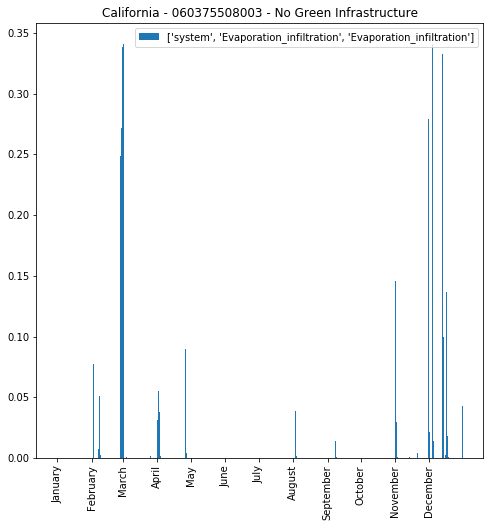

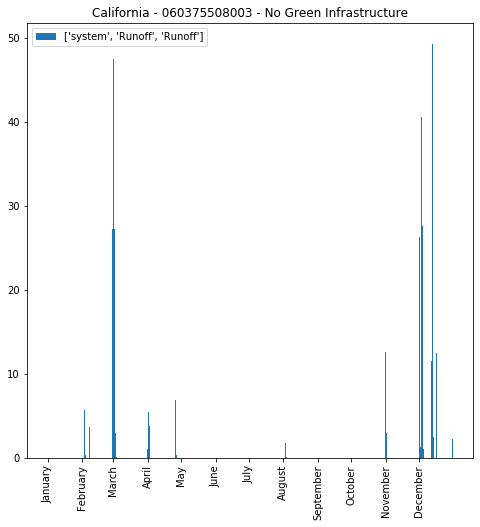

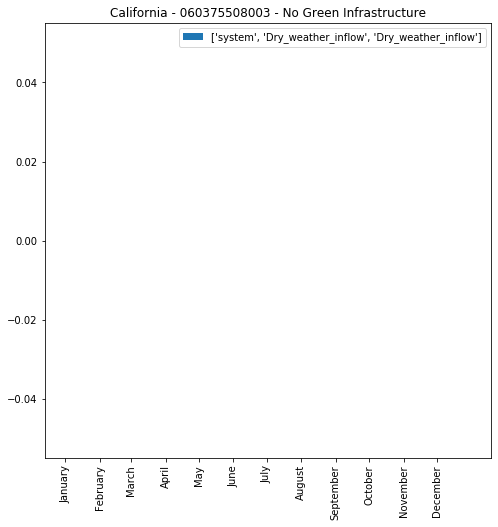

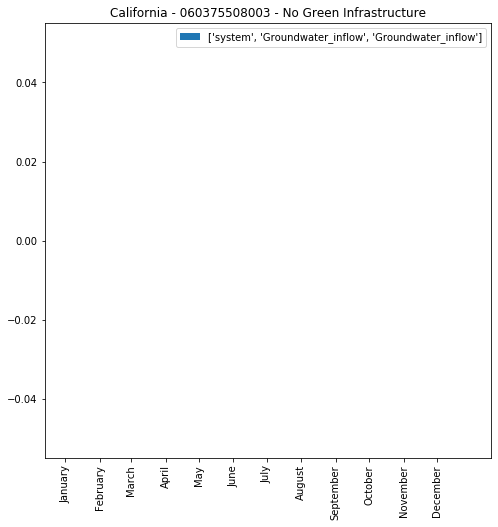

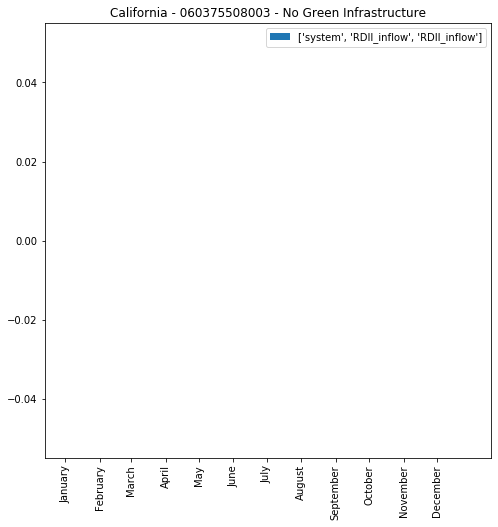

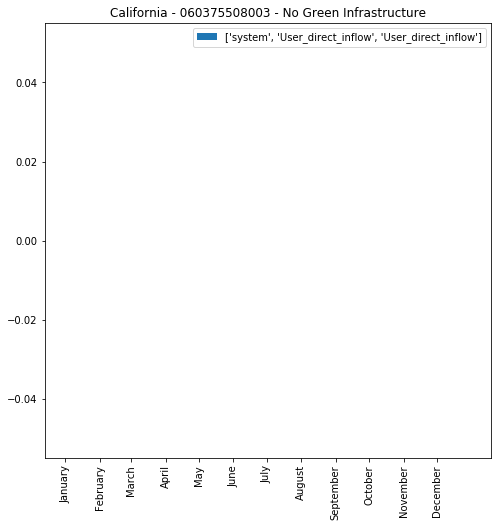

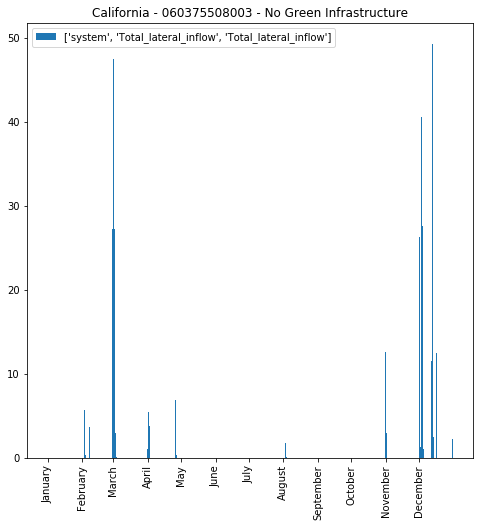

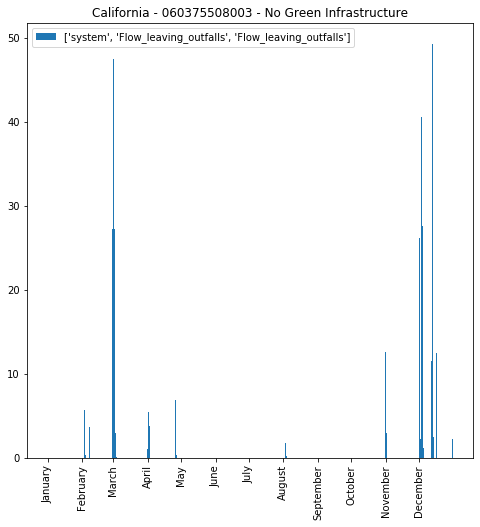

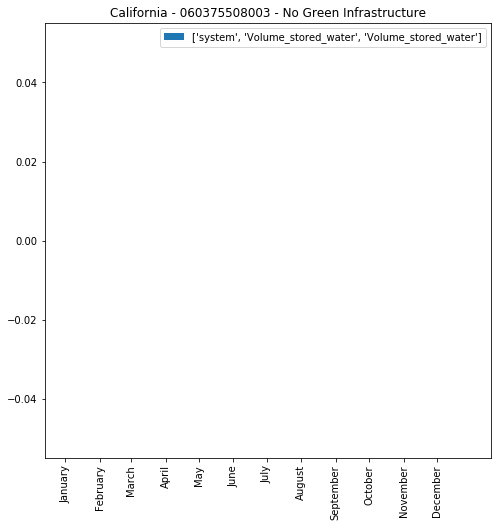

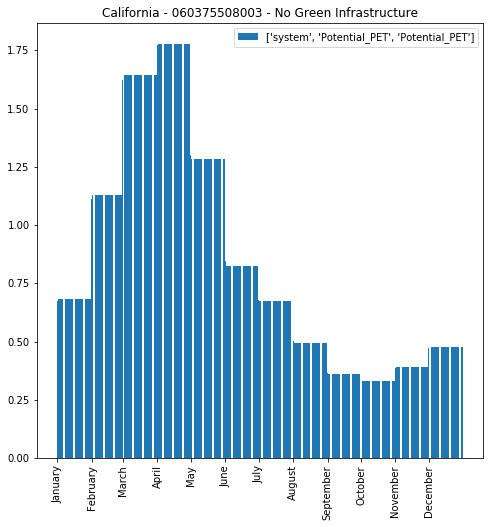

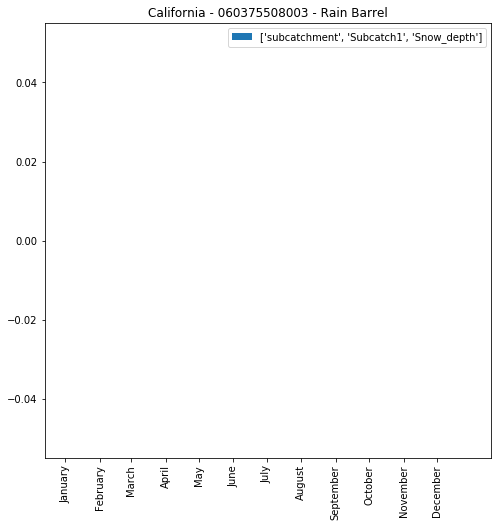

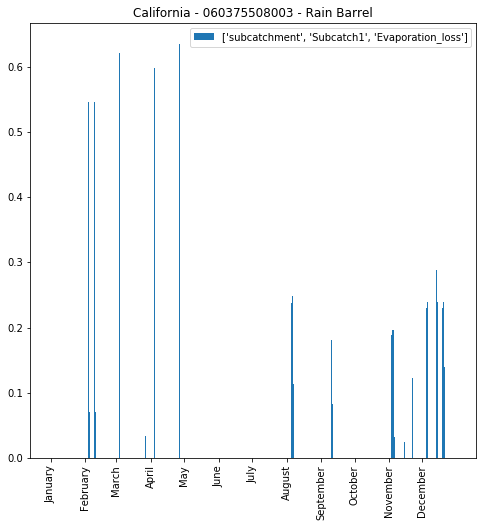

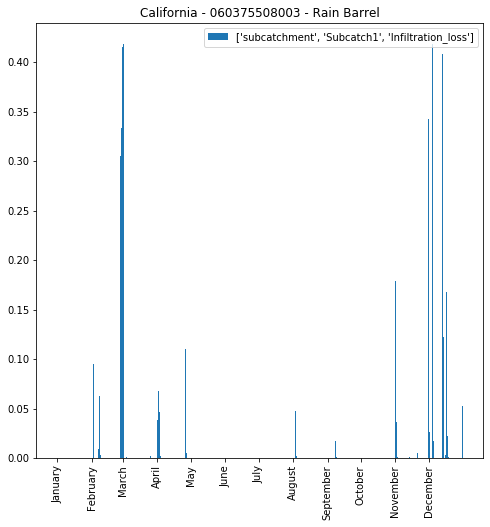

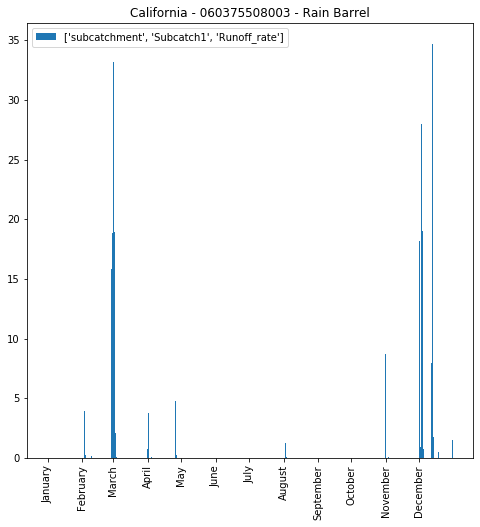

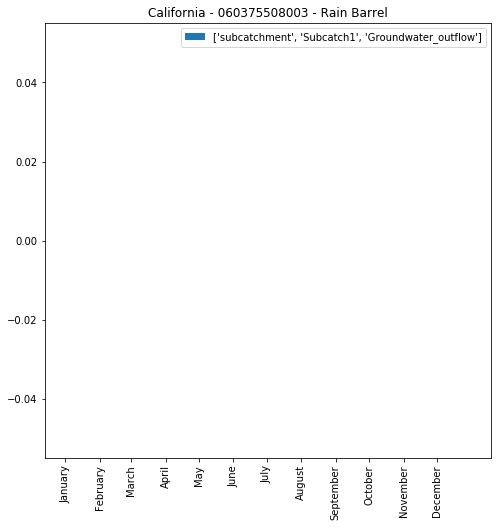

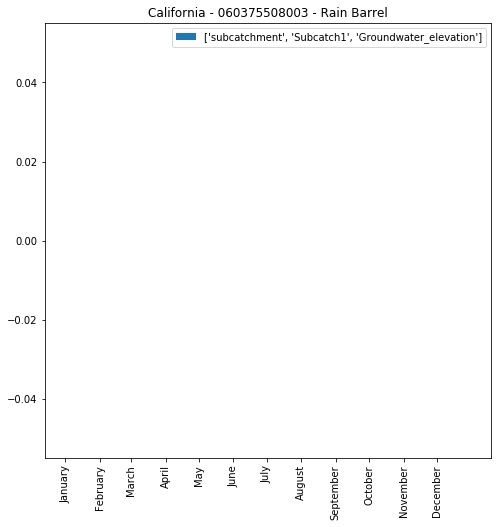

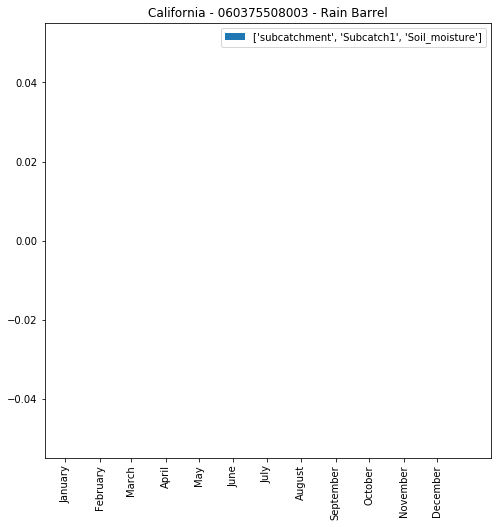

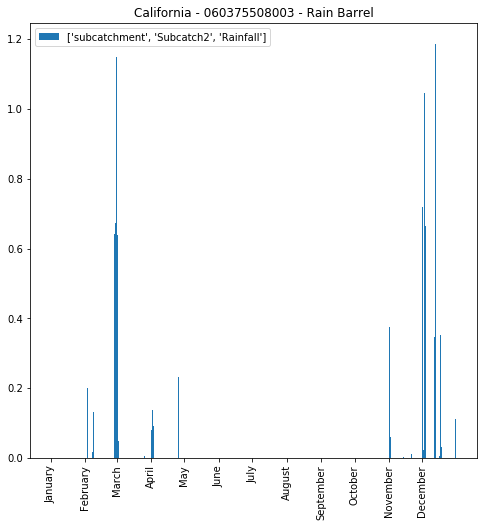

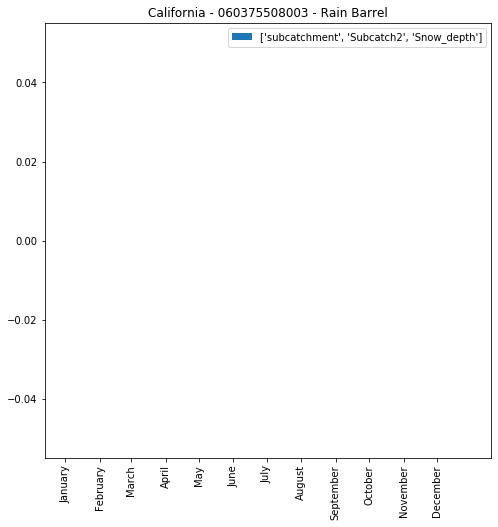

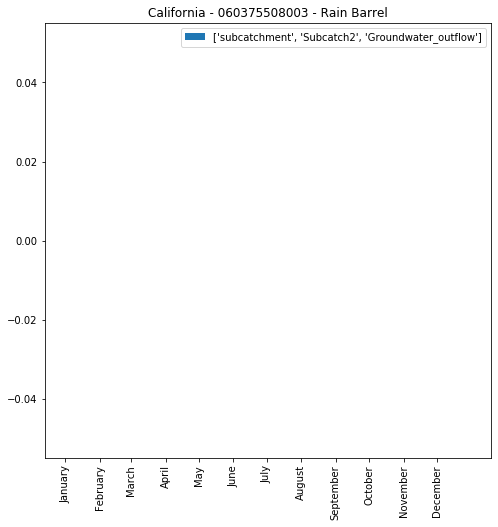

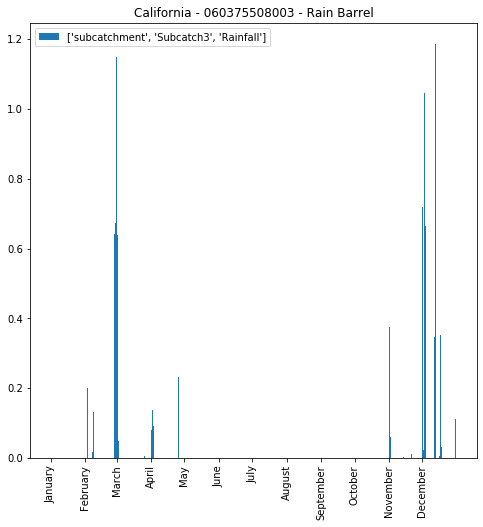

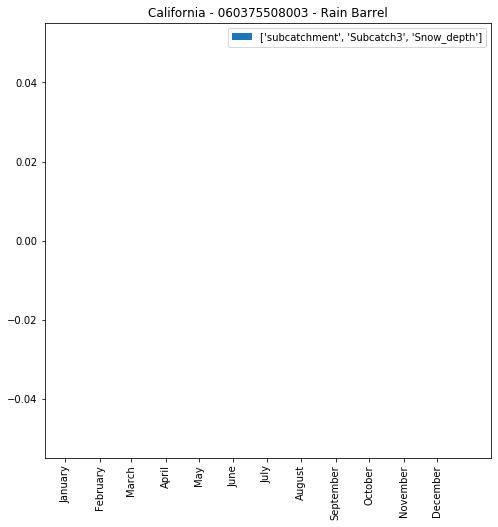

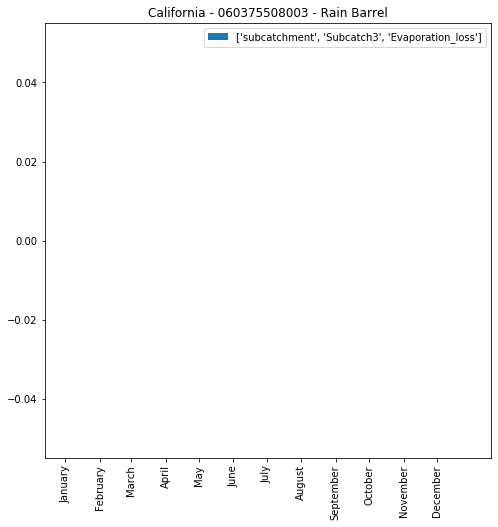

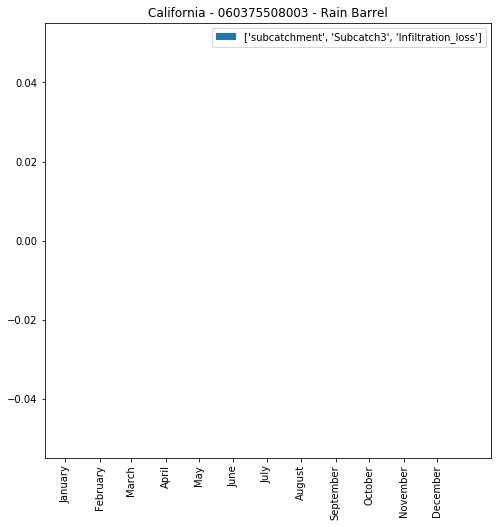

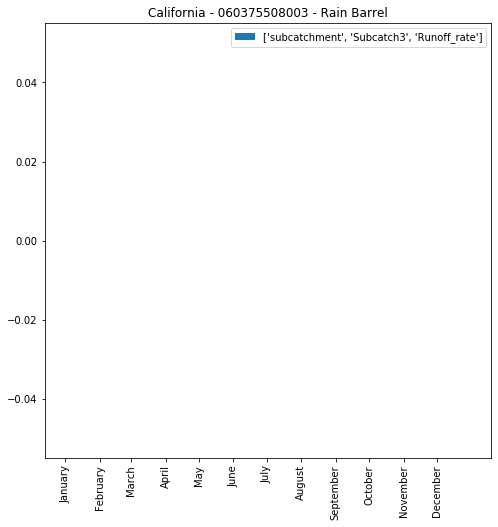

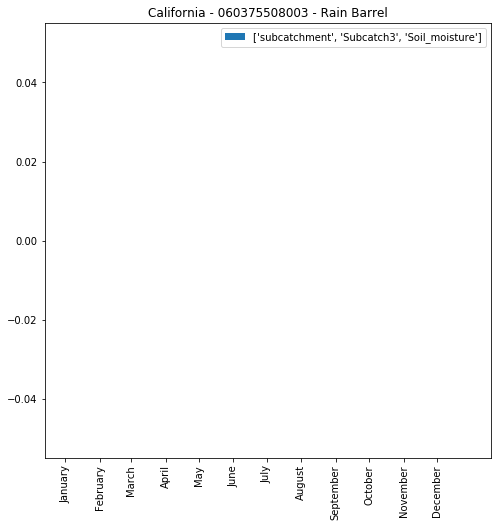

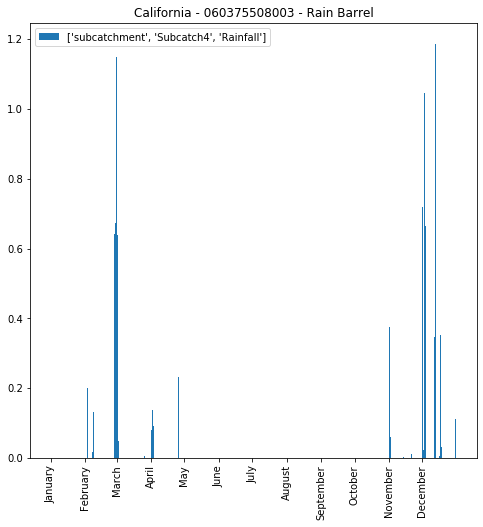

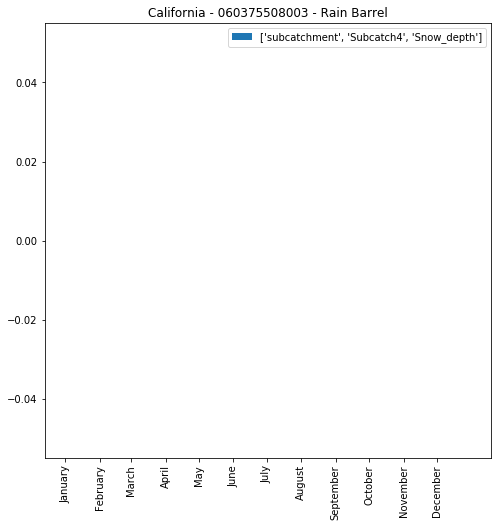

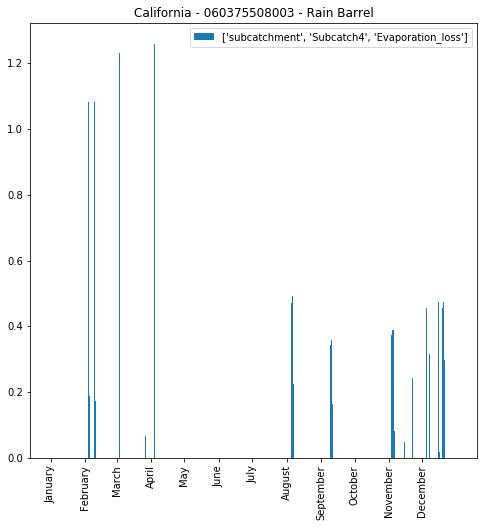

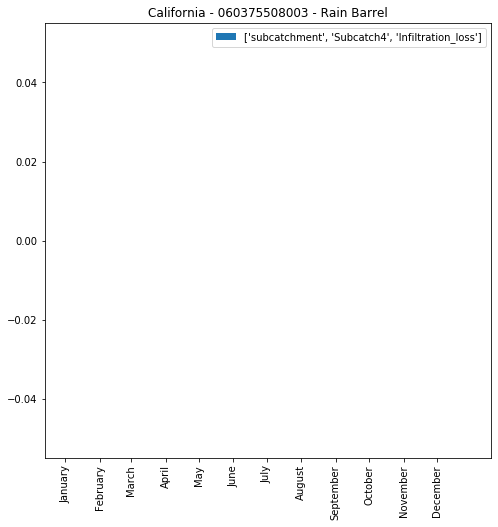

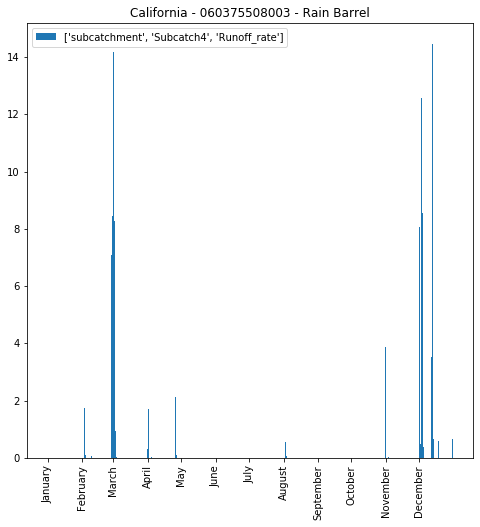

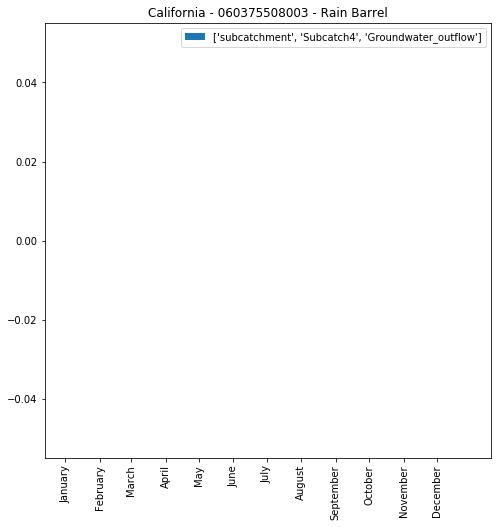

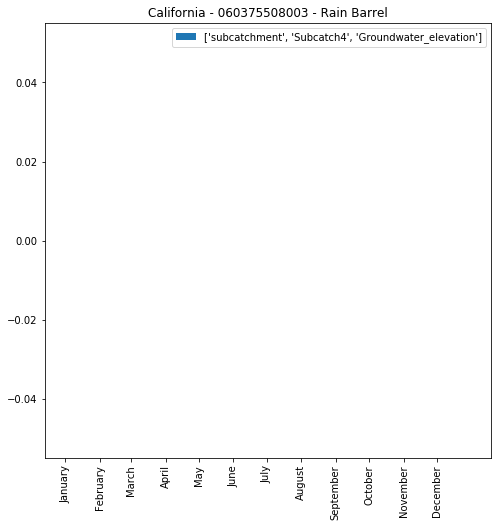

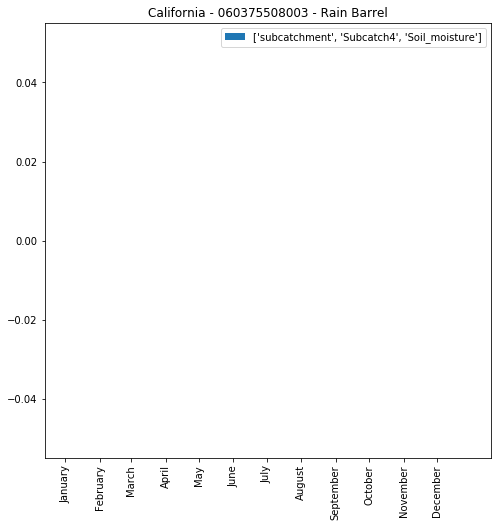

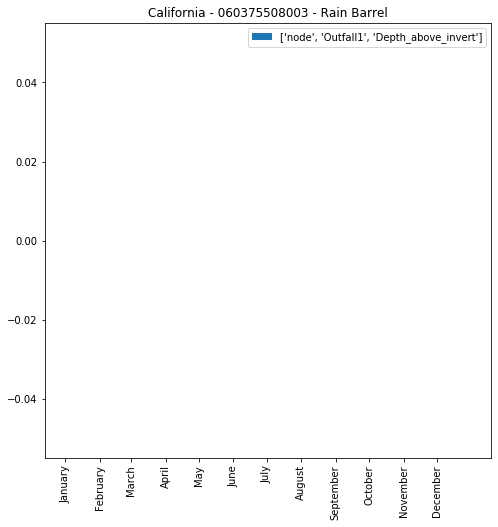

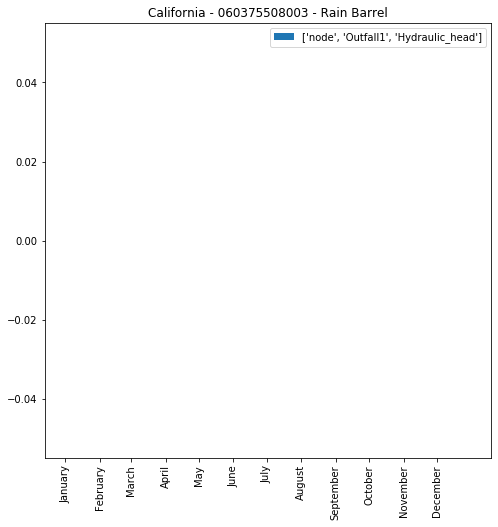

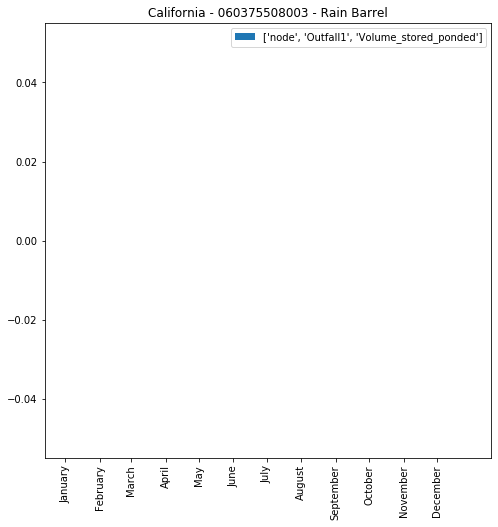

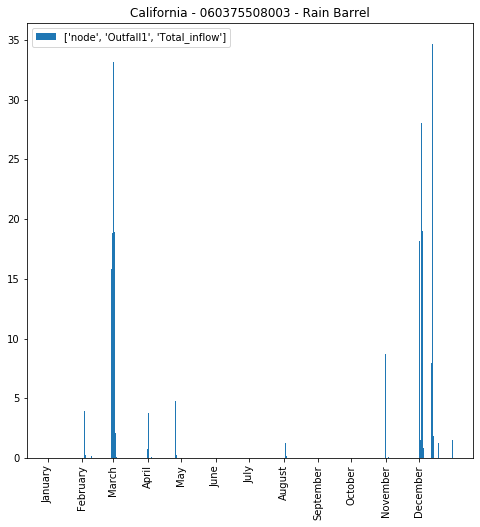

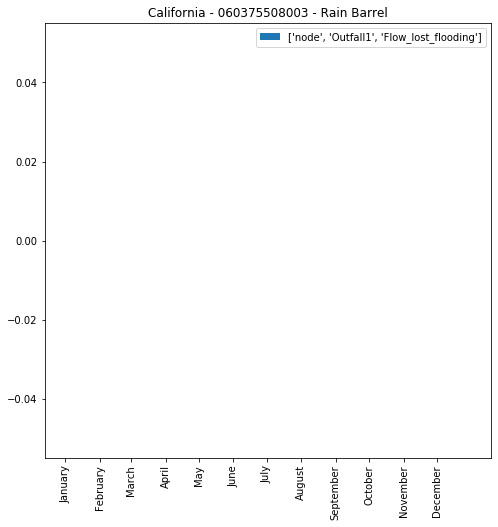

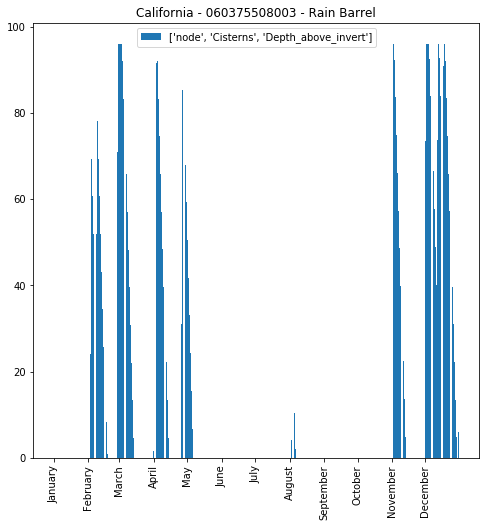

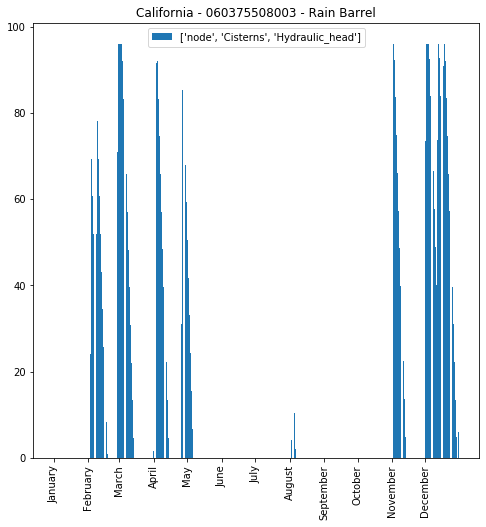

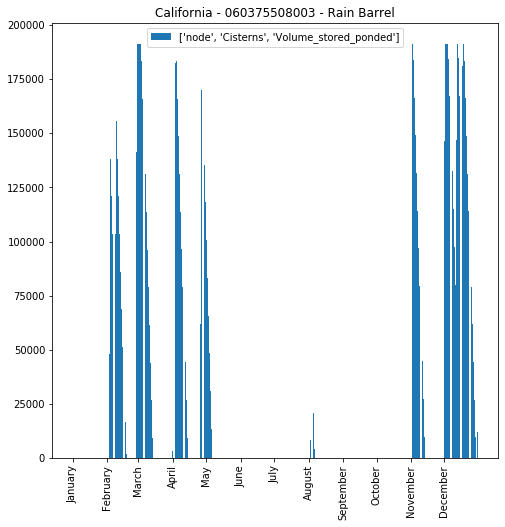

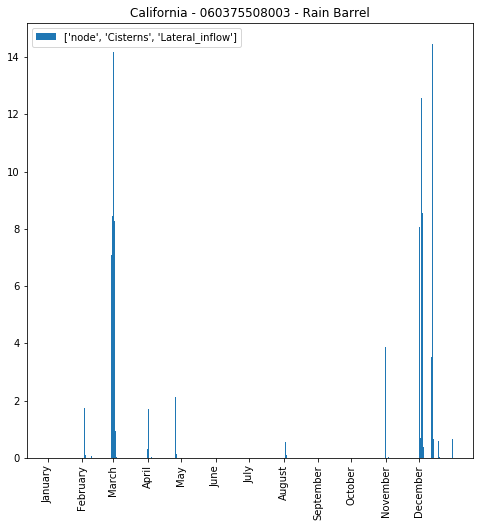

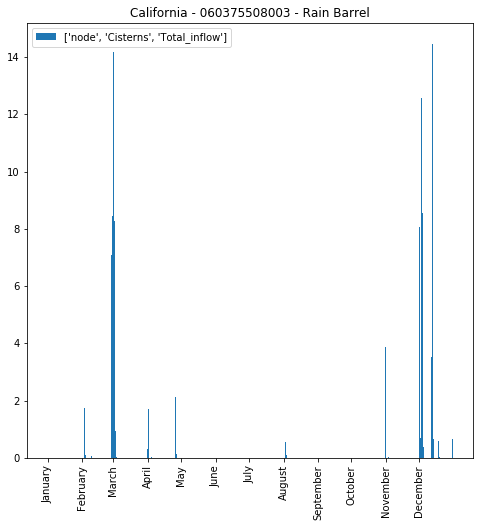

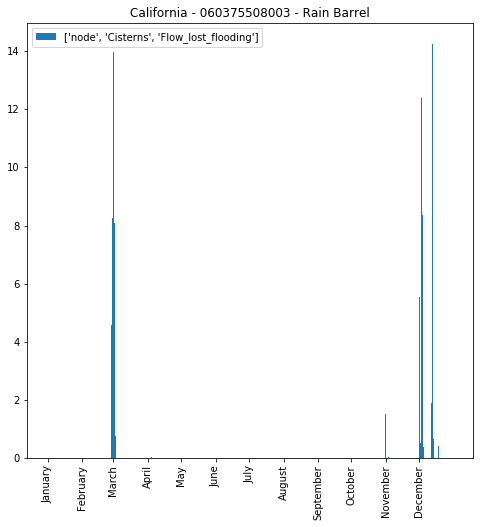

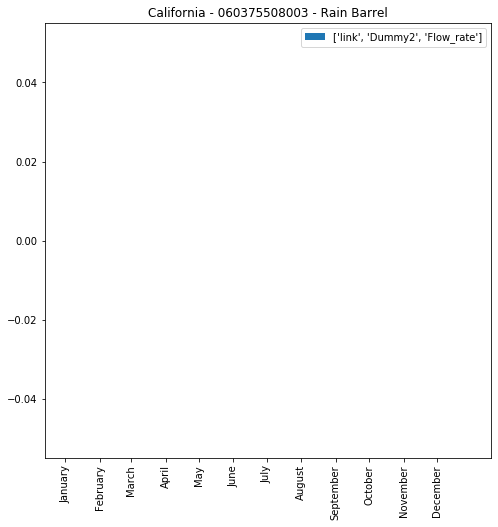

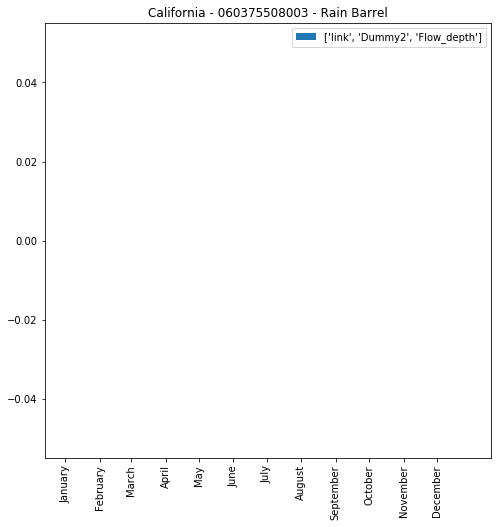

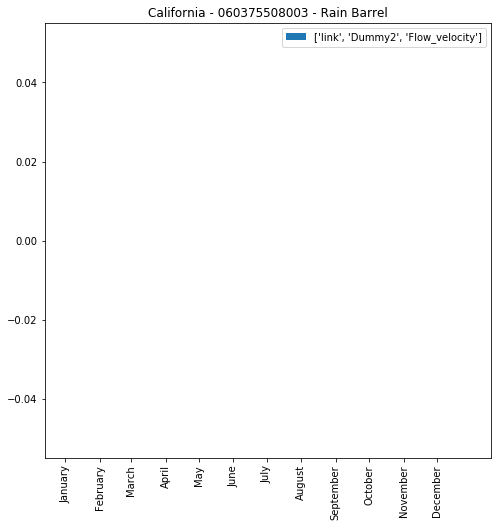

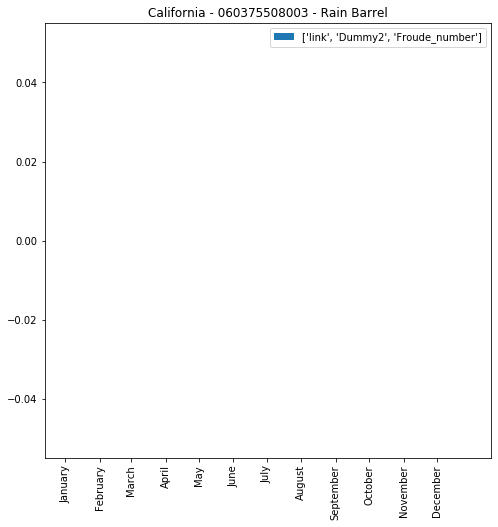

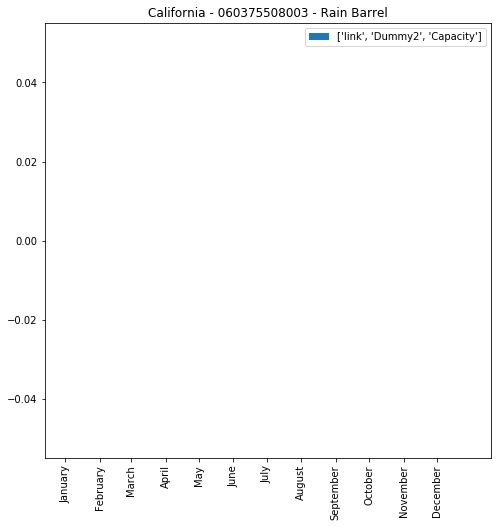

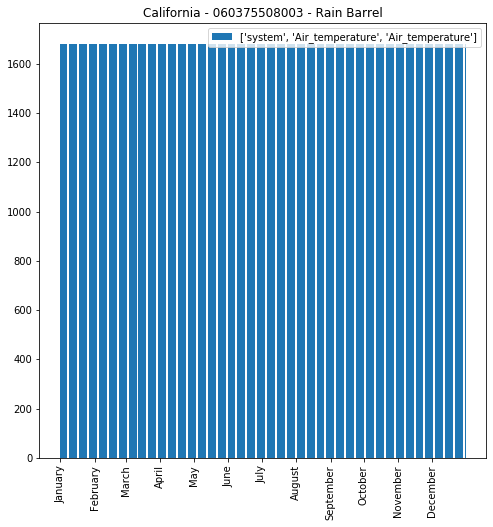

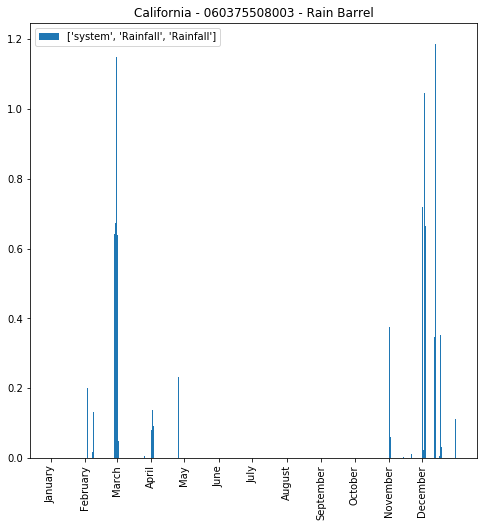

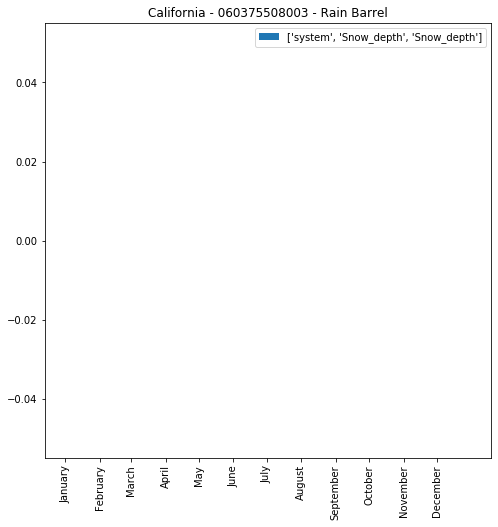

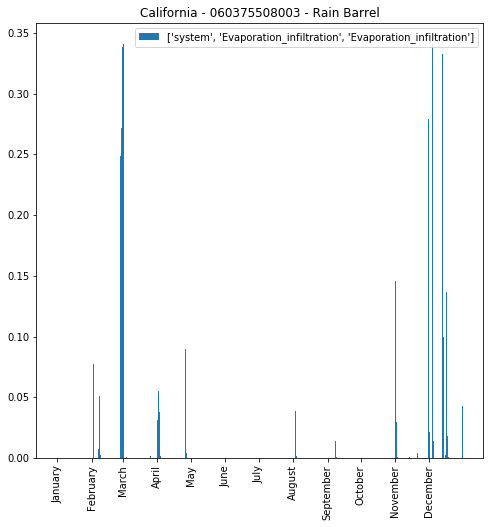

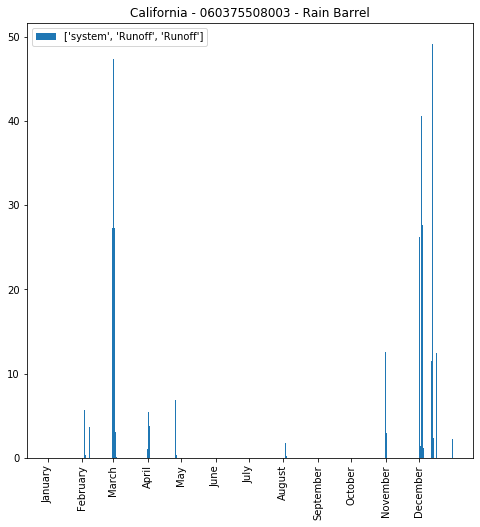

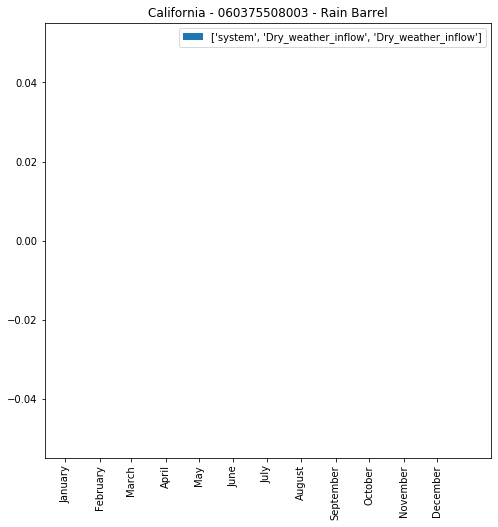

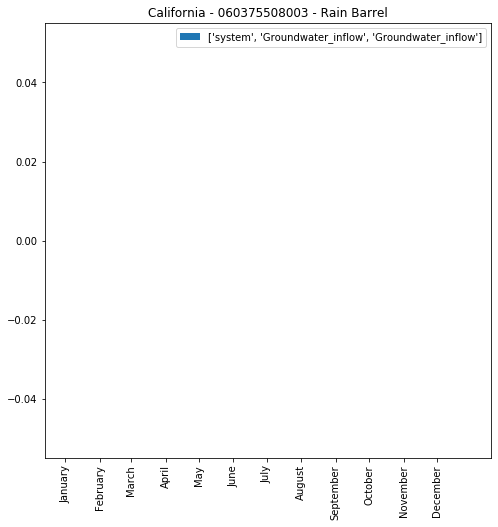

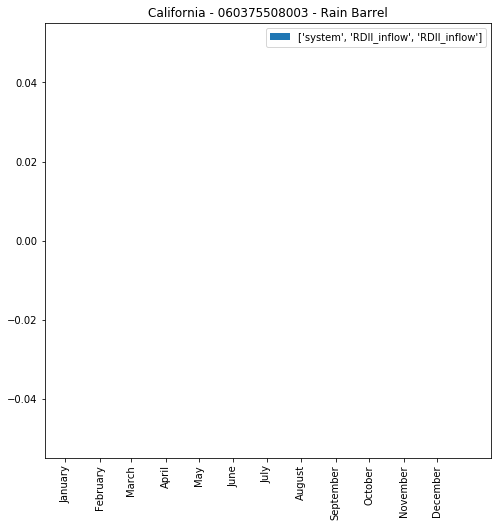

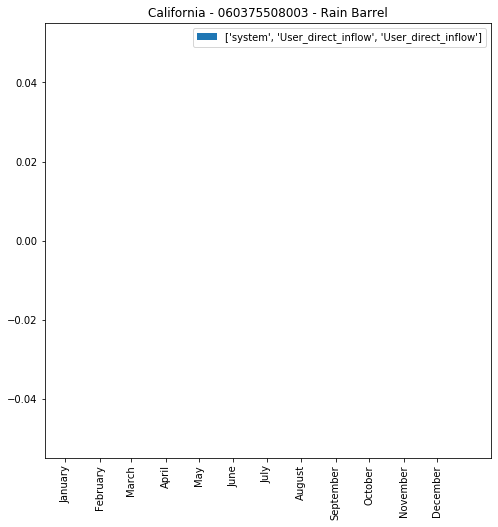

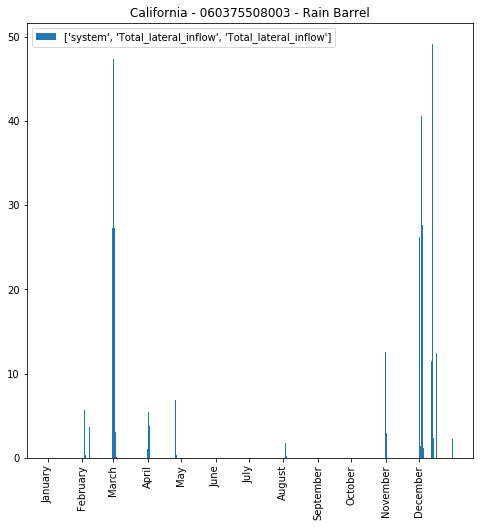

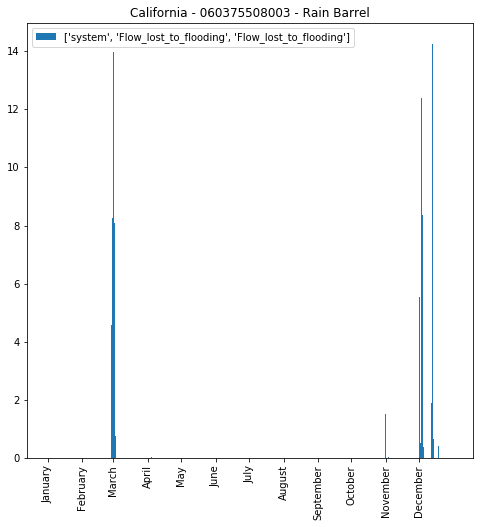

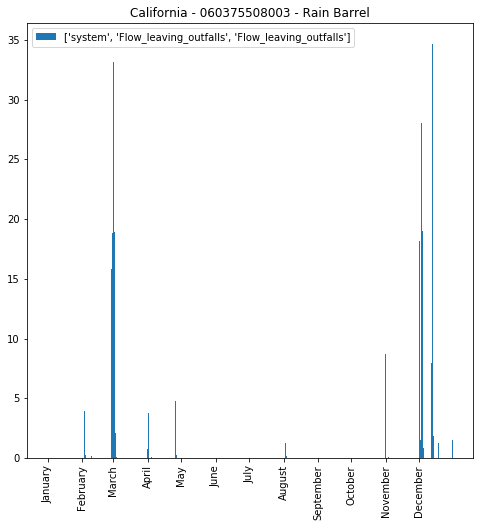

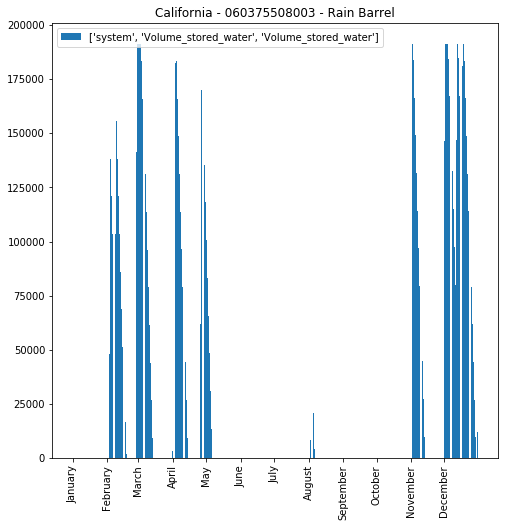

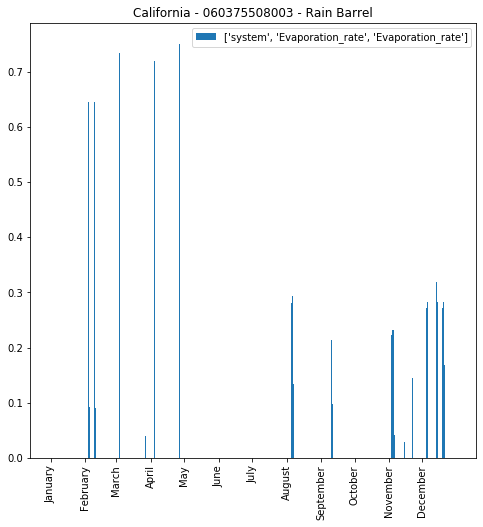

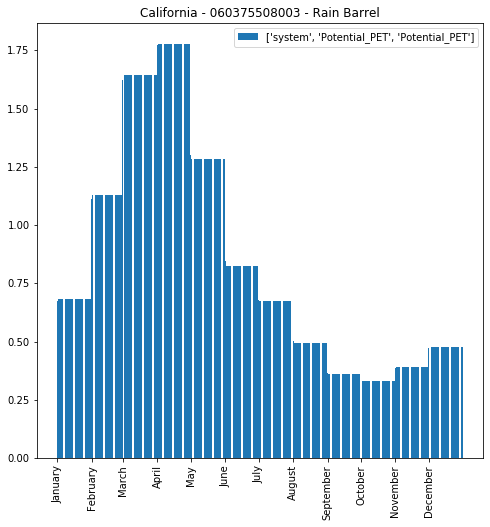

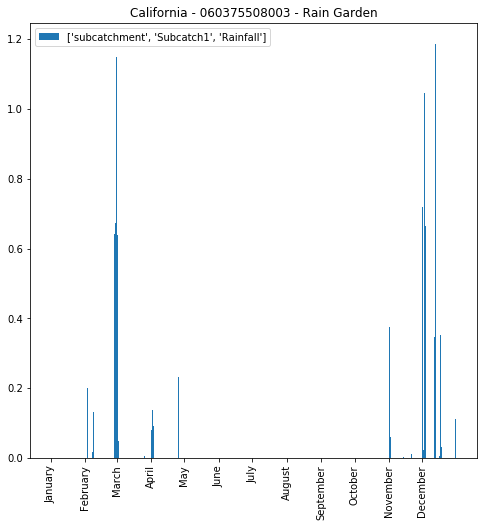

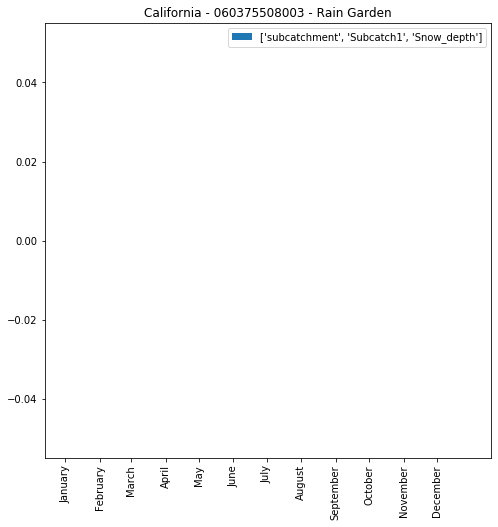

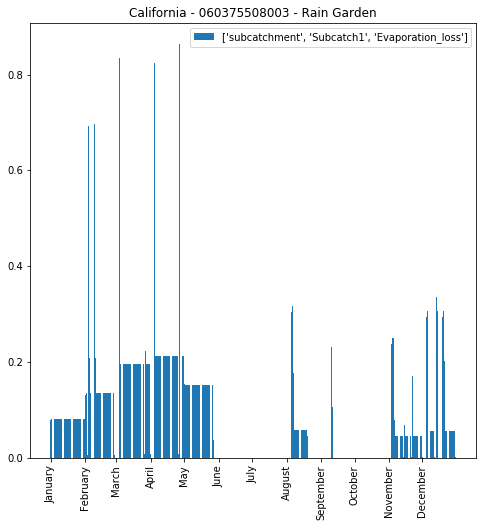

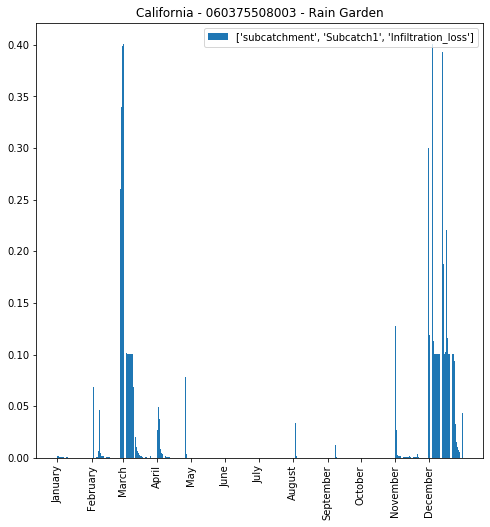

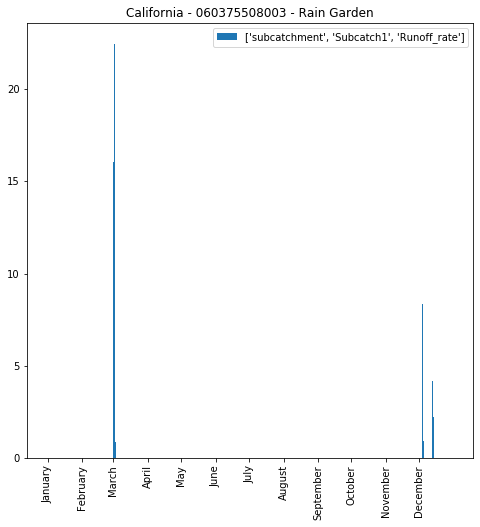

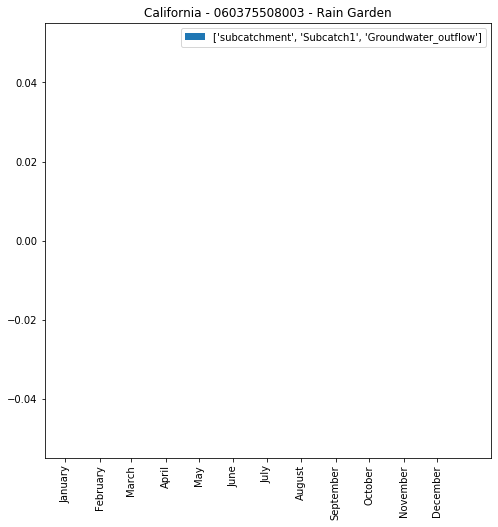

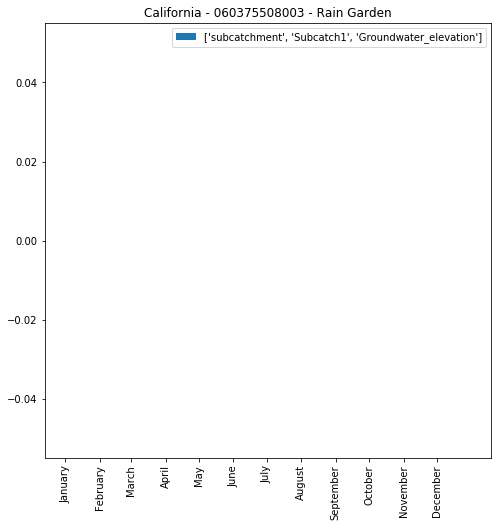

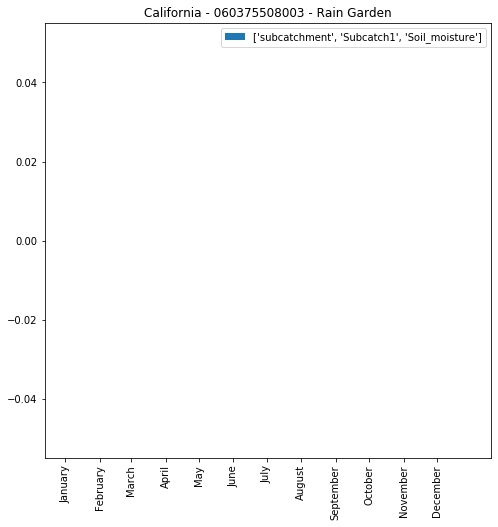

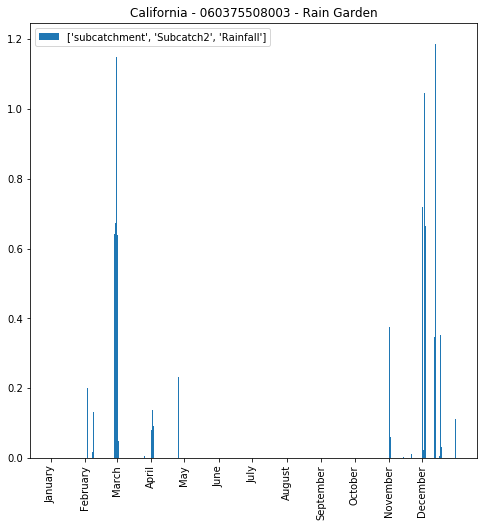

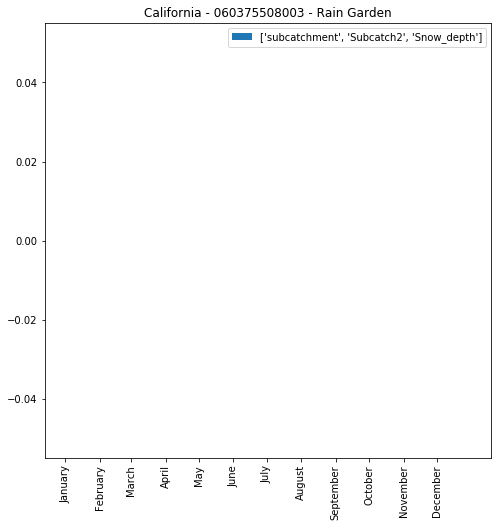

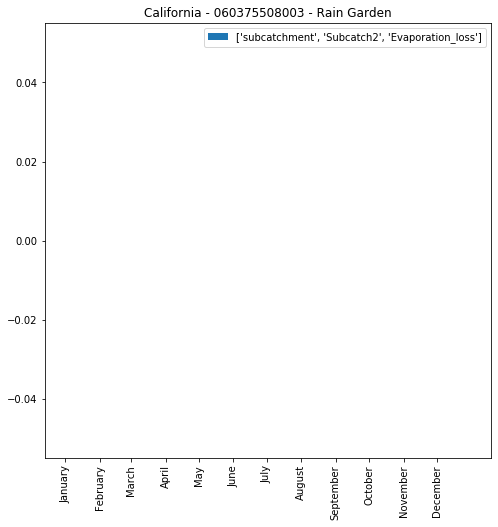

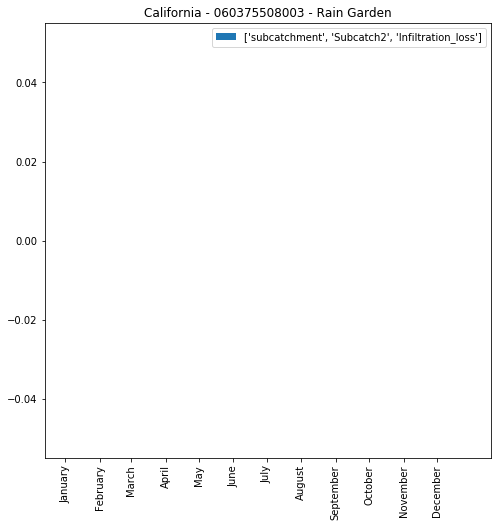

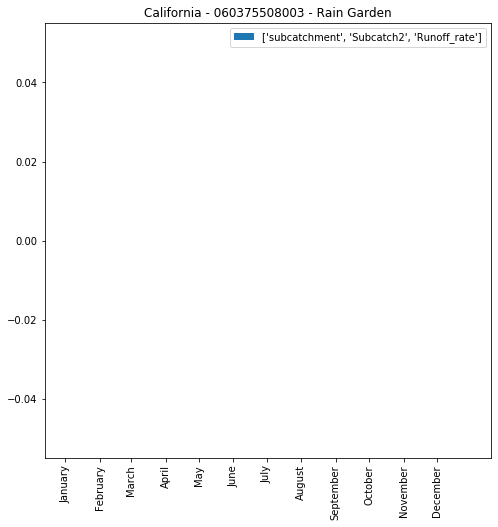

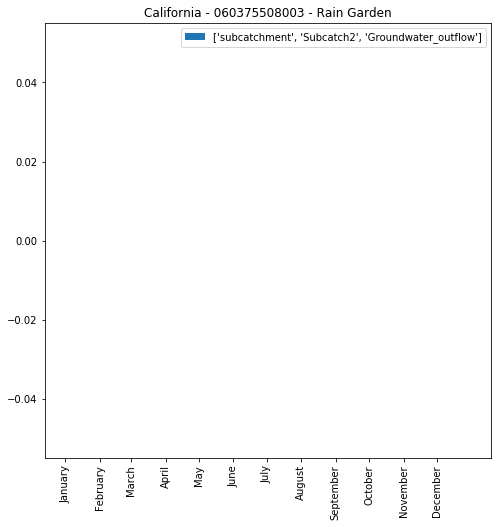

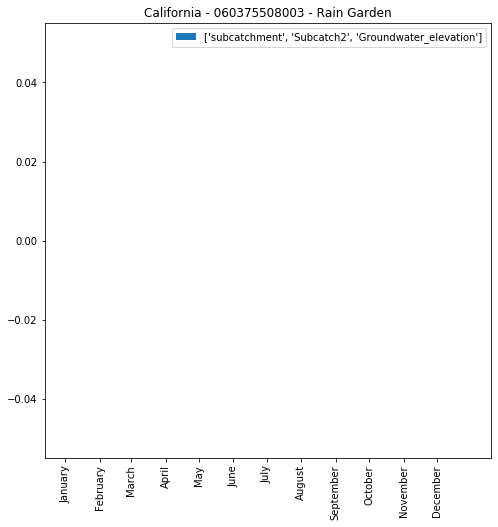

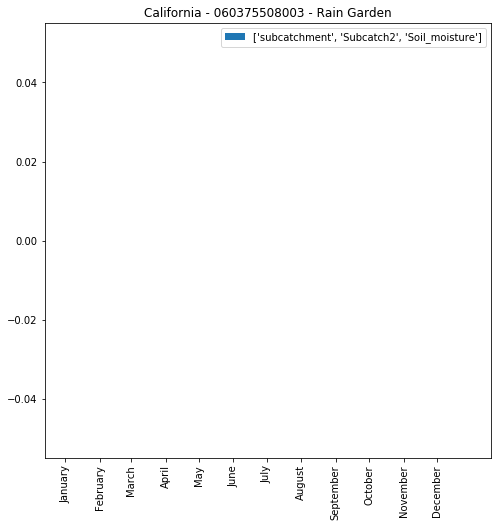

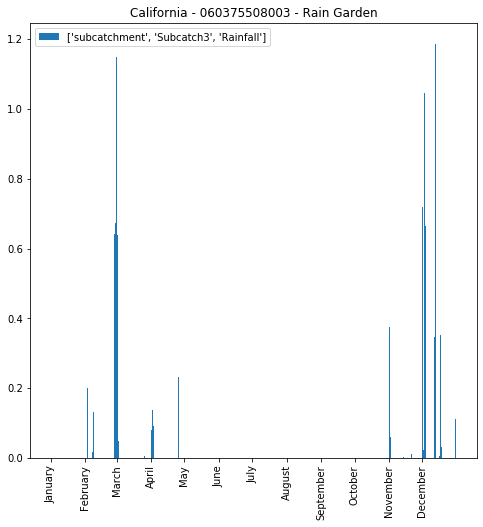

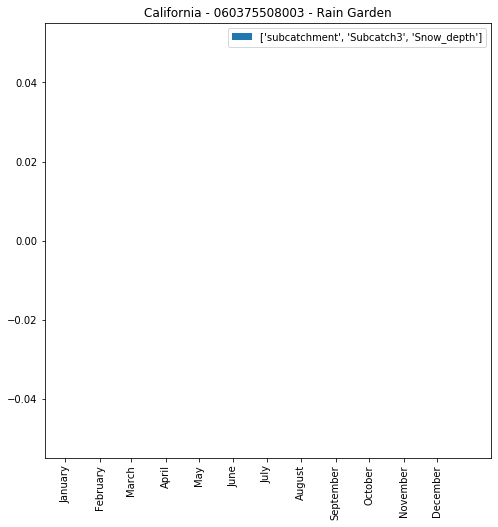

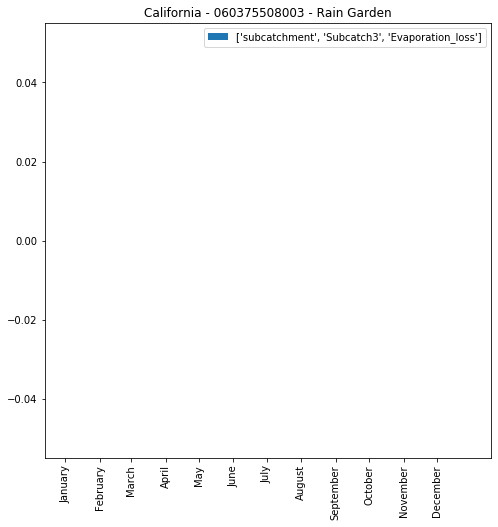

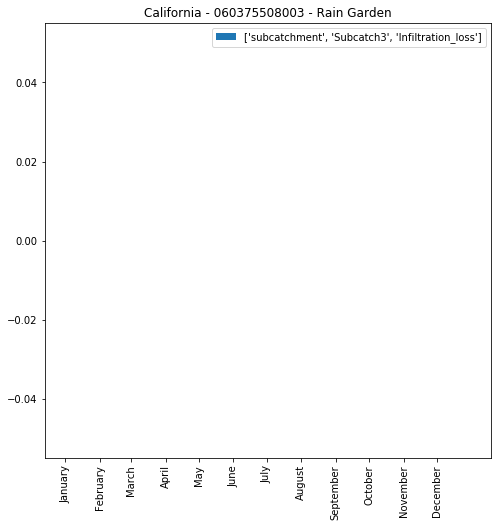

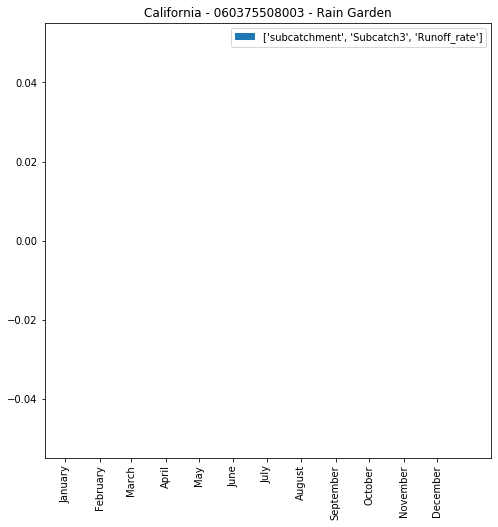

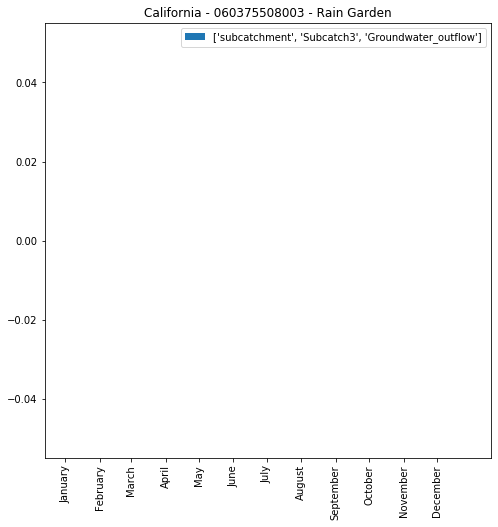

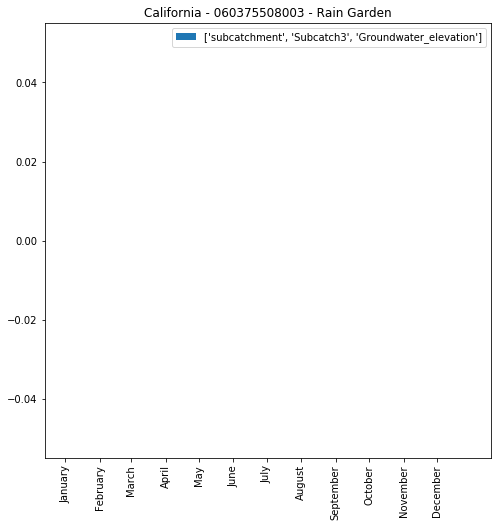

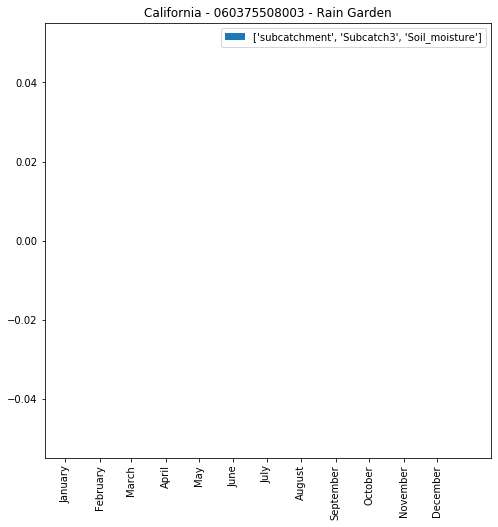

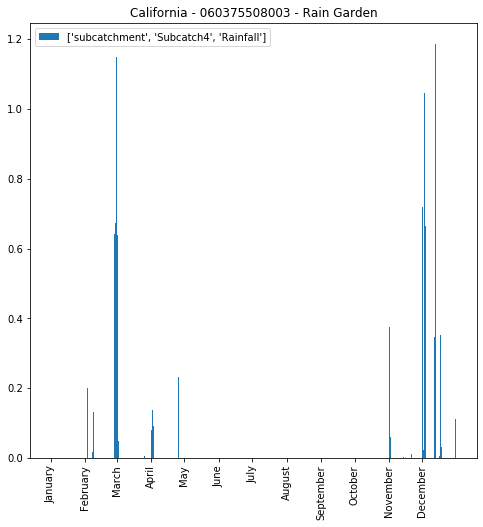

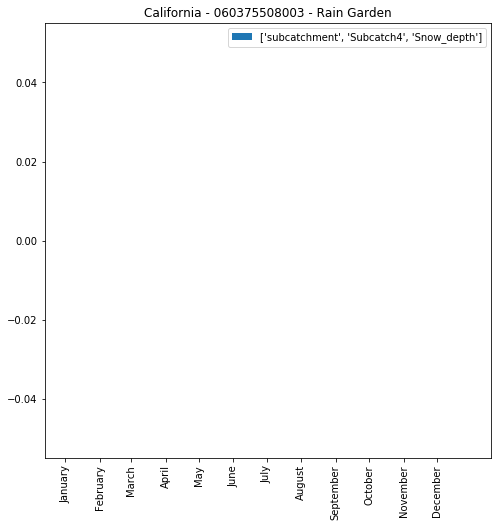

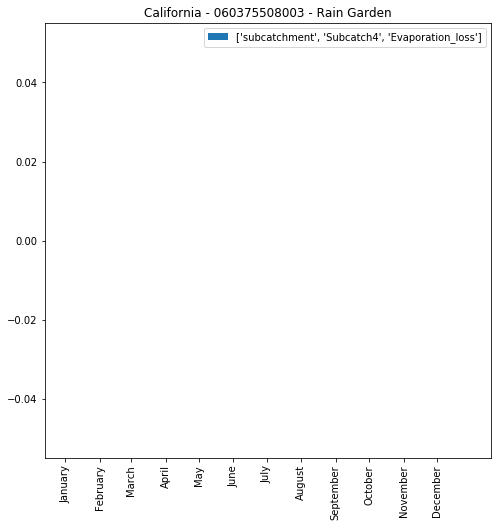

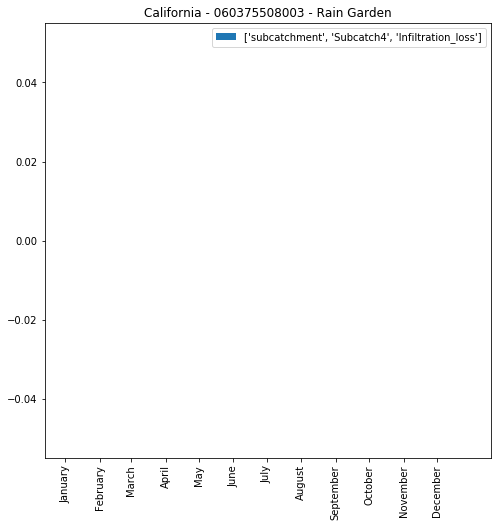

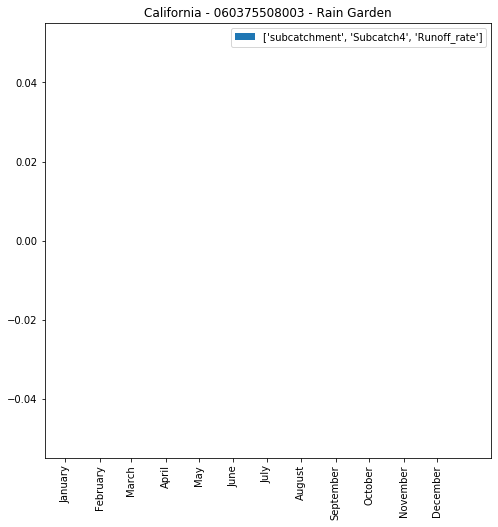

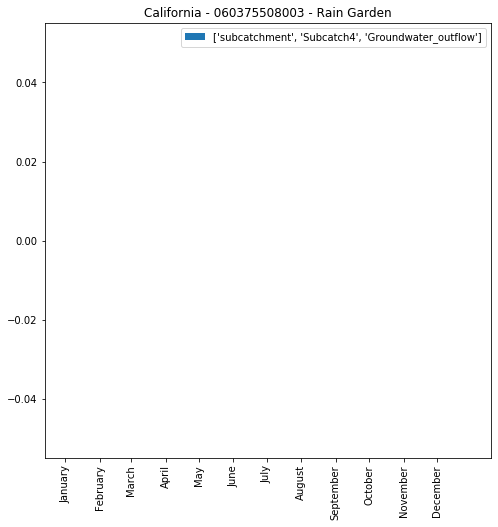

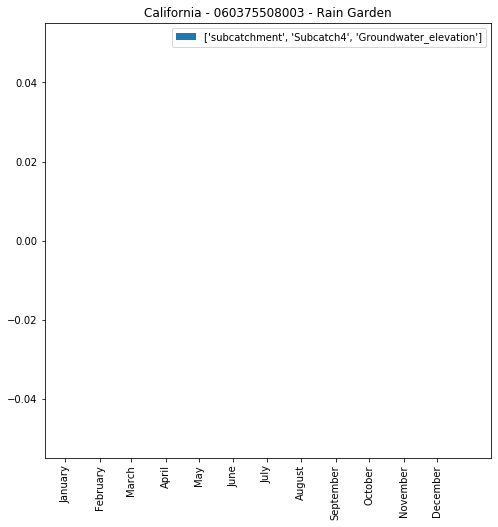

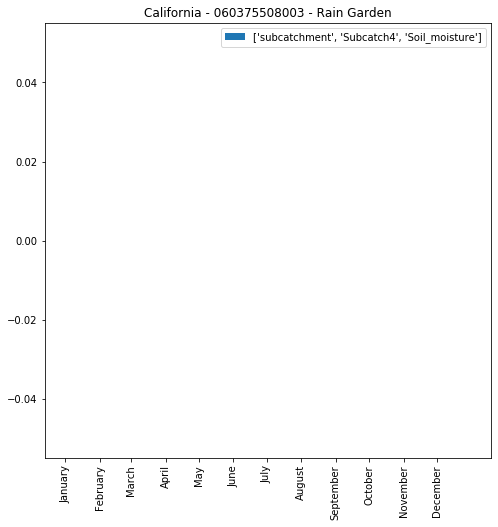

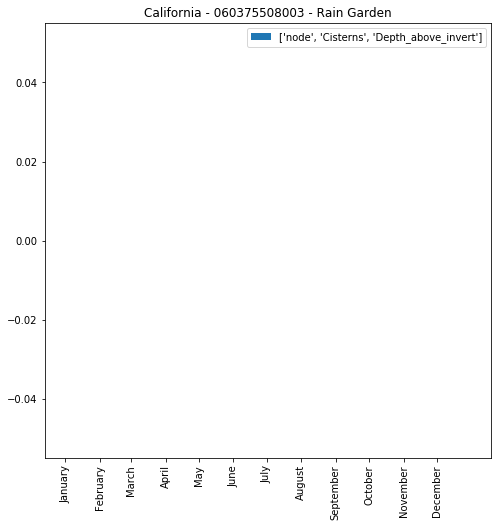

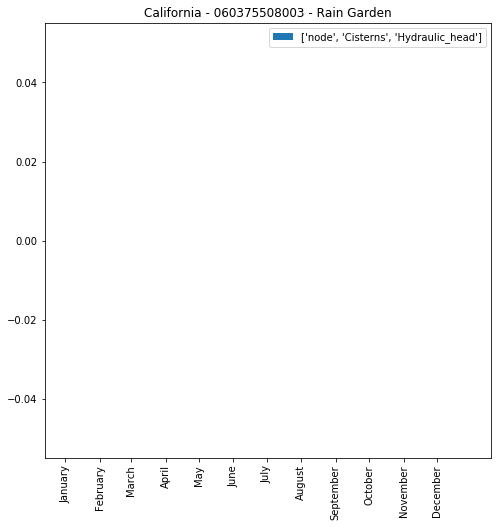

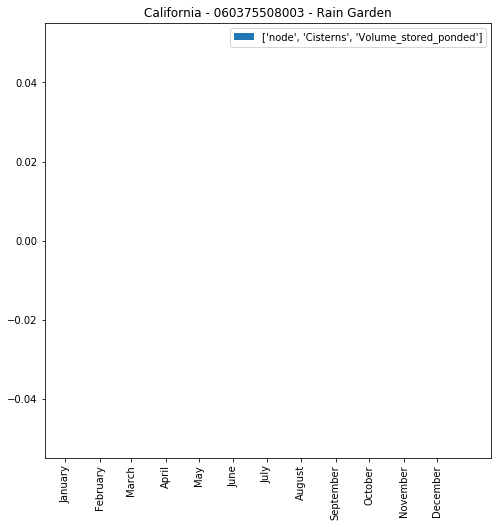

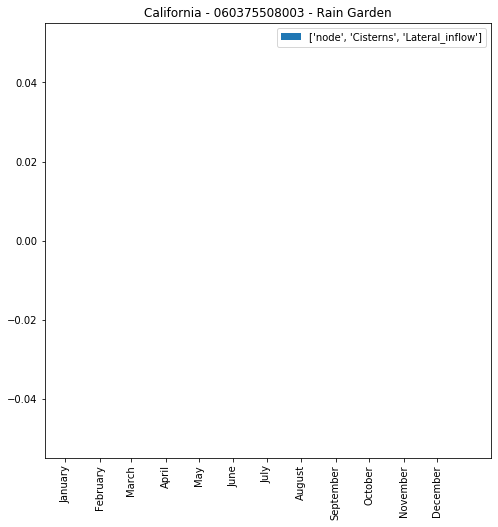

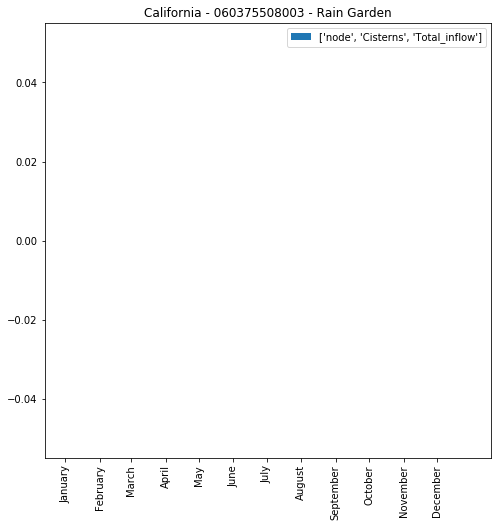

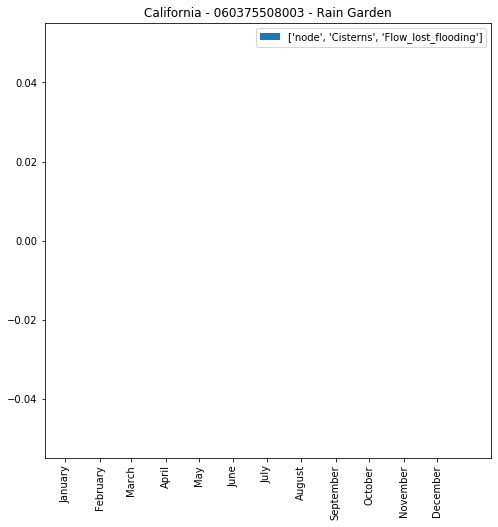

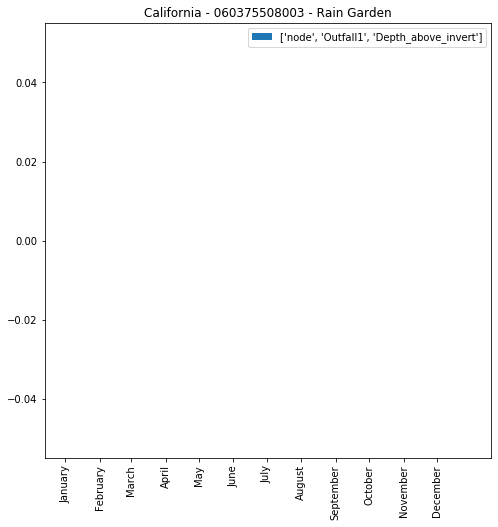

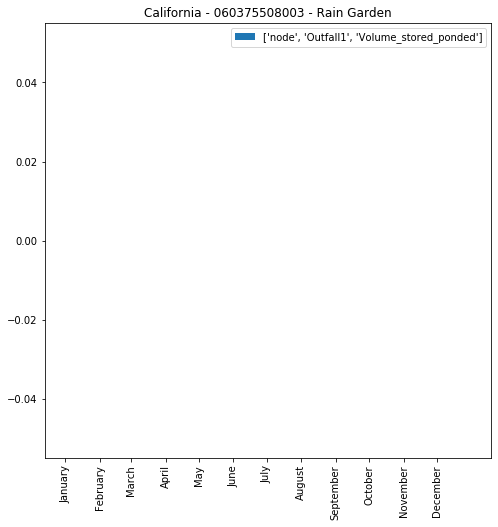

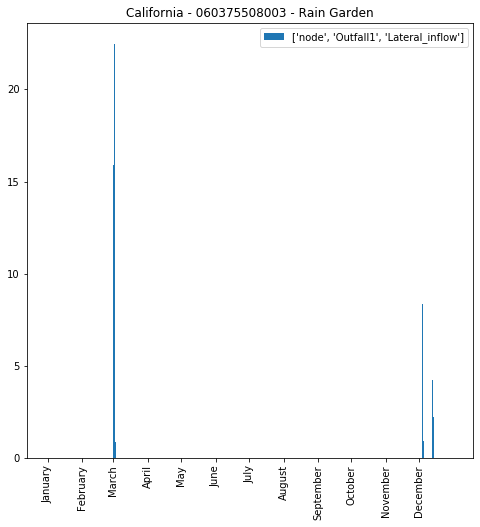

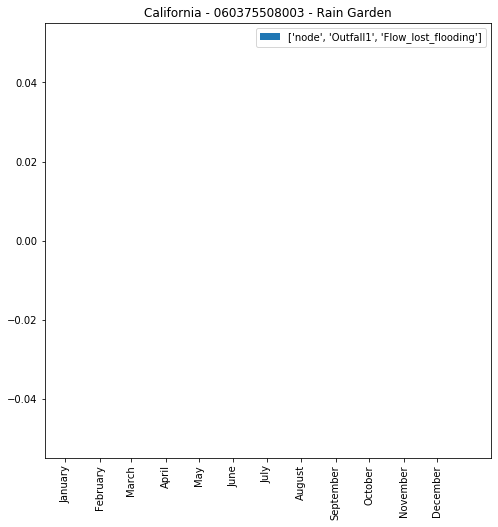

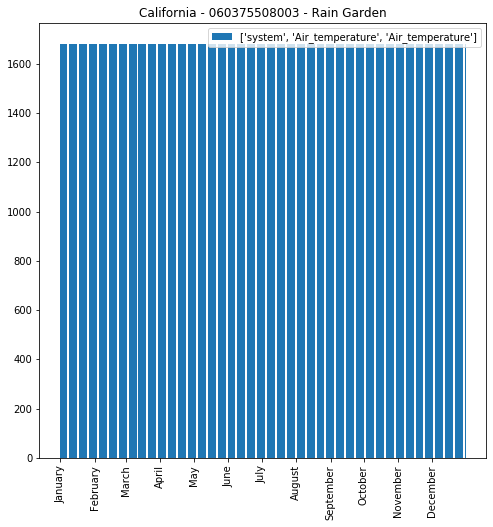

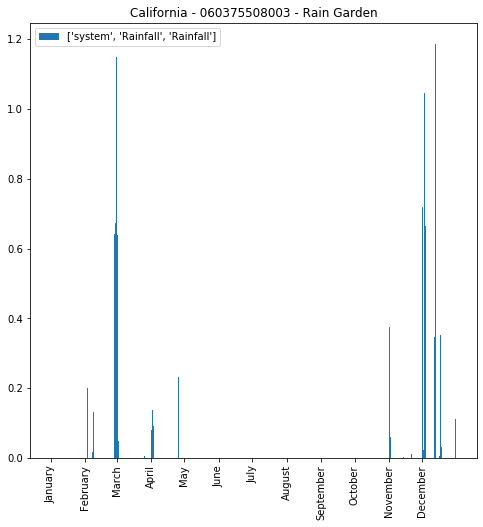

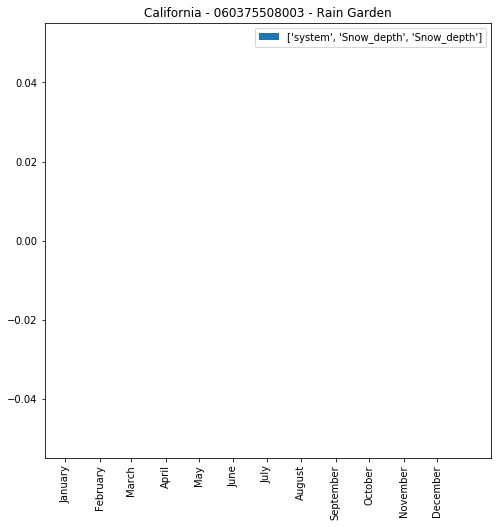

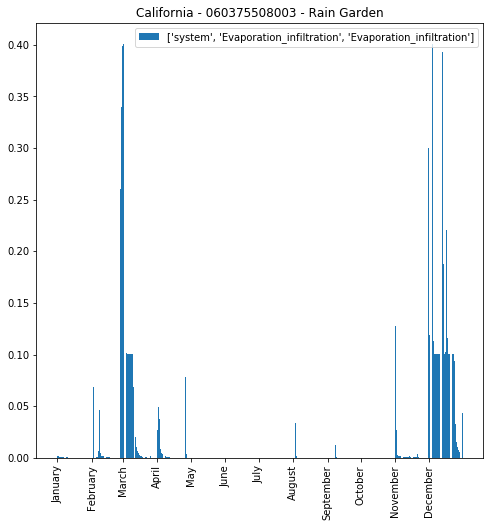

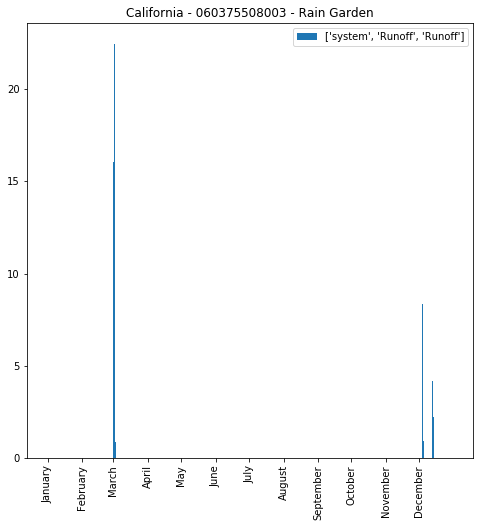

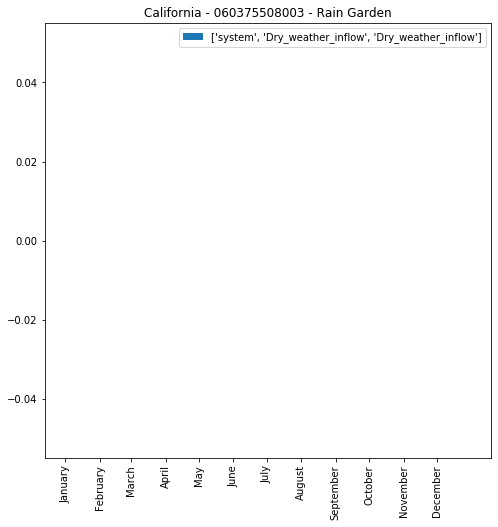

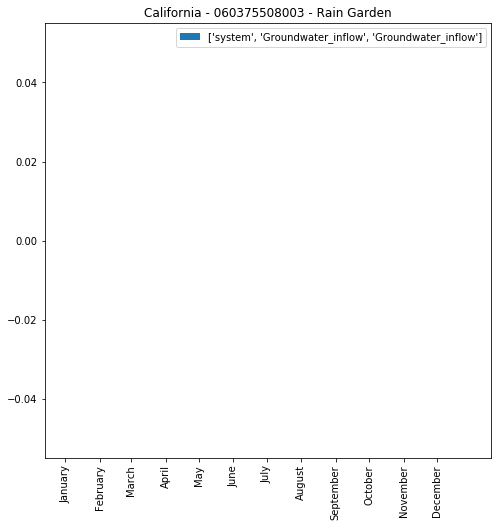

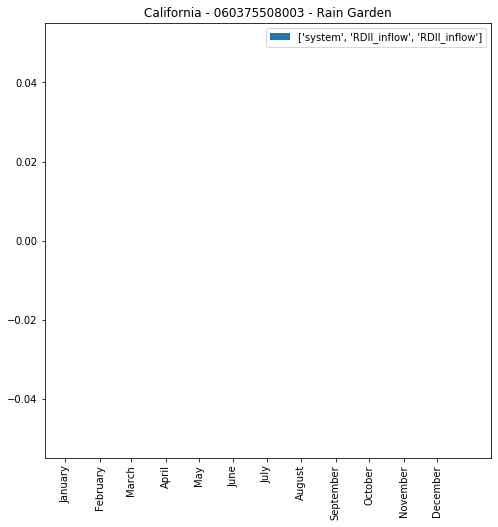

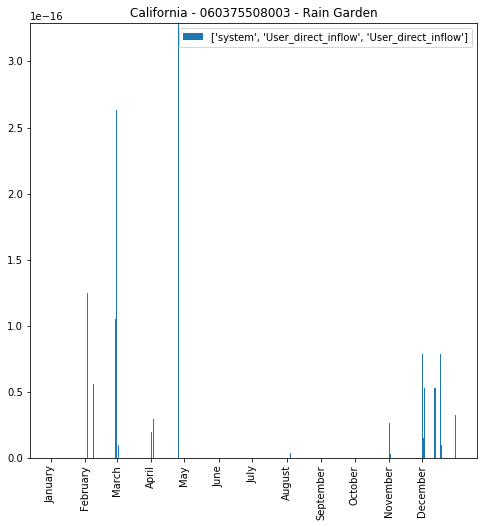

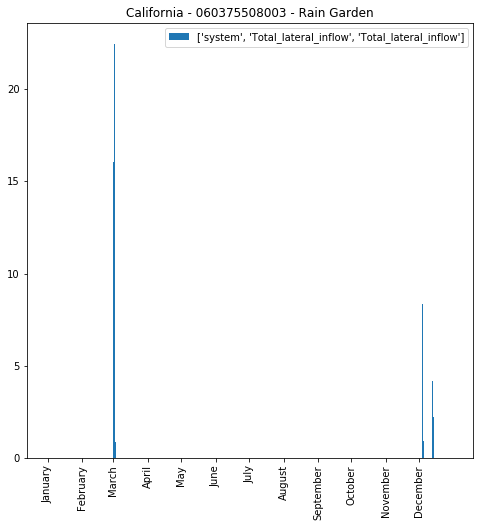

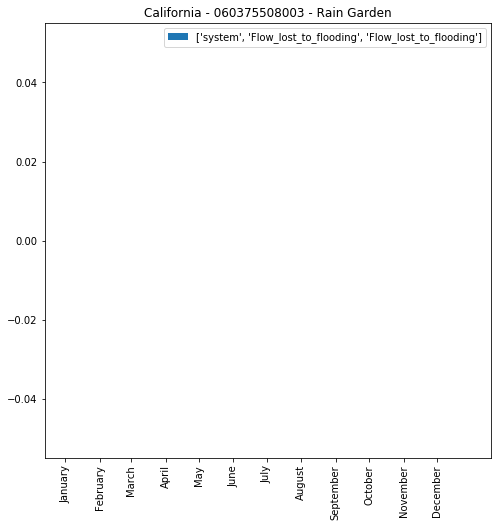

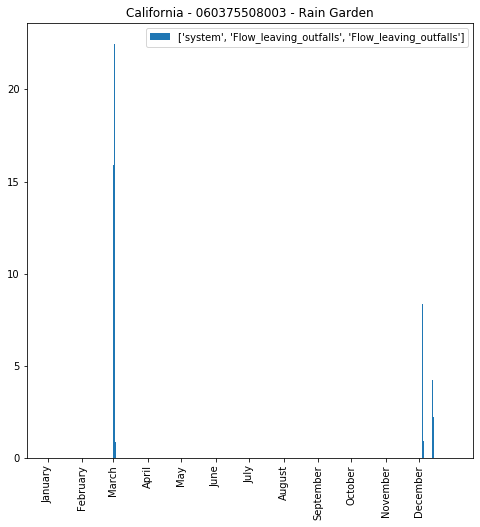

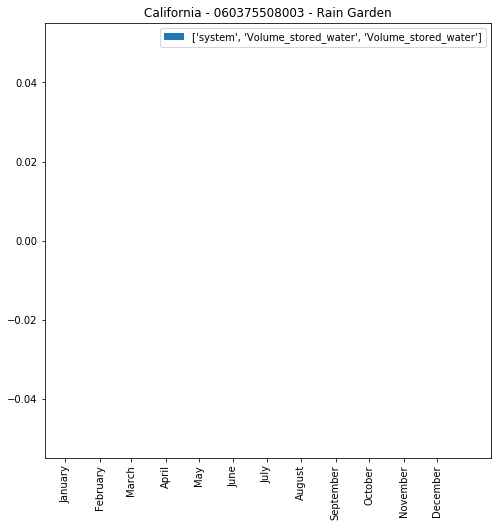

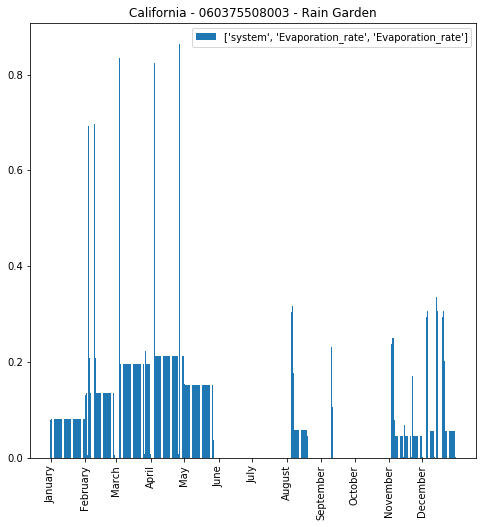

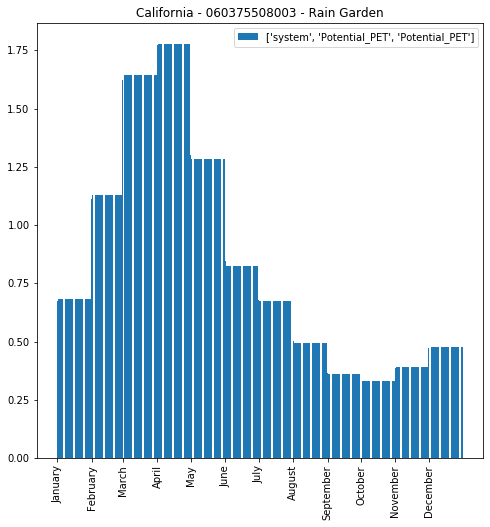

In [50]:
for file in california_files:
    gi_type = file[-6:-4]
    print(gi_type)
    extract = swmmtoolbox.catalog(file)
    
    for var in extract:
        print(var)
        system = False
        if var[0] == 'system':
            system = True

        data = swmmtoolbox.extract(file, var).resample('d').sum().iloc[-365:]
        data = data[data.columns[0]]

        plt.figure(figsize=(8,8))
        plt.title('California - 060375508003 - ' + gi_types[gi_type])
        width = 2.5

        plt.bar(date, data.iloc[-365:], label=var)
        plt.xticks([0,31,59,90,120,151,181,212,243,273,304,334], calendar.month_name[1:13], rotation=90)
        plt.legend()

        if system:
            plt.savefig('./california/' + gi_type + '/' + var[0] + '/' + var[1] + '.svg', dpi=900)
        else:
            plt.savefig('./california/' + gi_type + '/' + var[1] + '/' + var[2] + '.svg', dpi=900)

#### Contact:

Matas Lauzadis

matas.lauzadis@gmail.com

https://github.com/mataslauzadis

#### [Source Repository](https://github.com/ncsa/CPRHD_WNV_USA_SWMM)